In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
from enum import Enum

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

In [4]:
import numpy as np
import matplotlib.pyplot as plt


In [5]:
from train_validate import train, validate

In [6]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

In [7]:
class Args(object):
    pass
args = Args()
# path to dataset
args.data = './data'
args.arch = 'resnet18'
assert args.arch in model_names

In [8]:
args.workers = 4
args.epochs = 90
args.start_epoch = 0
args.batch_size = 256
args.lr = 0.1
args.momentum = 0.9
args.weight_decay = 1e-4
args.print_freq = 10

args.resume = ''
args.evaluate = False
args.pretrained = False
# distributed training
args.world_size = -1
args.rank = -1
args.dist_url = 'tcp://224.66.41.62:23456'
args.dist_backend = 'nccl'

# random seed
args.seed = None

args.gpu = 0
args.multiprocessing_distributed = 0

In [9]:
best_acc1 = 0

In [10]:
if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')

if args.gpu is not None:
    warnings.warn('You have chosen a specific GPU. This will completely '
                  'disable data parallelism.')

if args.dist_url == "env://" and args.world_size == -1:
    args.world_size = int(os.environ["WORLD_SIZE"])

args.distributed = args.world_size > 1 or args.multiprocessing_distributed
print("distributed: ", args.distributed)

distributed:  0


<ipython-input-10-41b1da30815b>:12: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '


In [11]:
ngpus_per_node = torch.cuda.device_count()
print('ngpus_per_node:', ngpus_per_node)
# if args.multiprocessing_distributed:
#     # Since we have ngpus_per_node processes per node, the total world_size
#     # needs to be adjusted accordingly
#     args.world_size = ngpus_per_node * args.world_size
#     # Use torch.multiprocessing.spawn to launch distributed processes: the
#     # main_worker process function
#     mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args))
# else:
#     # Simply call main_worker function
#     main_worker(args.gpu, ngpus_per_node, args)

ngpus_per_node: 1


In [12]:
if args.gpu is not None:
    print("Use GPU: {} for training".format(args.gpu))

if args.distributed:
    if args.dist_url == "env://" and args.rank == -1:
        args.rank = int(os.environ["RANK"])
    if args.multiprocessing_distributed:
        # For multiprocessing distributed training, rank needs to be the
        # global rank among all the processes
        args.rank = args.rank * ngpus_per_node + gpu
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                            world_size=args.world_size, rank=args.rank)
# create model
if args.pretrained:
    print("=> using pre-trained model '{}'".format(args.arch))
    model = models.__dict__[args.arch](pretrained=True)
else:
    print("=> creating model '{}'".format(args.arch))
    model = models.__dict__[args.arch]()

if not torch.cuda.is_available():
    print('using CPU, this will be slow')
elif args.distributed:
    # For multiprocessing distributed, DistributedDataParallel constructor
    # should always set the single device scope, otherwise,
    # DistributedDataParallel will use all available devices.
    if args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model.cuda(args.gpu)
        # When using a single GPU per process and per
        # DistributedDataParallel, we need to divide the batch size
        # ourselves based on the total number of GPUs we have
        args.batch_size = int(args.batch_size / ngpus_per_node)
        args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
    else:
        model.cuda()
        # DistributedDataParallel will divide and allocate batch_size to all
        # available GPUs if device_ids are not set
        model = torch.nn.parallel.DistributedDataParallel(model)
elif args.gpu is not None:
    torch.cuda.set_device(args.gpu)
    model = model.cuda(args.gpu)
else:
    # DataParallel will divide and allocate batch_size to all available GPUs
    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
    else:
        model = torch.nn.DataParallel(model).cuda()

Use GPU: 0 for training
=> creating model 'resnet18'


In [13]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda(args.gpu)

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

In [14]:
# optionally resume from a checkpoint
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        if args.gpu is None:
            checkpoint = torch.load(args.resume)
        else:
            # Map model to be loaded to specified single gpu.
            loc = 'cuda:{}'.format(args.gpu)
            checkpoint = torch.load(args.resume, map_location=loc)
        args.start_epoch = checkpoint['epoch']
        best_acc1 = checkpoint['best_acc1']
        if args.gpu is not None:
            # best_acc1 may be from a checkpoint from a different GPU
            best_acc1 = best_acc1.to(args.gpu)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

cudnn.benchmark = True

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

In [15]:
len(train_dataset)

1281167

In [16]:
if args.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
else:
    train_sampler = None

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
    num_workers=args.workers, pin_memory=True, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)

In [18]:
if args.evaluate:
    print(validate(val_loader, model, criterion, args))

# GridSearch

In [27]:
# generate candidate learning rates
args.lr_init_epoch = 2
from LRBench.lr.LR import LR
LRs = [
#     LR({'lrPolicy': 'FIX', 'k0': k/10.0}) for k in range(1, 11,)
    LR({'lrPolicy': 'FIX', 'k0': k/100.0}) for k in range(1, 11,)

]
trainResults = [] # lr -> epoch -> [tR, vR]]

In [28]:
for lrbenchLR in LRs:
    model = models.__dict__[args.arch]().cuda()
    # define loss function (criterion) and optimizer
    # specify the criterion and optimizer to the model
    criterion = nn.CrossEntropyLoss().cuda(args.gpu)

    optimizer = torch.optim.SGD(model.parameters(), lrbenchLR.getLR(0),
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    lrResults = [] # epoch -> [tR, vR]
    for epoch in range(args.lr_init_epoch):
        # train for one epoch
        tR = train(train_loader, model, criterion, optimizer, epoch, args, lrbenchLR) # losses, top1, top5
        # evaluate on validation set
        vR = validate(val_loader, model, criterion, args) # acc1
        lrResults.append([tR, vR])
    trainResults.append(lrResults)

Epoch: [0][   0/5005]	Time  1.750 ( 1.750)	Data  1.667 ( 1.667)	Loss 7.0338e+00 (7.0338e+00)	Acc@1   0.39 (  0.39)	Acc@5   0.39 (  0.39)
Epoch: [0][  10/5005]	Time  0.181 ( 0.437)	Data  0.000 ( 0.314)	Loss 7.0130e+00 (7.0068e+00)	Acc@1   0.39 (  0.18)	Acc@5   0.78 (  0.53)
Epoch: [0][  20/5005]	Time  0.720 ( 0.405)	Data  0.648 ( 0.294)	Loss 6.9853e+00 (6.9962e+00)	Acc@1   0.39 (  0.15)	Acc@5   0.39 (  0.56)
Epoch: [0][  30/5005]	Time  0.181 ( 0.377)	Data  0.070 ( 0.265)	Loss 6.9305e+00 (6.9785e+00)	Acc@1   0.39 (  0.14)	Acc@5   1.17 (  0.59)
Epoch: [0][  40/5005]	Time  0.828 ( 0.377)	Data  0.755 ( 0.267)	Loss 6.9474e+00 (6.9662e+00)	Acc@1   0.00 (  0.17)	Acc@5   0.39 (  0.63)
Epoch: [0][  50/5005]	Time  0.181 ( 0.363)	Data  0.040 ( 0.251)	Loss 6.9127e+00 (6.9575e+00)	Acc@1   0.00 (  0.16)	Acc@5   1.56 (  0.68)
Epoch: [0][  60/5005]	Time  0.854 ( 0.367)	Data  0.781 ( 0.254)	Loss 6.8419e+00 (6.9461e+00)	Acc@1   0.39 (  0.17)	Acc@5   1.95 (  0.78)
Epoch: [0][  70/5005]	Time  0.181 ( 0.464

Epoch: [0][ 600/5005]	Time  0.605 ( 0.415)	Data  0.532 ( 0.290)	Loss 6.1914e+00 (6.5286e+00)	Acc@1   2.34 (  1.06)	Acc@5   5.86 (  3.93)
Epoch: [0][ 610/5005]	Time  0.511 ( 0.414)	Data  0.433 ( 0.289)	Loss 6.1203e+00 (6.5219e+00)	Acc@1   2.73 (  1.07)	Acc@5   5.47 (  3.98)
Epoch: [0][ 620/5005]	Time  0.693 ( 0.413)	Data  0.621 ( 0.289)	Loss 6.2577e+00 (6.5160e+00)	Acc@1   1.56 (  1.08)	Acc@5   5.47 (  4.03)
Epoch: [0][ 630/5005]	Time  0.656 ( 0.412)	Data  0.582 ( 0.288)	Loss 6.1577e+00 (6.5099e+00)	Acc@1   1.95 (  1.10)	Acc@5   6.64 (  4.08)
Epoch: [0][ 640/5005]	Time  0.326 ( 0.411)	Data  0.253 ( 0.287)	Loss 6.1230e+00 (6.5031e+00)	Acc@1   1.56 (  1.12)	Acc@5   6.64 (  4.14)
Epoch: [0][ 650/5005]	Time  0.851 ( 0.410)	Data  0.778 ( 0.287)	Loss 6.2509e+00 (6.4976e+00)	Acc@1   1.95 (  1.13)	Acc@5   7.03 (  4.18)
Epoch: [0][ 660/5005]	Time  0.183 ( 0.420)	Data  0.000 ( 0.296)	Loss 6.1138e+00 (6.4911e+00)	Acc@1   1.56 (  1.15)	Acc@5   7.03 (  4.23)
Epoch: [0][ 670/5005]	Time  0.844 ( 0.431

Epoch: [0][1200/5005]	Time  0.201 ( 0.410)	Data  0.128 ( 0.279)	Loss 5.8132e+00 (6.2134e+00)	Acc@1   3.52 (  2.04)	Acc@5  12.11 (  6.96)
Epoch: [0][1210/5005]	Time  0.185 ( 0.409)	Data  0.000 ( 0.279)	Loss 5.6999e+00 (6.2093e+00)	Acc@1   4.69 (  2.06)	Acc@5  13.67 (  7.00)
Epoch: [0][1220/5005]	Time  0.519 ( 0.409)	Data  0.446 ( 0.278)	Loss 5.6476e+00 (6.2050e+00)	Acc@1   3.52 (  2.08)	Acc@5  13.28 (  7.05)
Epoch: [0][1230/5005]	Time  0.184 ( 0.408)	Data  0.000 ( 0.278)	Loss 5.7766e+00 (6.2006e+00)	Acc@1   2.73 (  2.09)	Acc@5  11.33 (  7.10)
Epoch: [0][1240/5005]	Time  0.427 ( 0.408)	Data  0.354 ( 0.277)	Loss 5.8063e+00 (6.1966e+00)	Acc@1   1.17 (  2.11)	Acc@5  10.16 (  7.15)
Epoch: [0][1250/5005]	Time  0.185 ( 0.407)	Data  0.000 ( 0.277)	Loss 5.7105e+00 (6.1926e+00)	Acc@1   3.52 (  2.13)	Acc@5  13.67 (  7.20)
Epoch: [0][1260/5005]	Time  0.542 ( 0.407)	Data  0.469 ( 0.277)	Loss 5.6977e+00 (6.1886e+00)	Acc@1   2.73 (  2.14)	Acc@5  12.50 (  7.24)
Epoch: [0][1270/5005]	Time  0.184 ( 0.406

Epoch: [0][1800/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.273)	Loss 5.4024e+00 (5.9941e+00)	Acc@1   5.47 (  3.03)	Acc@5  19.53 (  9.57)
Epoch: [0][1810/5005]	Time  0.184 ( 0.400)	Data  0.000 ( 0.273)	Loss 5.4700e+00 (5.9909e+00)	Acc@1   5.08 (  3.04)	Acc@5  19.14 (  9.61)
Epoch: [0][1820/5005]	Time  0.184 ( 0.400)	Data  0.000 ( 0.272)	Loss 5.2870e+00 (5.9876e+00)	Acc@1   5.86 (  3.06)	Acc@5  17.19 (  9.65)
Epoch: [0][1830/5005]	Time  0.185 ( 0.400)	Data  0.000 ( 0.272)	Loss 5.2906e+00 (5.9847e+00)	Acc@1  10.94 (  3.08)	Acc@5  21.88 (  9.69)
Epoch: [0][1840/5005]	Time  0.185 ( 0.400)	Data  0.000 ( 0.272)	Loss 5.4666e+00 (5.9820e+00)	Acc@1   3.12 (  3.09)	Acc@5  16.41 (  9.72)
Epoch: [0][1850/5005]	Time  0.184 ( 0.399)	Data  0.000 ( 0.271)	Loss 5.6647e+00 (5.9789e+00)	Acc@1   6.25 (  3.10)	Acc@5  14.45 (  9.76)
Epoch: [0][1860/5005]	Time  0.185 ( 0.399)	Data  0.000 ( 0.271)	Loss 5.4432e+00 (5.9757e+00)	Acc@1   5.08 (  3.12)	Acc@5  17.58 (  9.81)
Epoch: [0][1870/5005]	Time  0.185 ( 0.399

Epoch: [0][2400/5005]	Time  0.184 ( 0.410)	Data  0.000 ( 0.279)	Loss 5.1678e+00 (5.8229e+00)	Acc@1   6.64 (  3.95)	Acc@5  21.48 ( 11.85)
Epoch: [0][2410/5005]	Time  0.184 ( 0.410)	Data  0.000 ( 0.279)	Loss 4.9683e+00 (5.8204e+00)	Acc@1  10.16 (  3.97)	Acc@5  23.44 ( 11.89)
Epoch: [0][2420/5005]	Time  0.184 ( 0.409)	Data  0.000 ( 0.278)	Loss 5.1675e+00 (5.8178e+00)	Acc@1   5.08 (  3.98)	Acc@5  19.53 ( 11.92)
Epoch: [0][2430/5005]	Time  0.183 ( 0.409)	Data  0.000 ( 0.278)	Loss 5.1738e+00 (5.8152e+00)	Acc@1   5.86 (  4.00)	Acc@5  23.05 ( 11.96)
Epoch: [0][2440/5005]	Time  0.184 ( 0.409)	Data  0.000 ( 0.278)	Loss 5.2328e+00 (5.8126e+00)	Acc@1  10.94 (  4.02)	Acc@5  22.27 ( 12.00)
Epoch: [0][2450/5005]	Time  0.184 ( 0.409)	Data  0.000 ( 0.277)	Loss 5.3189e+00 (5.8102e+00)	Acc@1   6.64 (  4.03)	Acc@5  17.97 ( 12.03)
Epoch: [0][2460/5005]	Time  0.201 ( 0.411)	Data  0.000 ( 0.280)	Loss 5.2369e+00 (5.8076e+00)	Acc@1   7.42 (  4.05)	Acc@5  22.27 ( 12.06)
Epoch: [0][2470/5005]	Time  0.183 ( 0.411

Epoch: [0][3000/5005]	Time  0.184 ( 0.410)	Data  0.000 ( 0.276)	Loss 5.1481e+00 (5.6775e+00)	Acc@1   9.38 (  4.84)	Acc@5  22.27 ( 13.95)
Epoch: [0][3010/5005]	Time  0.184 ( 0.410)	Data  0.000 ( 0.276)	Loss 5.0049e+00 (5.6752e+00)	Acc@1  12.11 (  4.86)	Acc@5  24.61 ( 13.99)
Epoch: [0][3020/5005]	Time  0.184 ( 0.409)	Data  0.000 ( 0.275)	Loss 5.0017e+00 (5.6730e+00)	Acc@1   8.59 (  4.87)	Acc@5  23.83 ( 14.02)
Epoch: [0][3030/5005]	Time  0.185 ( 0.409)	Data  0.000 ( 0.275)	Loss 5.1784e+00 (5.6708e+00)	Acc@1   6.25 (  4.89)	Acc@5  22.27 ( 14.06)
Epoch: [0][3040/5005]	Time  0.185 ( 0.409)	Data  0.000 ( 0.275)	Loss 5.0556e+00 (5.6686e+00)	Acc@1   7.03 (  4.90)	Acc@5  23.83 ( 14.09)
Epoch: [0][3050/5005]	Time  0.185 ( 0.409)	Data  0.000 ( 0.275)	Loss 4.8636e+00 (5.6666e+00)	Acc@1   9.38 (  4.91)	Acc@5  23.05 ( 14.12)
Epoch: [0][3060/5005]	Time  0.185 ( 0.409)	Data  0.000 ( 0.274)	Loss 4.9215e+00 (5.6644e+00)	Acc@1  11.33 (  4.93)	Acc@5  23.05 ( 14.15)
Epoch: [0][3070/5005]	Time  0.187 ( 0.408

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][3280/5005]	Time  0.189 ( 0.407)	Data  0.000 ( 0.271)	Loss 4.8507e+00 (5.6165e+00)	Acc@1   6.25 (  5.25)	Acc@5  23.05 ( 14.89)
Epoch: [0][3290/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.271)	Loss 4.8273e+00 (5.6143e+00)	Acc@1  10.55 (  5.27)	Acc@5  25.39 ( 14.92)
Epoch: [0][3300/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.271)	Loss 4.9714e+00 (5.6121e+00)	Acc@1   9.77 (  5.28)	Acc@5  23.83 ( 14.96)
Epoch: [0][3310/5005]	Time  0.185 ( 0.406)	Data  0.000 ( 0.271)	Loss 4.6681e+00 (5.6101e+00)	Acc@1  12.89 (  5.30)	Acc@5  28.52 ( 14.99)
Epoch: [0][3320/5005]	Time  0.184 ( 0.406)	Data  0.110 ( 0.271)	Loss 4.9445e+00 (5.6080e+00)	Acc@1  12.50 (  5.31)	Acc@5  25.00 ( 15.02)
Epoch: [0][3330/5005]	Time  0.185 ( 0.406)	Data  0.000 ( 0.270)	Loss 4.8645e+00 (5.6060e+00)	Acc@1  10.94 (  5.33)	Acc@5  23.83 ( 15.05)
Epoch: [0][3340/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.270)	Loss 4.7685e+00 (5.6039e+00)	Acc@1  14.45 (  5.35)	Acc@5  28.91 ( 15.08)
Epoch: [0][3350/5005]	Time  0.184 ( 0.405

Epoch: [0][3880/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.271)	Loss 4.6917e+00 (5.4959e+00)	Acc@1  11.33 (  6.15)	Acc@5  28.12 ( 16.78)
Epoch: [0][3890/5005]	Time  0.183 ( 0.406)	Data  0.000 ( 0.271)	Loss 4.9791e+00 (5.4942e+00)	Acc@1   8.59 (  6.16)	Acc@5  20.31 ( 16.80)
Epoch: [0][3900/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.271)	Loss 4.6175e+00 (5.4922e+00)	Acc@1   9.38 (  6.18)	Acc@5  30.86 ( 16.83)
Epoch: [0][3910/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.271)	Loss 4.6621e+00 (5.4903e+00)	Acc@1  12.50 (  6.19)	Acc@5  29.69 ( 16.86)
Epoch: [0][3920/5005]	Time  0.187 ( 0.406)	Data  0.000 ( 0.270)	Loss 4.6300e+00 (5.4885e+00)	Acc@1  10.94 (  6.21)	Acc@5  31.64 ( 16.89)
Epoch: [0][3930/5005]	Time  0.183 ( 0.406)	Data  0.000 ( 0.270)	Loss 4.7559e+00 (5.4868e+00)	Acc@1  11.72 (  6.22)	Acc@5  28.12 ( 16.92)
Epoch: [0][3940/5005]	Time  0.186 ( 0.405)	Data  0.000 ( 0.270)	Loss 4.6591e+00 (5.4848e+00)	Acc@1  10.16 (  6.23)	Acc@5  29.69 ( 16.95)
Epoch: [0][3950/5005]	Time  0.183 ( 0.405

Epoch: [0][4480/5005]	Time  0.184 ( 0.405)	Data  0.000 ( 0.270)	Loss 4.8137e+00 (5.3877e+00)	Acc@1  10.55 (  7.02)	Acc@5  28.12 ( 18.54)
Epoch: [0][4490/5005]	Time  0.800 ( 0.405)	Data  0.724 ( 0.270)	Loss 4.7612e+00 (5.3859e+00)	Acc@1  14.45 (  7.03)	Acc@5  29.69 ( 18.57)
Epoch: [0][4500/5005]	Time  0.183 ( 0.405)	Data  0.000 ( 0.270)	Loss 4.7137e+00 (5.3843e+00)	Acc@1  13.67 (  7.05)	Acc@5  31.64 ( 18.60)
Epoch: [0][4510/5005]	Time  0.881 ( 0.405)	Data  0.807 ( 0.270)	Loss 4.4998e+00 (5.3825e+00)	Acc@1  17.58 (  7.06)	Acc@5  33.59 ( 18.63)
Epoch: [0][4520/5005]	Time  0.184 ( 0.405)	Data  0.000 ( 0.270)	Loss 4.5845e+00 (5.3809e+00)	Acc@1  13.67 (  7.08)	Acc@5  33.59 ( 18.66)
Epoch: [0][4530/5005]	Time  2.026 ( 0.405)	Data  1.954 ( 0.270)	Loss 4.7051e+00 (5.3793e+00)	Acc@1  15.62 (  7.09)	Acc@5  31.25 ( 18.69)
Epoch: [0][4540/5005]	Time  0.184 ( 0.405)	Data  0.000 ( 0.270)	Loss 4.6595e+00 (5.3776e+00)	Acc@1  16.02 (  7.11)	Acc@5  32.03 ( 18.71)
Epoch: [0][4550/5005]	Time  0.746 ( 0.405

Test: [ 90/196]	Time  0.154 ( 0.434)	Loss 5.3928e+00 (4.3329e+00)	Acc@1   3.12 ( 14.59)	Acc@5  15.23 ( 34.65)
Test: [100/196]	Time  0.645 ( 0.427)	Loss 5.3034e+00 (4.3685e+00)	Acc@1   2.34 ( 14.35)	Acc@5  14.06 ( 34.20)
Test: [110/196]	Time  0.281 ( 0.426)	Loss 4.3518e+00 (4.3731e+00)	Acc@1  16.41 ( 14.64)	Acc@5  40.62 ( 34.34)
Test: [120/196]	Time  0.796 ( 0.424)	Loss 4.9746e+00 (4.4013e+00)	Acc@1  15.23 ( 14.54)	Acc@5  26.56 ( 33.90)
Test: [130/196]	Time  0.780 ( 0.422)	Loss 4.6158e+00 (4.4167e+00)	Acc@1   7.81 ( 14.35)	Acc@5  33.98 ( 33.81)
Test: [140/196]	Time  0.306 ( 0.418)	Loss 5.0126e+00 (4.4444e+00)	Acc@1   5.08 ( 14.11)	Acc@5  20.31 ( 33.32)
Test: [150/196]	Time  0.965 ( 0.417)	Loss 5.0910e+00 (4.4760e+00)	Acc@1   5.47 ( 13.80)	Acc@5  19.14 ( 32.71)
Test: [160/196]	Time  0.171 ( 0.414)	Loss 4.5045e+00 (4.4925e+00)	Acc@1  11.72 ( 13.68)	Acc@5  29.30 ( 32.44)
Test: [170/196]	Time  1.116 ( 0.414)	Loss 3.5167e+00 (4.5070e+00)	Acc@1  23.44 ( 13.48)	Acc@5  56.25 ( 32.11)
Test: [180

Epoch: [1][ 510/5005]	Time  0.183 ( 0.412)	Data  0.000 ( 0.269)	Loss 4.2980e+00 (4.4294e+00)	Acc@1  17.58 ( 15.55)	Acc@5  36.33 ( 34.67)
Epoch: [1][ 520/5005]	Time  0.185 ( 0.427)	Data  0.000 ( 0.284)	Loss 4.4793e+00 (4.4297e+00)	Acc@1  16.80 ( 15.54)	Acc@5  32.03 ( 34.66)
Epoch: [1][ 530/5005]	Time  0.184 ( 0.425)	Data  0.000 ( 0.282)	Loss 4.4581e+00 (4.4294e+00)	Acc@1  16.02 ( 15.55)	Acc@5  37.11 ( 34.69)
Epoch: [1][ 540/5005]	Time  0.184 ( 0.423)	Data  0.000 ( 0.280)	Loss 4.4359e+00 (4.4295e+00)	Acc@1  16.41 ( 15.54)	Acc@5  36.72 ( 34.70)
Epoch: [1][ 550/5005]	Time  0.184 ( 0.423)	Data  0.000 ( 0.279)	Loss 4.4893e+00 (4.4286e+00)	Acc@1  14.84 ( 15.55)	Acc@5  30.86 ( 34.70)
Epoch: [1][ 560/5005]	Time  0.184 ( 0.421)	Data  0.000 ( 0.277)	Loss 4.5619e+00 (4.4279e+00)	Acc@1  16.02 ( 15.57)	Acc@5  35.94 ( 34.73)
Epoch: [1][ 570/5005]	Time  0.183 ( 0.420)	Data  0.000 ( 0.277)	Loss 4.3074e+00 (4.4279e+00)	Acc@1  13.28 ( 15.56)	Acc@5  37.50 ( 34.75)
Epoch: [1][ 580/5005]	Time  0.185 ( 0.418

Epoch: [1][1110/5005]	Time  0.183 ( 0.441)	Data  0.000 ( 0.299)	Loss 4.1052e+00 (4.3768e+00)	Acc@1  19.92 ( 16.12)	Acc@5  43.75 ( 35.67)
Epoch: [1][1120/5005]	Time  0.185 ( 0.440)	Data  0.000 ( 0.297)	Loss 4.3192e+00 (4.3761e+00)	Acc@1  17.97 ( 16.13)	Acc@5  38.67 ( 35.69)
Epoch: [1][1130/5005]	Time  0.184 ( 0.439)	Data  0.000 ( 0.297)	Loss 4.1930e+00 (4.3749e+00)	Acc@1  16.02 ( 16.15)	Acc@5  37.89 ( 35.71)
Epoch: [1][1140/5005]	Time  0.184 ( 0.438)	Data  0.000 ( 0.296)	Loss 4.3687e+00 (4.3737e+00)	Acc@1  13.67 ( 16.17)	Acc@5  35.55 ( 35.73)
Epoch: [1][1150/5005]	Time  0.185 ( 0.438)	Data  0.000 ( 0.295)	Loss 4.3739e+00 (4.3729e+00)	Acc@1  19.14 ( 16.18)	Acc@5  35.55 ( 35.74)
Epoch: [1][1160/5005]	Time  0.203 ( 0.437)	Data  0.000 ( 0.294)	Loss 4.1392e+00 (4.3721e+00)	Acc@1  17.58 ( 16.20)	Acc@5  40.62 ( 35.76)
Epoch: [1][1170/5005]	Time  0.184 ( 0.437)	Data  0.000 ( 0.294)	Loss 4.1616e+00 (4.3714e+00)	Acc@1  16.02 ( 16.20)	Acc@5  40.23 ( 35.78)
Epoch: [1][1180/5005]	Time  0.186 ( 0.436

Epoch: [1][1710/5005]	Time  0.184 ( 0.419)	Data  0.000 ( 0.276)	Loss 4.2726e+00 (4.3224e+00)	Acc@1  20.31 ( 16.87)	Acc@5  39.06 ( 36.77)
Epoch: [1][1720/5005]	Time  0.299 ( 0.419)	Data  0.225 ( 0.275)	Loss 4.2517e+00 (4.3218e+00)	Acc@1  17.58 ( 16.87)	Acc@5  34.77 ( 36.78)
Epoch: [1][1730/5005]	Time  0.184 ( 0.418)	Data  0.000 ( 0.275)	Loss 4.2394e+00 (4.3212e+00)	Acc@1  18.36 ( 16.87)	Acc@5  39.06 ( 36.80)
Epoch: [1][1740/5005]	Time  0.206 ( 0.418)	Data  0.000 ( 0.275)	Loss 4.3063e+00 (4.3206e+00)	Acc@1  19.14 ( 16.88)	Acc@5  35.94 ( 36.81)
Epoch: [1][1750/5005]	Time  0.185 ( 0.418)	Data  0.000 ( 0.274)	Loss 4.1868e+00 (4.3198e+00)	Acc@1  14.45 ( 16.89)	Acc@5  36.72 ( 36.81)
Epoch: [1][1760/5005]	Time  0.185 ( 0.417)	Data  0.039 ( 0.274)	Loss 4.0935e+00 (4.3193e+00)	Acc@1  18.36 ( 16.89)	Acc@5  38.28 ( 36.83)
Epoch: [1][1770/5005]	Time  0.185 ( 0.417)	Data  0.000 ( 0.273)	Loss 4.3671e+00 (4.3184e+00)	Acc@1  18.75 ( 16.90)	Acc@5  35.16 ( 36.84)
Epoch: [1][1780/5005]	Time  0.184 ( 0.416

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][1860/5005]	Time  0.184 ( 0.413)	Data  0.000 ( 0.270)	Loss 4.3261e+00 (4.3096e+00)	Acc@1  18.75 ( 17.01)	Acc@5  40.23 ( 37.00)
Epoch: [1][1870/5005]	Time  0.184 ( 0.413)	Data  0.000 ( 0.269)	Loss 4.2281e+00 (4.3091e+00)	Acc@1  23.05 ( 17.03)	Acc@5  41.80 ( 37.01)
Epoch: [1][1880/5005]	Time  0.184 ( 0.413)	Data  0.000 ( 0.269)	Loss 4.0885e+00 (4.3078e+00)	Acc@1  22.66 ( 17.05)	Acc@5  39.84 ( 37.04)
Epoch: [1][1890/5005]	Time  0.185 ( 0.412)	Data  0.000 ( 0.269)	Loss 4.1128e+00 (4.3069e+00)	Acc@1  17.97 ( 17.06)	Acc@5  45.31 ( 37.06)
Epoch: [1][1900/5005]	Time  0.184 ( 0.412)	Data  0.000 ( 0.268)	Loss 4.0680e+00 (4.3067e+00)	Acc@1  21.48 ( 17.06)	Acc@5  41.02 ( 37.06)
Epoch: [1][1910/5005]	Time  0.185 ( 0.412)	Data  0.000 ( 0.268)	Loss 4.2288e+00 (4.3061e+00)	Acc@1  14.84 ( 17.07)	Acc@5  35.55 ( 37.08)
Epoch: [1][1920/5005]	Time  0.184 ( 0.411)	Data  0.000 ( 0.267)	Loss 3.9915e+00 (4.3053e+00)	Acc@1  22.66 ( 17.08)	Acc@5  44.14 ( 37.10)
Epoch: [1][1930/5005]	Time  0.185 ( 0.411

Epoch: [1][2460/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.259)	Loss 4.4170e+00 (4.2642e+00)	Acc@1  16.80 ( 17.60)	Acc@5  38.28 ( 37.89)
Epoch: [1][2470/5005]	Time  0.870 ( 0.401)	Data  0.796 ( 0.259)	Loss 3.8696e+00 (4.2633e+00)	Acc@1  23.05 ( 17.62)	Acc@5  40.23 ( 37.91)
Epoch: [1][2480/5005]	Time  0.185 ( 0.400)	Data  0.000 ( 0.259)	Loss 3.8741e+00 (4.2624e+00)	Acc@1  22.27 ( 17.63)	Acc@5  48.05 ( 37.92)
Epoch: [1][2490/5005]	Time  0.715 ( 0.400)	Data  0.643 ( 0.259)	Loss 4.2576e+00 (4.2617e+00)	Acc@1  15.62 ( 17.64)	Acc@5  41.02 ( 37.94)
Epoch: [1][2500/5005]	Time  0.184 ( 0.400)	Data  0.000 ( 0.259)	Loss 4.2503e+00 (4.2610e+00)	Acc@1  19.53 ( 17.66)	Acc@5  38.67 ( 37.96)
Epoch: [1][2510/5005]	Time  0.464 ( 0.400)	Data  0.392 ( 0.259)	Loss 4.0596e+00 (4.2603e+00)	Acc@1  21.88 ( 17.66)	Acc@5  41.02 ( 37.97)
Epoch: [1][2520/5005]	Time  0.186 ( 0.403)	Data  0.000 ( 0.262)	Loss 4.0367e+00 (4.2596e+00)	Acc@1  21.48 ( 17.67)	Acc@5  43.36 ( 37.98)
Epoch: [1][2530/5005]	Time  0.224 ( 0.403

Epoch: [1][3060/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.256)	Loss 3.9102e+00 (4.2196e+00)	Acc@1  22.66 ( 18.19)	Acc@5  44.53 ( 38.74)
Epoch: [1][3070/5005]	Time  0.183 ( 0.396)	Data  0.041 ( 0.256)	Loss 4.0785e+00 (4.2188e+00)	Acc@1  17.19 ( 18.20)	Acc@5  42.97 ( 38.76)
Epoch: [1][3080/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.256)	Loss 4.1544e+00 (4.2181e+00)	Acc@1  16.80 ( 18.21)	Acc@5  37.50 ( 38.77)
Epoch: [1][3090/5005]	Time  0.217 ( 0.396)	Data  0.143 ( 0.256)	Loss 3.9952e+00 (4.2174e+00)	Acc@1  16.80 ( 18.22)	Acc@5  40.62 ( 38.78)
Epoch: [1][3100/5005]	Time  0.183 ( 0.396)	Data  0.000 ( 0.256)	Loss 4.0314e+00 (4.2166e+00)	Acc@1  20.31 ( 18.23)	Acc@5  41.02 ( 38.80)
Epoch: [1][3110/5005]	Time  0.195 ( 0.395)	Data  0.122 ( 0.256)	Loss 4.0242e+00 (4.2157e+00)	Acc@1  21.09 ( 18.24)	Acc@5  40.23 ( 38.81)
Epoch: [1][3120/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.256)	Loss 3.9142e+00 (4.2149e+00)	Acc@1  22.27 ( 18.25)	Acc@5  45.70 ( 38.83)
Epoch: [1][3130/5005]	Time  0.183 ( 0.395

Epoch: [1][3660/5005]	Time  0.183 ( 0.397)	Data  0.000 ( 0.258)	Loss 3.8291e+00 (4.1758e+00)	Acc@1  23.83 ( 18.76)	Acc@5  48.83 ( 39.59)
Epoch: [1][3670/5005]	Time  0.183 ( 0.397)	Data  0.000 ( 0.258)	Loss 3.9970e+00 (4.1748e+00)	Acc@1  19.14 ( 18.77)	Acc@5  44.14 ( 39.60)
Epoch: [1][3680/5005]	Time  0.183 ( 0.397)	Data  0.000 ( 0.258)	Loss 3.6582e+00 (4.1742e+00)	Acc@1  28.52 ( 18.78)	Acc@5  48.05 ( 39.62)
Epoch: [1][3690/5005]	Time  0.184 ( 0.397)	Data  0.000 ( 0.258)	Loss 3.6104e+00 (4.1733e+00)	Acc@1  27.34 ( 18.79)	Acc@5  47.66 ( 39.63)
Epoch: [1][3700/5005]	Time  0.184 ( 0.397)	Data  0.000 ( 0.258)	Loss 3.8320e+00 (4.1726e+00)	Acc@1  23.05 ( 18.80)	Acc@5  45.31 ( 39.64)
Epoch: [1][3710/5005]	Time  0.185 ( 0.397)	Data  0.000 ( 0.258)	Loss 3.7152e+00 (4.1718e+00)	Acc@1  26.17 ( 18.81)	Acc@5  50.39 ( 39.65)
Epoch: [1][3720/5005]	Time  0.184 ( 0.397)	Data  0.000 ( 0.257)	Loss 4.1161e+00 (4.1711e+00)	Acc@1  16.80 ( 18.82)	Acc@5  37.11 ( 39.67)
Epoch: [1][3730/5005]	Time  0.183 ( 0.398

Epoch: [1][4260/5005]	Time  0.522 ( 0.395)	Data  0.449 ( 0.257)	Loss 3.9160e+00 (4.1352e+00)	Acc@1  21.09 ( 19.30)	Acc@5  47.27 ( 40.34)
Epoch: [1][4270/5005]	Time  0.491 ( 0.397)	Data  0.417 ( 0.259)	Loss 3.8649e+00 (4.1348e+00)	Acc@1  25.78 ( 19.31)	Acc@5  44.92 ( 40.35)
Epoch: [1][4280/5005]	Time  0.747 ( 0.397)	Data  0.674 ( 0.259)	Loss 3.7368e+00 (4.1340e+00)	Acc@1  24.61 ( 19.32)	Acc@5  48.05 ( 40.36)
Epoch: [1][4290/5005]	Time  0.184 ( 0.396)	Data  0.107 ( 0.259)	Loss 4.0144e+00 (4.1332e+00)	Acc@1  23.05 ( 19.33)	Acc@5  48.44 ( 40.38)
Epoch: [1][4300/5005]	Time  0.488 ( 0.396)	Data  0.415 ( 0.259)	Loss 3.7773e+00 (4.1327e+00)	Acc@1  23.83 ( 19.34)	Acc@5  48.44 ( 40.39)
Epoch: [1][4310/5005]	Time  0.473 ( 0.396)	Data  0.401 ( 0.259)	Loss 3.9674e+00 (4.1320e+00)	Acc@1  23.83 ( 19.34)	Acc@5  45.31 ( 40.41)
Epoch: [1][4320/5005]	Time  0.391 ( 0.396)	Data  0.318 ( 0.259)	Loss 3.7472e+00 (4.1312e+00)	Acc@1  25.00 ( 19.35)	Acc@5  48.05 ( 40.42)
Epoch: [1][4330/5005]	Time  0.589 ( 0.396

Epoch: [1][4860/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.262)	Loss 3.6060e+00 (4.0969e+00)	Acc@1  32.03 ( 19.85)	Acc@5  50.39 ( 41.09)
Epoch: [1][4870/5005]	Time  0.964 ( 0.398)	Data  0.891 ( 0.262)	Loss 3.6091e+00 (4.0961e+00)	Acc@1  23.83 ( 19.86)	Acc@5  51.17 ( 41.11)
Epoch: [1][4880/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.262)	Loss 3.8658e+00 (4.0954e+00)	Acc@1  19.14 ( 19.87)	Acc@5  42.97 ( 41.12)
Epoch: [1][4890/5005]	Time  0.780 ( 0.398)	Data  0.706 ( 0.262)	Loss 3.9477e+00 (4.0947e+00)	Acc@1  21.88 ( 19.88)	Acc@5  46.48 ( 41.14)
Epoch: [1][4900/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.262)	Loss 4.1050e+00 (4.0942e+00)	Acc@1  18.75 ( 19.88)	Acc@5  41.41 ( 41.15)
Epoch: [1][4910/5005]	Time  0.811 ( 0.398)	Data  0.737 ( 0.262)	Loss 4.0212e+00 (4.0938e+00)	Acc@1  19.53 ( 19.89)	Acc@5  42.97 ( 41.16)
Epoch: [1][4920/5005]	Time  0.185 ( 0.397)	Data  0.000 ( 0.261)	Loss 3.8381e+00 (4.0932e+00)	Acc@1  27.34 ( 19.90)	Acc@5  47.66 ( 41.17)
Epoch: [1][4930/5005]	Time  0.921 ( 0.397

Epoch: [0][ 290/5005]	Time  0.534 ( 0.376)	Data  0.462 ( 0.235)	Loss 6.5690e+00 (6.7268e+00)	Acc@1   1.56 (  0.62)	Acc@5   3.52 (  2.37)
Epoch: [0][ 300/5005]	Time  0.465 ( 0.374)	Data  0.393 ( 0.235)	Loss 6.4444e+00 (6.7173e+00)	Acc@1   1.56 (  0.63)	Acc@5   5.08 (  2.42)
Epoch: [0][ 310/5005]	Time  0.370 ( 0.373)	Data  0.298 ( 0.234)	Loss 6.4778e+00 (6.7086e+00)	Acc@1   0.39 (  0.64)	Acc@5   3.12 (  2.47)
Epoch: [0][ 320/5005]	Time  0.504 ( 0.372)	Data  0.429 ( 0.234)	Loss 6.4408e+00 (6.7001e+00)	Acc@1   1.56 (  0.66)	Acc@5   4.69 (  2.53)
Epoch: [0][ 330/5005]	Time  0.571 ( 0.371)	Data  0.498 ( 0.234)	Loss 6.3900e+00 (6.6910e+00)	Acc@1   0.00 (  0.68)	Acc@5   3.12 (  2.59)
Epoch: [0][ 340/5005]	Time  0.421 ( 0.370)	Data  0.347 ( 0.233)	Loss 6.3015e+00 (6.6815e+00)	Acc@1   1.17 (  0.70)	Acc@5   6.64 (  2.68)
Epoch: [0][ 350/5005]	Time  0.872 ( 0.370)	Data  0.800 ( 0.234)	Loss 6.3059e+00 (6.6723e+00)	Acc@1   0.78 (  0.70)	Acc@5   3.12 (  2.71)
Epoch: [0][ 360/5005]	Time  0.183 ( 0.369

Epoch: [0][ 890/5005]	Time  0.865 ( 0.410)	Data  0.791 ( 0.273)	Loss 5.7781e+00 (6.2897e+00)	Acc@1   3.12 (  1.77)	Acc@5  12.11 (  6.00)
Epoch: [0][ 900/5005]	Time  0.185 ( 0.408)	Data  0.038 ( 0.272)	Loss 5.7466e+00 (6.2841e+00)	Acc@1   3.52 (  1.79)	Acc@5  11.33 (  6.06)
Epoch: [0][ 910/5005]	Time  0.823 ( 0.408)	Data  0.749 ( 0.271)	Loss 5.8457e+00 (6.2786e+00)	Acc@1   3.52 (  1.81)	Acc@5   9.77 (  6.12)
Epoch: [0][ 920/5005]	Time  0.184 ( 0.407)	Data  0.040 ( 0.270)	Loss 5.5901e+00 (6.2728e+00)	Acc@1   3.91 (  1.83)	Acc@5  14.84 (  6.18)
Epoch: [0][ 930/5005]	Time  0.874 ( 0.407)	Data  0.802 ( 0.270)	Loss 5.6773e+00 (6.2674e+00)	Acc@1   3.52 (  1.84)	Acc@5   9.77 (  6.23)
Epoch: [0][ 940/5005]	Time  0.184 ( 0.406)	Data  0.085 ( 0.269)	Loss 5.7260e+00 (6.2616e+00)	Acc@1   4.69 (  1.86)	Acc@5  15.23 (  6.29)
Epoch: [0][ 950/5005]	Time  0.801 ( 0.406)	Data  0.729 ( 0.269)	Loss 5.6795e+00 (6.2558e+00)	Acc@1   4.30 (  1.89)	Acc@5  12.89 (  6.35)
Epoch: [0][ 960/5005]	Time  0.185 ( 0.405

Epoch: [0][1490/5005]	Time  0.184 ( 0.405)	Data  0.000 ( 0.272)	Loss 5.3778e+00 (5.9908e+00)	Acc@1   5.08 (  3.08)	Acc@5  13.28 (  9.57)
Epoch: [0][1500/5005]	Time  0.184 ( 0.404)	Data  0.041 ( 0.272)	Loss 5.5960e+00 (5.9865e+00)	Acc@1   4.30 (  3.10)	Acc@5  12.89 (  9.63)
Epoch: [0][1510/5005]	Time  0.183 ( 0.416)	Data  0.000 ( 0.283)	Loss 5.1024e+00 (5.9821e+00)	Acc@1   6.25 (  3.13)	Acc@5  22.27 (  9.70)
Epoch: [0][1520/5005]	Time  0.183 ( 0.415)	Data  0.039 ( 0.282)	Loss 5.4179e+00 (5.9783e+00)	Acc@1   3.52 (  3.14)	Acc@5  14.84 (  9.74)
Epoch: [0][1530/5005]	Time  0.184 ( 0.415)	Data  0.000 ( 0.282)	Loss 5.3265e+00 (5.9745e+00)	Acc@1   5.47 (  3.16)	Acc@5  19.14 (  9.79)
Epoch: [0][1540/5005]	Time  0.278 ( 0.415)	Data  0.205 ( 0.282)	Loss 5.2718e+00 (5.9706e+00)	Acc@1   5.86 (  3.19)	Acc@5  17.58 (  9.84)
Epoch: [0][1550/5005]	Time  0.184 ( 0.414)	Data  0.000 ( 0.281)	Loss 5.1916e+00 (5.9665e+00)	Acc@1   4.69 (  3.21)	Acc@5  19.14 (  9.89)
Epoch: [0][1560/5005]	Time  0.261 ( 0.414

Epoch: [0][2090/5005]	Time  0.799 ( 0.406)	Data  0.726 ( 0.273)	Loss 5.0326e+00 (5.7658e+00)	Acc@1  10.55 (  4.34)	Acc@5  25.78 ( 12.67)
Epoch: [0][2100/5005]	Time  0.188 ( 0.406)	Data  0.115 ( 0.273)	Loss 5.0426e+00 (5.7626e+00)	Acc@1   7.42 (  4.36)	Acc@5  23.83 ( 12.72)
Epoch: [0][2110/5005]	Time  0.884 ( 0.406)	Data  0.812 ( 0.273)	Loss 5.2511e+00 (5.7593e+00)	Acc@1   8.20 (  4.38)	Acc@5  22.66 ( 12.77)
Epoch: [0][2120/5005]	Time  0.184 ( 0.405)	Data  0.083 ( 0.272)	Loss 4.9657e+00 (5.7560e+00)	Acc@1   8.20 (  4.40)	Acc@5  21.88 ( 12.82)
Epoch: [0][2130/5005]	Time  0.818 ( 0.405)	Data  0.743 ( 0.272)	Loss 5.2223e+00 (5.7528e+00)	Acc@1   6.64 (  4.41)	Acc@5  18.36 ( 12.86)
Epoch: [0][2140/5005]	Time  0.535 ( 0.405)	Data  0.462 ( 0.272)	Loss 4.9347e+00 (5.7496e+00)	Acc@1  10.55 (  4.43)	Acc@5  27.73 ( 12.91)
Epoch: [0][2150/5005]	Time  0.534 ( 0.405)	Data  0.462 ( 0.272)	Loss 5.0987e+00 (5.7468e+00)	Acc@1  10.16 (  4.45)	Acc@5  24.61 ( 12.95)
Epoch: [0][2160/5005]	Time  0.282 ( 0.404

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][2620/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.265)	Loss 4.9198e+00 (5.6026e+00)	Acc@1  10.94 (  5.40)	Acc@5  25.78 ( 15.11)
Epoch: [0][2630/5005]	Time  5.222 ( 0.398)	Data  5.148 ( 0.266)	Loss 4.8360e+00 (5.5996e+00)	Acc@1  13.28 (  5.42)	Acc@5  25.78 ( 15.16)
Epoch: [0][2640/5005]	Time  0.182 ( 0.399)	Data  0.000 ( 0.268)	Loss 4.9233e+00 (5.5969e+00)	Acc@1   9.77 (  5.45)	Acc@5  25.39 ( 15.20)
Epoch: [0][2650/5005]	Time  0.966 ( 0.399)	Data  0.891 ( 0.267)	Loss 4.6822e+00 (5.5940e+00)	Acc@1  12.89 (  5.47)	Acc@5  29.30 ( 15.24)
Epoch: [0][2660/5005]	Time  0.183 ( 0.399)	Data  0.000 ( 0.267)	Loss 4.9798e+00 (5.5912e+00)	Acc@1   8.20 (  5.49)	Acc@5  23.05 ( 15.28)
Epoch: [0][2670/5005]	Time  0.795 ( 0.399)	Data  0.720 ( 0.267)	Loss 4.6567e+00 (5.5882e+00)	Acc@1  12.50 (  5.51)	Acc@5  29.69 ( 15.32)
Epoch: [0][2680/5005]	Time  0.183 ( 0.399)	Data  0.000 ( 0.266)	Loss 5.0454e+00 (5.5851e+00)	Acc@1   8.59 (  5.53)	Acc@5  23.44 ( 15.37)
Epoch: [0][2690/5005]	Time  0.945 ( 0.399

Epoch: [0][3220/5005]	Time  0.791 ( 0.403)	Data  0.719 ( 0.271)	Loss 4.6234e+00 (5.4427e+00)	Acc@1  13.28 (  6.60)	Acc@5  33.98 ( 17.62)
Epoch: [0][3230/5005]	Time  0.198 ( 0.402)	Data  0.036 ( 0.271)	Loss 4.6943e+00 (5.4403e+00)	Acc@1  12.11 (  6.61)	Acc@5  30.08 ( 17.66)
Epoch: [0][3240/5005]	Time  0.759 ( 0.402)	Data  0.686 ( 0.271)	Loss 4.6835e+00 (5.4380e+00)	Acc@1  16.80 (  6.63)	Acc@5  30.08 ( 17.70)
Epoch: [0][3250/5005]	Time  0.183 ( 0.402)	Data  0.040 ( 0.271)	Loss 4.4491e+00 (5.4356e+00)	Acc@1  14.84 (  6.65)	Acc@5  32.03 ( 17.74)
Epoch: [0][3260/5005]	Time  0.713 ( 0.402)	Data  0.641 ( 0.271)	Loss 4.6790e+00 (5.4332e+00)	Acc@1  11.33 (  6.67)	Acc@5  31.25 ( 17.77)
Epoch: [0][3270/5005]	Time  0.202 ( 0.402)	Data  0.130 ( 0.270)	Loss 4.6799e+00 (5.4308e+00)	Acc@1  12.50 (  6.69)	Acc@5  32.03 ( 17.81)
Epoch: [0][3280/5005]	Time  0.815 ( 0.402)	Data  0.742 ( 0.270)	Loss 4.7193e+00 (5.4285e+00)	Acc@1  15.23 (  6.71)	Acc@5  30.08 ( 17.85)
Epoch: [0][3290/5005]	Time  0.205 ( 0.401

Epoch: [0][3820/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.265)	Loss 4.4543e+00 (5.3041e+00)	Acc@1  15.62 (  7.73)	Acc@5  37.11 ( 19.89)
Epoch: [0][3830/5005]	Time  0.185 ( 0.395)	Data  0.000 ( 0.265)	Loss 4.5477e+00 (5.3021e+00)	Acc@1  15.62 (  7.75)	Acc@5  33.98 ( 19.92)
Epoch: [0][3840/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.265)	Loss 4.5611e+00 (5.2998e+00)	Acc@1  10.94 (  7.77)	Acc@5  30.08 ( 19.96)
Epoch: [0][3850/5005]	Time  0.185 ( 0.395)	Data  0.000 ( 0.265)	Loss 4.4828e+00 (5.2976e+00)	Acc@1  12.89 (  7.78)	Acc@5  37.89 ( 20.00)
Epoch: [0][3860/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.265)	Loss 4.5976e+00 (5.2953e+00)	Acc@1  10.94 (  7.80)	Acc@5  34.38 ( 20.04)
Epoch: [0][3870/5005]	Time  0.188 ( 0.395)	Data  0.000 ( 0.264)	Loss 4.3600e+00 (5.2929e+00)	Acc@1  14.84 (  7.82)	Acc@5  34.77 ( 20.08)
Epoch: [0][3880/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.264)	Loss 4.7163e+00 (5.2907e+00)	Acc@1  14.84 (  7.84)	Acc@5  33.98 ( 20.12)
Epoch: [0][3890/5005]	Time  0.185 ( 0.394

Epoch: [0][4420/5005]	Time  0.183 ( 0.392)	Data  0.000 ( 0.260)	Loss 4.2301e+00 (5.1790e+00)	Acc@1  19.53 (  8.86)	Acc@5  42.58 ( 22.03)
Epoch: [0][4430/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.260)	Loss 4.4130e+00 (5.1770e+00)	Acc@1  16.02 (  8.88)	Acc@5  32.03 ( 22.06)
Epoch: [0][4440/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.260)	Loss 4.2691e+00 (5.1749e+00)	Acc@1  18.36 (  8.90)	Acc@5  39.84 ( 22.10)
Epoch: [0][4450/5005]	Time  0.367 ( 0.392)	Data  0.293 ( 0.260)	Loss 4.0694e+00 (5.1728e+00)	Acc@1  18.75 (  8.92)	Acc@5  43.75 ( 22.14)
Epoch: [0][4460/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.260)	Loss 4.0606e+00 (5.1708e+00)	Acc@1  20.70 (  8.94)	Acc@5  42.97 ( 22.17)
Epoch: [0][4470/5005]	Time  0.311 ( 0.392)	Data  0.238 ( 0.260)	Loss 4.1700e+00 (5.1686e+00)	Acc@1  16.41 (  8.96)	Acc@5  37.11 ( 22.21)
Epoch: [0][4480/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.259)	Loss 4.0855e+00 (5.1666e+00)	Acc@1  19.14 (  8.98)	Acc@5  39.84 ( 22.24)
Epoch: [0][4490/5005]	Time  0.754 ( 0.391

Test: [ 10/196]	Time  0.063 ( 0.494)	Loss 4.9152e+00 (3.8193e+00)	Acc@1   9.38 ( 22.59)	Acc@5  28.91 ( 45.56)
Test: [ 20/196]	Time  1.335 ( 0.473)	Loss 3.4994e+00 (3.7109e+00)	Acc@1  34.38 ( 24.70)	Acc@5  55.86 ( 47.97)
Test: [ 30/196]	Time  0.063 ( 0.464)	Loss 3.1726e+00 (3.6273e+00)	Acc@1  20.70 ( 25.62)	Acc@5  50.00 ( 49.57)
Test: [ 40/196]	Time  1.194 ( 0.458)	Loss 3.7477e+00 (3.6572e+00)	Acc@1  16.41 ( 22.84)	Acc@5  42.58 ( 47.53)
Test: [ 50/196]	Time  0.063 ( 0.432)	Loss 2.9798e+00 (3.6218e+00)	Acc@1  28.12 ( 22.49)	Acc@5  61.72 ( 48.00)
Test: [ 60/196]	Time  0.564 ( 0.429)	Loss 3.4370e+00 (3.5986e+00)	Acc@1  21.48 ( 22.32)	Acc@5  51.56 ( 48.39)
Test: [ 70/196]	Time  0.064 ( 0.425)	Loss 4.3932e+00 (3.6306e+00)	Acc@1  12.50 ( 22.14)	Acc@5  35.16 ( 47.78)
Test: [ 80/196]	Time  0.710 ( 0.423)	Loss 4.4558e+00 (3.6690e+00)	Acc@1  16.41 ( 22.04)	Acc@5  36.33 ( 47.32)
Test: [ 90/196]	Time  0.253 ( 0.418)	Loss 5.4564e+00 (3.7569e+00)	Acc@1   9.38 ( 21.25)	Acc@5  17.97 ( 45.97)
Test: [100

Epoch: [1][ 450/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.268)	Loss 4.4230e+00 (4.1102e+00)	Acc@1  15.62 ( 19.57)	Acc@5  36.33 ( 40.67)
Epoch: [1][ 460/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.266)	Loss 4.1340e+00 (4.1088e+00)	Acc@1  20.31 ( 19.56)	Acc@5  42.97 ( 40.69)
Epoch: [1][ 470/5005]	Time  0.184 ( 0.384)	Data  0.000 ( 0.265)	Loss 3.9796e+00 (4.1074e+00)	Acc@1  21.88 ( 19.60)	Acc@5  40.23 ( 40.69)
Epoch: [1][ 480/5005]	Time  0.183 ( 0.383)	Data  0.000 ( 0.263)	Loss 4.0551e+00 (4.1064e+00)	Acc@1  17.58 ( 19.59)	Acc@5  40.23 ( 40.70)
Epoch: [1][ 490/5005]	Time  0.184 ( 0.383)	Data  0.000 ( 0.262)	Loss 4.0959e+00 (4.1051e+00)	Acc@1  20.70 ( 19.62)	Acc@5  41.02 ( 40.72)
Epoch: [1][ 500/5005]	Time  0.183 ( 0.381)	Data  0.035 ( 0.260)	Loss 3.9875e+00 (4.1040e+00)	Acc@1  21.09 ( 19.61)	Acc@5  42.58 ( 40.74)
Epoch: [1][ 510/5005]	Time  0.185 ( 0.381)	Data  0.000 ( 0.259)	Loss 4.3005e+00 (4.1036e+00)	Acc@1  14.84 ( 19.60)	Acc@5  38.67 ( 40.76)
Epoch: [1][ 520/5005]	Time  0.183 ( 0.379

Epoch: [1][1050/5005]	Time  0.185 ( 0.376)	Data  0.000 ( 0.242)	Loss 3.7884e+00 (4.0608e+00)	Acc@1  21.48 ( 20.14)	Acc@5  44.14 ( 41.66)
Epoch: [1][1060/5005]	Time  0.202 ( 0.376)	Data  0.086 ( 0.241)	Loss 3.8493e+00 (4.0602e+00)	Acc@1  24.61 ( 20.14)	Acc@5  44.53 ( 41.67)
Epoch: [1][1070/5005]	Time  0.184 ( 0.376)	Data  0.000 ( 0.241)	Loss 4.0749e+00 (4.0593e+00)	Acc@1  22.66 ( 20.16)	Acc@5  39.45 ( 41.69)
Epoch: [1][1080/5005]	Time  0.319 ( 0.375)	Data  0.246 ( 0.240)	Loss 3.7325e+00 (4.0583e+00)	Acc@1  25.78 ( 20.17)	Acc@5  46.48 ( 41.70)
Epoch: [1][1090/5005]	Time  0.184 ( 0.375)	Data  0.000 ( 0.240)	Loss 4.3069e+00 (4.0573e+00)	Acc@1  16.41 ( 20.18)	Acc@5  36.33 ( 41.72)
Epoch: [1][1100/5005]	Time  0.434 ( 0.375)	Data  0.361 ( 0.240)	Loss 3.9958e+00 (4.0558e+00)	Acc@1  19.92 ( 20.20)	Acc@5  39.45 ( 41.75)
Epoch: [1][1110/5005]	Time  0.184 ( 0.374)	Data  0.000 ( 0.240)	Loss 3.9872e+00 (4.0549e+00)	Acc@1  20.31 ( 20.21)	Acc@5  44.53 ( 41.77)
Epoch: [1][1120/5005]	Time  0.701 ( 0.374

Epoch: [1][1650/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.248)	Loss 4.0132e+00 (4.0136e+00)	Acc@1  19.53 ( 20.78)	Acc@5  39.06 ( 42.54)
Epoch: [1][1660/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.247)	Loss 3.9076e+00 (4.0130e+00)	Acc@1  27.34 ( 20.80)	Acc@5  46.48 ( 42.55)
Epoch: [1][1670/5005]	Time  0.186 ( 0.386)	Data  0.000 ( 0.247)	Loss 3.7938e+00 (4.0120e+00)	Acc@1  23.05 ( 20.81)	Acc@5  46.88 ( 42.57)
Epoch: [1][1680/5005]	Time  0.186 ( 0.385)	Data  0.000 ( 0.247)	Loss 3.6913e+00 (4.0111e+00)	Acc@1  25.78 ( 20.82)	Acc@5  51.17 ( 42.59)
Epoch: [1][1690/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.247)	Loss 3.8938e+00 (4.0097e+00)	Acc@1  18.75 ( 20.84)	Acc@5  43.36 ( 42.62)
Epoch: [1][1700/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.246)	Loss 4.0458e+00 (4.0092e+00)	Acc@1  19.92 ( 20.85)	Acc@5  41.02 ( 42.63)
Epoch: [1][1710/5005]	Time  0.185 ( 0.390)	Data  0.000 ( 0.251)	Loss 3.9296e+00 (4.0085e+00)	Acc@1  22.27 ( 20.86)	Acc@5  44.14 ( 42.65)
Epoch: [1][1720/5005]	Time  0.183 ( 0.390

Epoch: [1][2250/5005]	Time  0.185 ( 0.395)	Data  0.000 ( 0.256)	Loss 3.9738e+00 (3.9669e+00)	Acc@1  21.48 ( 21.45)	Acc@5  47.27 ( 43.49)
Epoch: [1][2260/5005]	Time  0.816 ( 0.395)	Data  0.742 ( 0.256)	Loss 3.7289e+00 (3.9661e+00)	Acc@1  26.17 ( 21.46)	Acc@5  46.48 ( 43.51)
Epoch: [1][2270/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.256)	Loss 4.0037e+00 (3.9651e+00)	Acc@1  17.19 ( 21.47)	Acc@5  41.02 ( 43.54)
Epoch: [1][2280/5005]	Time  0.727 ( 0.394)	Data  0.653 ( 0.255)	Loss 3.7192e+00 (3.9644e+00)	Acc@1  21.88 ( 21.48)	Acc@5  47.66 ( 43.55)
Epoch: [1][2290/5005]	Time  0.185 ( 0.394)	Data  0.000 ( 0.255)	Loss 3.5531e+00 (3.9634e+00)	Acc@1  31.64 ( 21.50)	Acc@5  50.78 ( 43.57)
Epoch: [1][2300/5005]	Time  0.796 ( 0.394)	Data  0.723 ( 0.255)	Loss 3.8254e+00 (3.9625e+00)	Acc@1  22.66 ( 21.51)	Acc@5  46.88 ( 43.59)
Epoch: [1][2310/5005]	Time  0.185 ( 0.393)	Data  0.000 ( 0.255)	Loss 3.8395e+00 (3.9615e+00)	Acc@1  23.05 ( 21.52)	Acc@5  46.09 ( 43.60)
Epoch: [1][2320/5005]	Time  1.007 ( 0.393

Epoch: [1][2850/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.256)	Loss 3.8052e+00 (3.9233e+00)	Acc@1  24.22 ( 22.06)	Acc@5  46.48 ( 44.33)
Epoch: [1][2860/5005]	Time  0.818 ( 0.394)	Data  0.744 ( 0.256)	Loss 3.7129e+00 (3.9226e+00)	Acc@1  25.39 ( 22.07)	Acc@5  46.48 ( 44.34)
Epoch: [1][2870/5005]	Time  0.185 ( 0.393)	Data  0.000 ( 0.256)	Loss 3.7989e+00 (3.9222e+00)	Acc@1  23.83 ( 22.08)	Acc@5  48.83 ( 44.35)
Epoch: [1][2880/5005]	Time  0.868 ( 0.393)	Data  0.795 ( 0.256)	Loss 3.6060e+00 (3.9215e+00)	Acc@1  25.00 ( 22.09)	Acc@5  49.22 ( 44.36)
Epoch: [1][2890/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.256)	Loss 3.3748e+00 (3.9209e+00)	Acc@1  27.73 ( 22.10)	Acc@5  53.91 ( 44.37)
Epoch: [1][2900/5005]	Time  0.906 ( 0.393)	Data  0.833 ( 0.256)	Loss 3.5383e+00 (3.9200e+00)	Acc@1  28.52 ( 22.12)	Acc@5  51.56 ( 44.39)
Epoch: [1][2910/5005]	Time  0.185 ( 0.393)	Data  0.000 ( 0.255)	Loss 4.0860e+00 (3.9191e+00)	Acc@1  20.70 ( 22.13)	Acc@5  39.84 ( 44.41)
Epoch: [1][2920/5005]	Time  0.626 ( 0.393

Epoch: [1][3450/5005]	Time  0.182 ( 0.394)	Data  0.000 ( 0.258)	Loss 3.8892e+00 (3.8799e+00)	Acc@1  22.66 ( 22.70)	Acc@5  44.92 ( 45.11)
Epoch: [1][3460/5005]	Time  0.674 ( 0.394)	Data  0.600 ( 0.258)	Loss 3.7036e+00 (3.8790e+00)	Acc@1  25.78 ( 22.71)	Acc@5  48.83 ( 45.13)
Epoch: [1][3470/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.258)	Loss 3.5270e+00 (3.8783e+00)	Acc@1  25.78 ( 22.72)	Acc@5  51.95 ( 45.15)
Epoch: [1][3480/5005]	Time  0.753 ( 0.394)	Data  0.678 ( 0.258)	Loss 3.4608e+00 (3.8773e+00)	Acc@1  33.59 ( 22.73)	Acc@5  53.52 ( 45.17)
Epoch: [1][3490/5005]	Time  0.185 ( 0.394)	Data  0.000 ( 0.258)	Loss 3.7267e+00 (3.8765e+00)	Acc@1  19.92 ( 22.75)	Acc@5  48.44 ( 45.18)
Epoch: [1][3500/5005]	Time  0.441 ( 0.394)	Data  0.366 ( 0.258)	Loss 3.6487e+00 (3.8759e+00)	Acc@1  25.39 ( 22.76)	Acc@5  50.00 ( 45.19)
Epoch: [1][3510/5005]	Time  0.181 ( 0.394)	Data  0.000 ( 0.258)	Loss 3.8484e+00 (3.8753e+00)	Acc@1  23.05 ( 22.76)	Acc@5  48.83 ( 45.20)
Epoch: [1][3520/5005]	Time  0.476 ( 0.393

Epoch: [1][4050/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.255)	Loss 3.5442e+00 (3.8393e+00)	Acc@1  26.17 ( 23.28)	Acc@5  49.61 ( 45.88)
Epoch: [1][4060/5005]	Time  0.534 ( 0.389)	Data  0.461 ( 0.255)	Loss 3.5293e+00 (3.8387e+00)	Acc@1  29.30 ( 23.28)	Acc@5  50.78 ( 45.90)
Epoch: [1][4070/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.255)	Loss 3.7004e+00 (3.8382e+00)	Acc@1  29.69 ( 23.29)	Acc@5  50.00 ( 45.91)
Epoch: [1][4080/5005]	Time  0.276 ( 0.389)	Data  0.204 ( 0.255)	Loss 3.5231e+00 (3.8377e+00)	Acc@1  28.12 ( 23.30)	Acc@5  52.34 ( 45.92)
Epoch: [1][4090/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.255)	Loss 3.4542e+00 (3.8370e+00)	Acc@1  28.52 ( 23.31)	Acc@5  51.95 ( 45.93)
Epoch: [1][4100/5005]	Time  0.251 ( 0.389)	Data  0.179 ( 0.255)	Loss 3.7072e+00 (3.8364e+00)	Acc@1  26.17 ( 23.32)	Acc@5  47.27 ( 45.94)
Epoch: [1][4110/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.255)	Loss 3.7388e+00 (3.8358e+00)	Acc@1  25.39 ( 23.33)	Acc@5  50.00 ( 45.95)
Epoch: [1][4120/5005]	Time  0.318 ( 0.389

Epoch: [1][4650/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.252)	Loss 3.5315e+00 (3.8003e+00)	Acc@1  29.69 ( 23.85)	Acc@5  49.22 ( 46.60)
Epoch: [1][4660/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.252)	Loss 3.3985e+00 (3.7997e+00)	Acc@1  31.64 ( 23.86)	Acc@5  53.12 ( 46.62)
Epoch: [1][4670/5005]	Time  0.183 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.4225e+00 (3.7991e+00)	Acc@1  25.78 ( 23.86)	Acc@5  55.08 ( 46.63)
Epoch: [1][4680/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.7616e+00 (3.7984e+00)	Acc@1  25.00 ( 23.87)	Acc@5  51.17 ( 46.64)
Epoch: [1][4690/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.3230e+00 (3.7977e+00)	Acc@1  33.98 ( 23.88)	Acc@5  54.30 ( 46.65)
Epoch: [1][4700/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.6122e+00 (3.7972e+00)	Acc@1  26.56 ( 23.88)	Acc@5  48.83 ( 46.66)
Epoch: [1][4710/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.5366e+00 (3.7966e+00)	Acc@1  26.56 ( 23.89)	Acc@5  52.34 ( 46.67)


/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][4720/5005]	Time  0.187 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.4155e+00 (3.7961e+00)	Acc@1  26.17 ( 23.90)	Acc@5  54.69 ( 46.68)
Epoch: [1][4730/5005]	Time  0.184 ( 0.385)	Data  0.038 ( 0.251)	Loss 3.3991e+00 (3.7956e+00)	Acc@1  32.42 ( 23.91)	Acc@5  53.91 ( 46.69)
Epoch: [1][4740/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.7346e+00 (3.7950e+00)	Acc@1  24.61 ( 23.92)	Acc@5  51.17 ( 46.71)
Epoch: [1][4750/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.5746e+00 (3.7945e+00)	Acc@1  25.78 ( 23.93)	Acc@5  45.31 ( 46.71)
Epoch: [1][4760/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.3915e+00 (3.7941e+00)	Acc@1  30.08 ( 23.93)	Acc@5  52.73 ( 46.72)
Epoch: [1][4770/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.251)	Loss 3.4896e+00 (3.7936e+00)	Acc@1  25.00 ( 23.94)	Acc@5  54.69 ( 46.73)
Epoch: [1][4780/5005]	Time  0.184 ( 0.384)	Data  0.000 ( 0.251)	Loss 3.5761e+00 (3.7929e+00)	Acc@1  28.91 ( 23.95)	Acc@5  51.56 ( 46.75)
Epoch: [1][4790/5005]	Time  0.202 ( 0.384

Epoch: [0][ 150/5005]	Time  0.268 ( 0.376)	Data  0.195 ( 0.238)	Loss 6.6294e+00 (6.8322e+00)	Acc@1   1.17 (  0.49)	Acc@5   2.34 (  1.80)
Epoch: [0][ 160/5005]	Time  0.583 ( 0.375)	Data  0.508 ( 0.238)	Loss 6.5489e+00 (6.8168e+00)	Acc@1   1.17 (  0.52)	Acc@5   3.12 (  1.89)
Epoch: [0][ 170/5005]	Time  0.296 ( 0.372)	Data  0.223 ( 0.237)	Loss 6.5366e+00 (6.8052e+00)	Acc@1   1.56 (  0.54)	Acc@5   4.69 (  1.97)
Epoch: [0][ 180/5005]	Time  0.734 ( 0.371)	Data  0.659 ( 0.237)	Loss 6.4599e+00 (6.7909e+00)	Acc@1   0.39 (  0.57)	Acc@5   4.30 (  2.08)
Epoch: [0][ 190/5005]	Time  0.184 ( 0.369)	Data  0.040 ( 0.234)	Loss 6.6204e+00 (6.7792e+00)	Acc@1   0.78 (  0.58)	Acc@5   1.56 (  2.12)
Epoch: [0][ 200/5005]	Time  0.916 ( 0.369)	Data  0.840 ( 0.235)	Loss 6.4431e+00 (6.7645e+00)	Acc@1   0.78 (  0.60)	Acc@5   3.91 (  2.19)
Epoch: [0][ 210/5005]	Time  0.184 ( 0.366)	Data  0.000 ( 0.231)	Loss 6.4554e+00 (6.7496e+00)	Acc@1   0.00 (  0.63)	Acc@5   4.30 (  2.31)
Epoch: [0][ 220/5005]	Time  0.847 ( 0.366

Epoch: [0][ 750/5005]	Time  0.184 ( 0.423)	Data  0.000 ( 0.281)	Loss 5.8005e+00 (6.2722e+00)	Acc@1   3.12 (  1.84)	Acc@5  12.11 (  6.18)
Epoch: [0][ 760/5005]	Time  0.874 ( 0.422)	Data  0.801 ( 0.280)	Loss 5.8143e+00 (6.2655e+00)	Acc@1   3.91 (  1.87)	Acc@5  11.72 (  6.24)
Epoch: [0][ 770/5005]	Time  0.184 ( 0.421)	Data  0.000 ( 0.278)	Loss 5.7912e+00 (6.2591e+00)	Acc@1   3.52 (  1.90)	Acc@5   9.38 (  6.31)
Epoch: [0][ 780/5005]	Time  0.774 ( 0.420)	Data  0.699 ( 0.278)	Loss 5.8270e+00 (6.2528e+00)	Acc@1   2.34 (  1.92)	Acc@5   9.77 (  6.38)
Epoch: [0][ 790/5005]	Time  0.184 ( 0.419)	Data  0.000 ( 0.276)	Loss 5.7634e+00 (6.2466e+00)	Acc@1   3.91 (  1.95)	Acc@5  11.33 (  6.45)
Epoch: [0][ 800/5005]	Time  0.684 ( 0.418)	Data  0.611 ( 0.276)	Loss 5.9255e+00 (6.2396e+00)	Acc@1   5.47 (  1.98)	Acc@5  12.89 (  6.53)
Epoch: [0][ 810/5005]	Time  0.184 ( 0.417)	Data  0.000 ( 0.275)	Loss 5.6868e+00 (6.2335e+00)	Acc@1   3.52 (  2.01)	Acc@5  14.06 (  6.59)
Epoch: [0][ 820/5005]	Time  0.764 ( 0.416

Epoch: [0][1350/5005]	Time  0.890 ( 0.406)	Data  0.817 ( 0.273)	Loss 5.3272e+00 (5.9506e+00)	Acc@1   7.81 (  3.26)	Acc@5  17.58 ( 10.04)
Epoch: [0][1360/5005]	Time  0.183 ( 0.409)	Data  0.000 ( 0.276)	Loss 5.4382e+00 (5.9462e+00)	Acc@1   6.64 (  3.27)	Acc@5  15.62 ( 10.09)
Epoch: [0][1370/5005]	Time  9.671 ( 0.415)	Data  9.597 ( 0.282)	Loss 5.3039e+00 (5.9420e+00)	Acc@1   7.81 (  3.29)	Acc@5  19.14 ( 10.14)
Epoch: [0][1380/5005]	Time  0.184 ( 0.414)	Data  0.000 ( 0.281)	Loss 5.1535e+00 (5.9373e+00)	Acc@1   7.81 (  3.31)	Acc@5  23.05 ( 10.21)
Epoch: [0][1390/5005]	Time  0.672 ( 0.414)	Data  0.599 ( 0.281)	Loss 5.2198e+00 (5.9331e+00)	Acc@1   8.98 (  3.33)	Acc@5  20.70 ( 10.26)
Epoch: [0][1400/5005]	Time  0.213 ( 0.413)	Data  0.141 ( 0.280)	Loss 5.2628e+00 (5.9287e+00)	Acc@1   8.98 (  3.36)	Acc@5  20.70 ( 10.32)
Epoch: [0][1410/5005]	Time  0.820 ( 0.413)	Data  0.746 ( 0.280)	Loss 5.2743e+00 (5.9240e+00)	Acc@1   9.77 (  3.38)	Acc@5  23.05 ( 10.38)
Epoch: [0][1420/5005]	Time  0.184 ( 0.412

Epoch: [0][1950/5005]	Time  0.739 ( 0.417)	Data  0.667 ( 0.286)	Loss 5.0875e+00 (5.7157e+00)	Acc@1   7.42 (  4.57)	Acc@5  21.88 ( 13.29)
Epoch: [0][1960/5005]	Time  0.183 ( 0.417)	Data  0.000 ( 0.285)	Loss 5.0322e+00 (5.7122e+00)	Acc@1   8.98 (  4.59)	Acc@5  24.22 ( 13.33)
Epoch: [0][1970/5005]	Time  0.903 ( 0.417)	Data  0.831 ( 0.285)	Loss 5.0591e+00 (5.7087e+00)	Acc@1   8.20 (  4.61)	Acc@5  22.27 ( 13.38)
Epoch: [0][1980/5005]	Time  0.186 ( 0.416)	Data  0.000 ( 0.284)	Loss 5.1378e+00 (5.7052e+00)	Acc@1   4.69 (  4.63)	Acc@5  21.88 ( 13.43)
Epoch: [0][1990/5005]	Time  0.809 ( 0.418)	Data  0.736 ( 0.286)	Loss 4.9415e+00 (5.7016e+00)	Acc@1   7.42 (  4.66)	Acc@5  25.39 ( 13.49)
Epoch: [0][2000/5005]	Time  0.184 ( 0.418)	Data  0.000 ( 0.286)	Loss 4.9248e+00 (5.6979e+00)	Acc@1   8.98 (  4.67)	Acc@5  26.17 ( 13.54)
Epoch: [0][2010/5005]	Time  0.782 ( 0.417)	Data  0.708 ( 0.286)	Loss 5.0493e+00 (5.6946e+00)	Acc@1   7.42 (  4.69)	Acc@5  20.31 ( 13.59)
Epoch: [0][2020/5005]	Time  0.184 ( 0.417

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][2460/5005]	Time  0.185 ( 0.408)	Data  0.000 ( 0.274)	Loss 4.8142e+00 (5.5487e+00)	Acc@1  12.50 (  5.70)	Acc@5  28.12 ( 15.85)
Epoch: [0][2470/5005]	Time  0.600 ( 0.408)	Data  0.527 ( 0.274)	Loss 4.9150e+00 (5.5455e+00)	Acc@1  12.11 (  5.73)	Acc@5  28.52 ( 15.90)
Epoch: [0][2480/5005]	Time  0.186 ( 0.407)	Data  0.000 ( 0.273)	Loss 4.8935e+00 (5.5424e+00)	Acc@1  10.16 (  5.75)	Acc@5  26.95 ( 15.95)
Epoch: [0][2490/5005]	Time  0.376 ( 0.407)	Data  0.302 ( 0.273)	Loss 4.8653e+00 (5.5397e+00)	Acc@1  12.11 (  5.77)	Acc@5  28.12 ( 16.00)
Epoch: [0][2500/5005]	Time  0.186 ( 0.407)	Data  0.000 ( 0.273)	Loss 4.8937e+00 (5.5367e+00)	Acc@1  11.33 (  5.80)	Acc@5  25.00 ( 16.05)
Epoch: [0][2510/5005]	Time  0.587 ( 0.407)	Data  0.515 ( 0.273)	Loss 4.8249e+00 (5.5339e+00)	Acc@1  10.55 (  5.82)	Acc@5  26.17 ( 16.09)
Epoch: [0][2520/5005]	Time  0.185 ( 0.406)	Data  0.000 ( 0.273)	Loss 4.7446e+00 (5.5309e+00)	Acc@1  12.50 (  5.84)	Acc@5  27.73 ( 16.14)
Epoch: [0][2530/5005]	Time  0.831 ( 0.406

Epoch: [0][3060/5005]	Time  0.183 ( 0.401)	Data  0.000 ( 0.268)	Loss 4.6311e+00 (5.3790e+00)	Acc@1  12.11 (  7.03)	Acc@5  33.59 ( 18.59)
Epoch: [0][3070/5005]	Time  0.851 ( 0.401)	Data  0.776 ( 0.268)	Loss 4.5803e+00 (5.3765e+00)	Acc@1  14.45 (  7.05)	Acc@5  30.47 ( 18.63)
Epoch: [0][3080/5005]	Time  0.183 ( 0.401)	Data  0.000 ( 0.267)	Loss 4.3497e+00 (5.3735e+00)	Acc@1  14.06 (  7.07)	Acc@5  31.64 ( 18.68)
Epoch: [0][3090/5005]	Time  0.944 ( 0.401)	Data  0.870 ( 0.268)	Loss 4.6589e+00 (5.3709e+00)	Acc@1  11.33 (  7.09)	Acc@5  26.17 ( 18.72)
Epoch: [0][3100/5005]	Time  0.202 ( 0.401)	Data  0.000 ( 0.267)	Loss 4.6721e+00 (5.3681e+00)	Acc@1  12.89 (  7.11)	Acc@5  31.64 ( 18.76)
Epoch: [0][3110/5005]	Time  0.907 ( 0.401)	Data  0.834 ( 0.267)	Loss 4.7671e+00 (5.3655e+00)	Acc@1  11.72 (  7.14)	Acc@5  28.12 ( 18.81)
Epoch: [0][3120/5005]	Time  0.184 ( 0.400)	Data  0.000 ( 0.267)	Loss 4.6713e+00 (5.3627e+00)	Acc@1  10.16 (  7.16)	Acc@5  28.52 ( 18.85)
Epoch: [0][3130/5005]	Time  0.861 ( 0.400

Epoch: [0][3660/5005]	Time  0.838 ( 0.393)	Data  0.765 ( 0.261)	Loss 4.4728e+00 (5.2307e+00)	Acc@1  16.41 (  8.28)	Acc@5  37.50 ( 21.05)
Epoch: [0][3670/5005]	Time  0.203 ( 0.393)	Data  0.000 ( 0.261)	Loss 4.0142e+00 (5.2282e+00)	Acc@1  18.36 (  8.30)	Acc@5  42.97 ( 21.09)
Epoch: [0][3680/5005]	Time  0.709 ( 0.393)	Data  0.635 ( 0.261)	Loss 4.4560e+00 (5.2260e+00)	Acc@1  15.62 (  8.32)	Acc@5  33.98 ( 21.13)
Epoch: [0][3690/5005]	Time  0.185 ( 0.393)	Data  0.000 ( 0.260)	Loss 4.6049e+00 (5.2238e+00)	Acc@1  14.84 (  8.34)	Acc@5  33.59 ( 21.17)
Epoch: [0][3700/5005]	Time  0.768 ( 0.393)	Data  0.696 ( 0.260)	Loss 4.4567e+00 (5.2215e+00)	Acc@1  13.28 (  8.36)	Acc@5  32.03 ( 21.21)
Epoch: [0][3710/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.260)	Loss 4.3061e+00 (5.2192e+00)	Acc@1  15.23 (  8.38)	Acc@5  35.55 ( 21.25)
Epoch: [0][3720/5005]	Time  0.886 ( 0.393)	Data  0.814 ( 0.260)	Loss 4.3847e+00 (5.2169e+00)	Acc@1  17.19 (  8.40)	Acc@5  35.16 ( 21.29)
Epoch: [0][3730/5005]	Time  0.184 ( 0.392

Epoch: [0][4260/5005]	Time  0.918 ( 0.398)	Data  0.842 ( 0.265)	Loss 4.2042e+00 (5.1009e+00)	Acc@1  17.97 (  9.48)	Acc@5  41.80 ( 23.29)
Epoch: [0][4270/5005]	Time  0.184 ( 0.398)	Data  0.038 ( 0.264)	Loss 4.2308e+00 (5.0988e+00)	Acc@1  16.80 (  9.50)	Acc@5  36.72 ( 23.32)
Epoch: [0][4280/5005]	Time  0.716 ( 0.398)	Data  0.644 ( 0.264)	Loss 4.1842e+00 (5.0967e+00)	Acc@1  20.70 (  9.53)	Acc@5  41.80 ( 23.36)
Epoch: [0][4290/5005]	Time  0.183 ( 0.398)	Data  0.038 ( 0.264)	Loss 4.1449e+00 (5.0947e+00)	Acc@1  18.36 (  9.55)	Acc@5  36.72 ( 23.40)
Epoch: [0][4300/5005]	Time  0.465 ( 0.399)	Data  0.392 ( 0.265)	Loss 4.1148e+00 (5.0926e+00)	Acc@1  18.75 (  9.57)	Acc@5  45.70 ( 23.43)
Epoch: [0][4310/5005]	Time  0.183 ( 0.399)	Data  0.039 ( 0.265)	Loss 4.2187e+00 (5.0907e+00)	Acc@1  19.14 (  9.58)	Acc@5  38.67 ( 23.47)
Epoch: [0][4320/5005]	Time  0.532 ( 0.399)	Data  0.457 ( 0.265)	Loss 4.0402e+00 (5.0886e+00)	Acc@1  26.17 (  9.60)	Acc@5  41.41 ( 23.51)
Epoch: [0][4330/5005]	Time  0.184 ( 0.398

Epoch: [0][4860/5005]	Time  0.410 ( 0.404)	Data  0.336 ( 0.272)	Loss 3.9648e+00 (4.9833e+00)	Acc@1  23.83 ( 10.64)	Acc@5  44.92 ( 25.34)
Epoch: [0][4870/5005]	Time  0.184 ( 0.404)	Data  0.000 ( 0.271)	Loss 4.2638e+00 (4.9815e+00)	Acc@1  15.23 ( 10.65)	Acc@5  40.23 ( 25.37)
Epoch: [0][4880/5005]	Time  0.325 ( 0.404)	Data  0.251 ( 0.271)	Loss 4.1046e+00 (4.9795e+00)	Acc@1  21.09 ( 10.67)	Acc@5  42.19 ( 25.41)
Epoch: [0][4890/5005]	Time  0.184 ( 0.404)	Data  0.000 ( 0.271)	Loss 4.1095e+00 (4.9777e+00)	Acc@1  16.80 ( 10.69)	Acc@5  37.50 ( 25.44)
Epoch: [0][4900/5005]	Time  0.405 ( 0.405)	Data  0.331 ( 0.272)	Loss 4.1470e+00 (4.9758e+00)	Acc@1  16.80 ( 10.71)	Acc@5  41.41 ( 25.47)
Epoch: [0][4910/5005]	Time  0.183 ( 0.404)	Data  0.000 ( 0.272)	Loss 4.1552e+00 (4.9739e+00)	Acc@1  20.70 ( 10.73)	Acc@5  38.28 ( 25.51)
Epoch: [0][4920/5005]	Time  0.312 ( 0.404)	Data  0.237 ( 0.272)	Loss 4.2411e+00 (4.9720e+00)	Acc@1  19.92 ( 10.75)	Acc@5  43.75 ( 25.54)
Epoch: [0][4930/5005]	Time  0.183 ( 0.404

Epoch: [1][ 290/5005]	Time  0.861 ( 0.391)	Data  0.788 ( 0.280)	Loss 4.0250e+00 (3.9946e+00)	Acc@1  19.53 ( 20.92)	Acc@5  41.80 ( 42.83)
Epoch: [1][ 300/5005]	Time  0.220 ( 0.389)	Data  0.148 ( 0.277)	Loss 4.0688e+00 (3.9926e+00)	Acc@1  20.31 ( 20.94)	Acc@5  44.92 ( 42.88)
Epoch: [1][ 310/5005]	Time  0.682 ( 0.388)	Data  0.609 ( 0.275)	Loss 4.1721e+00 (3.9933e+00)	Acc@1  16.41 ( 20.93)	Acc@5  38.28 ( 42.86)
Epoch: [1][ 320/5005]	Time  0.181 ( 0.385)	Data  0.037 ( 0.273)	Loss 3.8638e+00 (3.9918e+00)	Acc@1  19.92 ( 20.91)	Acc@5  44.92 ( 42.87)
Epoch: [1][ 330/5005]	Time  0.595 ( 0.385)	Data  0.523 ( 0.273)	Loss 4.2869e+00 (3.9913e+00)	Acc@1  17.58 ( 20.90)	Acc@5  37.89 ( 42.89)
Epoch: [1][ 340/5005]	Time  0.474 ( 0.383)	Data  0.402 ( 0.271)	Loss 3.9938e+00 (3.9923e+00)	Acc@1  18.75 ( 20.89)	Acc@5  43.36 ( 42.88)
Epoch: [1][ 350/5005]	Time  0.663 ( 0.382)	Data  0.590 ( 0.270)	Loss 4.0706e+00 (3.9902e+00)	Acc@1  21.48 ( 20.89)	Acc@5  40.23 ( 42.92)
Epoch: [1][ 360/5005]	Time  0.663 ( 0.381

Epoch: [1][ 890/5005]	Time  0.183 ( 0.395)	Data  0.000 ( 0.275)	Loss 4.0542e+00 (3.9415e+00)	Acc@1  24.22 ( 21.64)	Acc@5  46.48 ( 43.89)
Epoch: [1][ 900/5005]	Time  0.774 ( 0.394)	Data  0.700 ( 0.274)	Loss 4.0158e+00 (3.9410e+00)	Acc@1  23.05 ( 21.66)	Acc@5  42.58 ( 43.90)
Epoch: [1][ 910/5005]	Time  0.185 ( 0.393)	Data  0.000 ( 0.273)	Loss 4.0002e+00 (3.9403e+00)	Acc@1  18.75 ( 21.66)	Acc@5  43.75 ( 43.92)
Epoch: [1][ 920/5005]	Time  0.805 ( 0.393)	Data  0.732 ( 0.272)	Loss 3.6286e+00 (3.9396e+00)	Acc@1  24.61 ( 21.66)	Acc@5  48.83 ( 43.92)
Epoch: [1][ 930/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.271)	Loss 3.7781e+00 (3.9387e+00)	Acc@1  21.09 ( 21.68)	Acc@5  48.05 ( 43.95)
Epoch: [1][ 940/5005]	Time  0.921 ( 0.392)	Data  0.849 ( 0.271)	Loss 3.7231e+00 (3.9376e+00)	Acc@1  26.56 ( 21.70)	Acc@5  52.73 ( 43.98)
Epoch: [1][ 950/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.269)	Loss 3.8195e+00 (3.9371e+00)	Acc@1  29.30 ( 21.71)	Acc@5  44.14 ( 43.99)
Epoch: [1][ 960/5005]	Time  0.755 ( 0.391

Epoch: [1][1490/5005]	Time  0.185 ( 0.391)	Data  0.000 ( 0.263)	Loss 3.8448e+00 (3.8896e+00)	Acc@1  25.78 ( 22.34)	Acc@5  45.70 ( 44.89)
Epoch: [1][1500/5005]	Time  0.183 ( 0.391)	Data  0.000 ( 0.263)	Loss 3.5846e+00 (3.8886e+00)	Acc@1  25.00 ( 22.36)	Acc@5  49.22 ( 44.91)
Epoch: [1][1510/5005]	Time  0.185 ( 0.391)	Data  0.000 ( 0.262)	Loss 3.8212e+00 (3.8879e+00)	Acc@1  25.78 ( 22.38)	Acc@5  43.36 ( 44.92)
Epoch: [1][1520/5005]	Time  0.183 ( 0.391)	Data  0.000 ( 0.262)	Loss 3.8187e+00 (3.8872e+00)	Acc@1  24.22 ( 22.39)	Acc@5  50.00 ( 44.94)
Epoch: [1][1530/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.261)	Loss 3.6734e+00 (3.8865e+00)	Acc@1  25.39 ( 22.40)	Acc@5  49.22 ( 44.95)
Epoch: [1][1540/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.261)	Loss 3.5325e+00 (3.8854e+00)	Acc@1  25.00 ( 22.41)	Acc@5  47.27 ( 44.97)
Epoch: [1][1550/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.260)	Loss 3.7601e+00 (3.8846e+00)	Acc@1  24.22 ( 22.43)	Acc@5  47.66 ( 44.99)
Epoch: [1][1560/5005]	Time  0.185 ( 0.389

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][1930/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.258)	Loss 3.6275e+00 (3.8545e+00)	Acc@1  25.00 ( 22.84)	Acc@5  49.61 ( 45.55)
Epoch: [1][1940/5005]	Time  0.183 ( 0.392)	Data  0.000 ( 0.258)	Loss 3.9722e+00 (3.8542e+00)	Acc@1  20.70 ( 22.85)	Acc@5  46.09 ( 45.56)
Epoch: [1][1950/5005]	Time  0.181 ( 0.391)	Data  0.000 ( 0.258)	Loss 3.8190e+00 (3.8536e+00)	Acc@1  23.44 ( 22.86)	Acc@5  46.09 ( 45.57)
Epoch: [1][1960/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.258)	Loss 3.7758e+00 (3.8525e+00)	Acc@1  23.83 ( 22.87)	Acc@5  48.05 ( 45.60)
Epoch: [1][1970/5005]	Time  0.181 ( 0.391)	Data  0.000 ( 0.257)	Loss 3.8648e+00 (3.8520e+00)	Acc@1  24.61 ( 22.88)	Acc@5  45.70 ( 45.61)
Epoch: [1][1980/5005]	Time  0.183 ( 0.393)	Data  0.000 ( 0.259)	Loss 3.9354e+00 (3.8516e+00)	Acc@1  22.66 ( 22.89)	Acc@5  44.53 ( 45.63)
Epoch: [1][1990/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.259)	Loss 3.7825e+00 (3.8508e+00)	Acc@1  23.44 ( 22.90)	Acc@5  44.53 ( 45.64)
Epoch: [1][2000/5005]	Time  0.389 ( 0.392

Epoch: [1][2530/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.260)	Loss 3.6580e+00 (3.8079e+00)	Acc@1  23.44 ( 23.53)	Acc@5  49.22 ( 46.45)
Epoch: [1][2540/5005]	Time  0.601 ( 0.390)	Data  0.528 ( 0.260)	Loss 3.4494e+00 (3.8071e+00)	Acc@1  27.34 ( 23.55)	Acc@5  52.34 ( 46.47)
Epoch: [1][2550/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.260)	Loss 3.5739e+00 (3.8068e+00)	Acc@1  28.12 ( 23.55)	Acc@5  53.52 ( 46.47)
Epoch: [1][2560/5005]	Time  0.425 ( 0.390)	Data  0.352 ( 0.260)	Loss 3.8209e+00 (3.8062e+00)	Acc@1  25.78 ( 23.56)	Acc@5  46.48 ( 46.49)
Epoch: [1][2570/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.260)	Loss 3.6415e+00 (3.8055e+00)	Acc@1  24.61 ( 23.57)	Acc@5  47.66 ( 46.49)
Epoch: [1][2580/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.259)	Loss 3.9183e+00 (3.8049e+00)	Acc@1  18.36 ( 23.58)	Acc@5  41.02 ( 46.51)
Epoch: [1][2590/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.259)	Loss 3.6999e+00 (3.8046e+00)	Acc@1  23.05 ( 23.59)	Acc@5  50.78 ( 46.52)
Epoch: [1][2600/5005]	Time  0.184 ( 0.389

Epoch: [1][3130/5005]	Time  0.187 ( 0.389)	Data  0.000 ( 0.258)	Loss 3.6613e+00 (3.7630e+00)	Acc@1  27.73 ( 24.22)	Acc@5  48.83 ( 47.31)
Epoch: [1][3140/5005]	Time  0.398 ( 0.389)	Data  0.326 ( 0.257)	Loss 3.3168e+00 (3.7618e+00)	Acc@1  30.08 ( 24.23)	Acc@5  54.30 ( 47.33)
Epoch: [1][3150/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.257)	Loss 3.4639e+00 (3.7610e+00)	Acc@1  30.47 ( 24.24)	Acc@5  53.52 ( 47.34)
Epoch: [1][3160/5005]	Time  0.607 ( 0.389)	Data  0.534 ( 0.257)	Loss 3.5695e+00 (3.7604e+00)	Acc@1  29.30 ( 24.25)	Acc@5  50.39 ( 47.35)
Epoch: [1][3170/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.257)	Loss 3.5461e+00 (3.7597e+00)	Acc@1  26.95 ( 24.26)	Acc@5  51.95 ( 47.37)
Epoch: [1][3180/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.258)	Loss 3.7918e+00 (3.7591e+00)	Acc@1  26.95 ( 24.27)	Acc@5  48.83 ( 47.38)
Epoch: [1][3190/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.258)	Loss 4.0643e+00 (3.7587e+00)	Acc@1  21.48 ( 24.28)	Acc@5  43.36 ( 47.39)
Epoch: [1][3200/5005]	Time  0.185 ( 0.390

Epoch: [1][3730/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.256)	Loss 3.3513e+00 (3.7221e+00)	Acc@1  30.08 ( 24.83)	Acc@5  54.30 ( 48.08)
Epoch: [1][3740/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.256)	Loss 3.5258e+00 (3.7215e+00)	Acc@1  28.12 ( 24.83)	Acc@5  51.56 ( 48.10)
Epoch: [1][3750/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.256)	Loss 3.5536e+00 (3.7208e+00)	Acc@1  26.56 ( 24.84)	Acc@5  53.91 ( 48.11)
Epoch: [1][3760/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.256)	Loss 3.6158e+00 (3.7201e+00)	Acc@1  24.22 ( 24.85)	Acc@5  50.39 ( 48.12)
Epoch: [1][3770/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.256)	Loss 3.4449e+00 (3.7193e+00)	Acc@1  26.17 ( 24.86)	Acc@5  54.69 ( 48.13)
Epoch: [1][3780/5005]	Time  0.185 ( 0.387)	Data  0.000 ( 0.255)	Loss 3.5615e+00 (3.7187e+00)	Acc@1  25.78 ( 24.87)	Acc@5  51.17 ( 48.14)
Epoch: [1][3790/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.255)	Loss 3.4247e+00 (3.7180e+00)	Acc@1  27.34 ( 24.88)	Acc@5  50.39 ( 48.16)
Epoch: [1][3800/5005]	Time  0.183 ( 0.387

Epoch: [1][4330/5005]	Time  0.207 ( 0.387)	Data  0.000 ( 0.254)	Loss 3.4695e+00 (3.6838e+00)	Acc@1  27.73 ( 25.42)	Acc@5  53.91 ( 48.81)
Epoch: [1][4340/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.254)	Loss 3.6683e+00 (3.6830e+00)	Acc@1  24.22 ( 25.43)	Acc@5  48.83 ( 48.82)
Epoch: [1][4350/5005]	Time  0.185 ( 0.387)	Data  0.000 ( 0.254)	Loss 3.3748e+00 (3.6825e+00)	Acc@1  30.08 ( 25.44)	Acc@5  52.73 ( 48.83)
Epoch: [1][4360/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.254)	Loss 3.3880e+00 (3.6818e+00)	Acc@1  36.33 ( 25.45)	Acc@5  54.30 ( 48.85)
Epoch: [1][4370/5005]	Time  0.187 ( 0.387)	Data  0.000 ( 0.254)	Loss 3.7025e+00 (3.6813e+00)	Acc@1  25.00 ( 25.46)	Acc@5  50.00 ( 48.86)
Epoch: [1][4380/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.255)	Loss 3.4626e+00 (3.6805e+00)	Acc@1  30.47 ( 25.47)	Acc@5  52.73 ( 48.87)
Epoch: [1][4390/5005]	Time  0.189 ( 0.388)	Data  0.000 ( 0.255)	Loss 3.4224e+00 (3.6798e+00)	Acc@1  31.64 ( 25.48)	Acc@5  53.12 ( 48.89)
Epoch: [1][4400/5005]	Time  0.183 ( 0.388

Epoch: [1][4930/5005]	Time  0.185 ( 0.390)	Data  0.000 ( 0.255)	Loss 3.2877e+00 (3.6448e+00)	Acc@1  32.42 ( 26.01)	Acc@5  57.03 ( 49.54)
Epoch: [1][4940/5005]	Time  0.186 ( 0.390)	Data  0.000 ( 0.255)	Loss 3.0124e+00 (3.6441e+00)	Acc@1  35.94 ( 26.02)	Acc@5  62.89 ( 49.55)
Epoch: [1][4950/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.255)	Loss 3.6454e+00 (3.6437e+00)	Acc@1  26.95 ( 26.03)	Acc@5  49.22 ( 49.56)
Epoch: [1][4960/5005]	Time  0.185 ( 0.390)	Data  0.000 ( 0.255)	Loss 3.3855e+00 (3.6430e+00)	Acc@1  26.56 ( 26.03)	Acc@5  57.42 ( 49.57)
Epoch: [1][4970/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.255)	Loss 3.0399e+00 (3.6424e+00)	Acc@1  33.20 ( 26.04)	Acc@5  59.77 ( 49.58)
Epoch: [1][4980/5005]	Time  0.185 ( 0.390)	Data  0.000 ( 0.255)	Loss 3.4987e+00 (3.6419e+00)	Acc@1  29.30 ( 26.05)	Acc@5  53.52 ( 49.59)
Epoch: [1][4990/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.255)	Loss 3.2599e+00 (3.6413e+00)	Acc@1  32.81 ( 26.06)	Acc@5  58.20 ( 49.60)
Epoch: [1][5000/5005]	Time  0.185 ( 0.389

Epoch: [0][ 360/5005]	Time  0.786 ( 0.359)	Data  0.713 ( 0.216)	Loss 6.2870e+00 (6.6211e+00)	Acc@1   1.56 (  0.77)	Acc@5   7.03 (  2.94)
Epoch: [0][ 370/5005]	Time  0.184 ( 0.358)	Data  0.000 ( 0.214)	Loss 6.2194e+00 (6.6115e+00)	Acc@1   1.95 (  0.79)	Acc@5   6.25 (  3.00)
Epoch: [0][ 380/5005]	Time  0.820 ( 0.358)	Data  0.748 ( 0.215)	Loss 6.2012e+00 (6.6025e+00)	Acc@1   0.39 (  0.81)	Acc@5   5.47 (  3.07)
Epoch: [0][ 390/5005]	Time  0.184 ( 0.356)	Data  0.000 ( 0.213)	Loss 6.0850e+00 (6.5925e+00)	Acc@1   1.56 (  0.83)	Acc@5   7.03 (  3.15)
Epoch: [0][ 400/5005]	Time  0.825 ( 0.357)	Data  0.752 ( 0.213)	Loss 6.1757e+00 (6.5828e+00)	Acc@1   0.78 (  0.84)	Acc@5   6.64 (  3.22)
Epoch: [0][ 410/5005]	Time  0.184 ( 0.355)	Data  0.000 ( 0.212)	Loss 6.1667e+00 (6.5727e+00)	Acc@1   1.95 (  0.86)	Acc@5   5.47 (  3.29)
Epoch: [0][ 420/5005]	Time  0.844 ( 0.356)	Data  0.770 ( 0.213)	Loss 6.0759e+00 (6.5636e+00)	Acc@1   1.56 (  0.88)	Acc@5   5.86 (  3.35)
Epoch: [0][ 430/5005]	Time  0.185 ( 0.355

Epoch: [0][ 960/5005]	Time  0.838 ( 0.427)	Data  0.765 ( 0.287)	Loss 5.6892e+00 (6.1754e+00)	Acc@1   2.73 (  2.10)	Acc@5  14.45 (  7.07)
Epoch: [0][ 970/5005]	Time  0.199 ( 0.425)	Data  0.125 ( 0.286)	Loss 5.6366e+00 (6.1701e+00)	Acc@1   6.25 (  2.12)	Acc@5  15.62 (  7.13)
Epoch: [0][ 980/5005]	Time  0.784 ( 0.425)	Data  0.711 ( 0.285)	Loss 5.4639e+00 (6.1644e+00)	Acc@1   3.52 (  2.14)	Acc@5  11.33 (  7.19)
Epoch: [0][ 990/5005]	Time  0.383 ( 0.424)	Data  0.309 ( 0.285)	Loss 5.4471e+00 (6.1586e+00)	Acc@1   5.08 (  2.16)	Acc@5  18.36 (  7.25)
Epoch: [0][1000/5005]	Time  0.485 ( 0.431)	Data  0.412 ( 0.292)	Loss 5.8410e+00 (6.1534e+00)	Acc@1   3.12 (  2.18)	Acc@5  11.72 (  7.32)
Epoch: [0][1010/5005]	Time  0.203 ( 0.430)	Data  0.129 ( 0.291)	Loss 5.5515e+00 (6.1479e+00)	Acc@1   4.69 (  2.20)	Acc@5  14.45 (  7.37)
Epoch: [0][1020/5005]	Time  0.682 ( 0.429)	Data  0.609 ( 0.290)	Loss 5.4371e+00 (6.1417e+00)	Acc@1   6.64 (  2.23)	Acc@5  16.41 (  7.44)
Epoch: [0][1030/5005]	Time  0.241 ( 0.428

Epoch: [0][1560/5005]	Time  0.183 ( 0.424)	Data  0.000 ( 0.292)	Loss 5.2584e+00 (5.8890e+00)	Acc@1   4.69 (  3.49)	Acc@5  16.41 ( 10.68)
Epoch: [0][1570/5005]	Time  0.517 ( 0.424)	Data  0.444 ( 0.292)	Loss 5.0493e+00 (5.8848e+00)	Acc@1   6.64 (  3.52)	Acc@5  22.27 ( 10.74)
Epoch: [0][1580/5005]	Time  0.184 ( 0.423)	Data  0.000 ( 0.291)	Loss 5.1825e+00 (5.8806e+00)	Acc@1   7.81 (  3.54)	Acc@5  19.53 ( 10.79)
Epoch: [0][1590/5005]	Time  7.734 ( 0.432)	Data  7.662 ( 0.300)	Loss 5.4045e+00 (5.8764e+00)	Acc@1   5.47 (  3.56)	Acc@5  19.92 ( 10.86)
Epoch: [0][1600/5005]	Time  0.183 ( 0.431)	Data  0.000 ( 0.300)	Loss 5.1661e+00 (5.8722e+00)	Acc@1   4.69 (  3.59)	Acc@5  20.70 ( 10.92)
Epoch: [0][1610/5005]	Time  0.360 ( 0.431)	Data  0.285 ( 0.299)	Loss 5.2586e+00 (5.8683e+00)	Acc@1   7.03 (  3.61)	Acc@5  21.48 ( 10.98)
Epoch: [0][1620/5005]	Time  0.183 ( 0.430)	Data  0.000 ( 0.299)	Loss 5.0643e+00 (5.8641e+00)	Acc@1   8.20 (  3.64)	Acc@5  21.09 ( 11.03)
Epoch: [0][1630/5005]	Time  0.224 ( 0.430

Epoch: [0][2160/5005]	Time  0.596 ( 0.412)	Data  0.523 ( 0.281)	Loss 4.9781e+00 (5.6684e+00)	Acc@1   8.20 (  4.83)	Acc@5  23.83 ( 13.89)
Epoch: [0][2170/5005]	Time  0.184 ( 0.412)	Data  0.074 ( 0.281)	Loss 4.8267e+00 (5.6651e+00)	Acc@1  10.55 (  4.85)	Acc@5  24.61 ( 13.94)
Epoch: [0][2180/5005]	Time  0.396 ( 0.412)	Data  0.323 ( 0.281)	Loss 4.9961e+00 (5.6618e+00)	Acc@1   9.38 (  4.87)	Acc@5  23.83 ( 13.99)
Epoch: [0][2190/5005]	Time  0.210 ( 0.411)	Data  0.136 ( 0.280)	Loss 4.9658e+00 (5.6585e+00)	Acc@1   7.42 (  4.90)	Acc@5  25.39 ( 14.04)
Epoch: [0][2200/5005]	Time  0.183 ( 0.411)	Data  0.000 ( 0.280)	Loss 5.0584e+00 (5.6553e+00)	Acc@1  10.16 (  4.92)	Acc@5  25.00 ( 14.09)
Epoch: [0][2210/5005]	Time  0.283 ( 0.411)	Data  0.210 ( 0.280)	Loss 5.1370e+00 (5.6521e+00)	Acc@1   7.03 (  4.94)	Acc@5  20.31 ( 14.14)
Epoch: [0][2220/5005]	Time  0.225 ( 0.410)	Data  0.153 ( 0.279)	Loss 4.7965e+00 (5.6486e+00)	Acc@1  13.67 (  4.96)	Acc@5  29.30 ( 14.19)
Epoch: [0][2230/5005]	Time  0.662 ( 0.410

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][2700/5005]	Time  0.187 ( 0.401)	Data  0.000 ( 0.271)	Loss 4.5622e+00 (5.5018e+00)	Acc@1  14.45 (  6.05)	Acc@5  29.69 ( 16.49)
Epoch: [0][2710/5005]	Time  0.922 ( 0.401)	Data  0.847 ( 0.271)	Loss 4.7849e+00 (5.4993e+00)	Acc@1  11.33 (  6.07)	Acc@5  26.95 ( 16.53)
Epoch: [0][2720/5005]	Time  0.185 ( 0.401)	Data  0.000 ( 0.271)	Loss 4.9640e+00 (5.4963e+00)	Acc@1   9.38 (  6.09)	Acc@5  23.44 ( 16.59)
Epoch: [0][2730/5005]	Time  0.788 ( 0.401)	Data  0.715 ( 0.271)	Loss 4.7169e+00 (5.4936e+00)	Acc@1  12.89 (  6.11)	Acc@5  27.73 ( 16.63)
Epoch: [0][2740/5005]	Time  0.183 ( 0.401)	Data  0.000 ( 0.270)	Loss 4.5538e+00 (5.4908e+00)	Acc@1  16.02 (  6.14)	Acc@5  32.81 ( 16.67)
Epoch: [0][2750/5005]	Time  0.860 ( 0.401)	Data  0.787 ( 0.270)	Loss 4.7615e+00 (5.4879e+00)	Acc@1  14.06 (  6.16)	Acc@5  25.00 ( 16.72)
Epoch: [0][2760/5005]	Time  0.184 ( 0.400)	Data  0.000 ( 0.270)	Loss 4.6777e+00 (5.4851e+00)	Acc@1  14.45 (  6.18)	Acc@5  30.86 ( 16.76)
Epoch: [0][2770/5005]	Time  0.730 ( 0.400

Epoch: [0][3300/5005]	Time  0.183 ( 0.406)	Data  0.000 ( 0.275)	Loss 4.6604e+00 (5.3403e+00)	Acc@1  14.06 (  7.37)	Acc@5  32.03 ( 19.16)
Epoch: [0][3310/5005]	Time  0.801 ( 0.406)	Data  0.728 ( 0.274)	Loss 4.6109e+00 (5.3377e+00)	Acc@1  14.45 (  7.39)	Acc@5  29.30 ( 19.20)
Epoch: [0][3320/5005]	Time  0.185 ( 0.405)	Data  0.000 ( 0.274)	Loss 4.5016e+00 (5.3354e+00)	Acc@1  14.45 (  7.41)	Acc@5  35.55 ( 19.24)
Epoch: [0][3330/5005]	Time  0.748 ( 0.405)	Data  0.675 ( 0.274)	Loss 4.5969e+00 (5.3329e+00)	Acc@1  15.23 (  7.43)	Acc@5  33.59 ( 19.28)
Epoch: [0][3340/5005]	Time  0.184 ( 0.405)	Data  0.000 ( 0.274)	Loss 4.7682e+00 (5.3304e+00)	Acc@1  10.94 (  7.45)	Acc@5  28.91 ( 19.32)
Epoch: [0][3350/5005]	Time  0.860 ( 0.405)	Data  0.787 ( 0.274)	Loss 4.5222e+00 (5.3278e+00)	Acc@1  13.28 (  7.47)	Acc@5  33.59 ( 19.37)
Epoch: [0][3360/5005]	Time  0.186 ( 0.405)	Data  0.000 ( 0.273)	Loss 4.5261e+00 (5.3252e+00)	Acc@1  10.94 (  7.49)	Acc@5  32.81 ( 19.41)
Epoch: [0][3370/5005]	Time  0.834 ( 0.405

Epoch: [0][3900/5005]	Time  0.279 ( 0.400)	Data  0.206 ( 0.267)	Loss 4.2324e+00 (5.1959e+00)	Acc@1  15.62 (  8.62)	Acc@5  39.45 ( 21.62)
Epoch: [0][3910/5005]	Time  0.276 ( 0.400)	Data  0.203 ( 0.267)	Loss 4.2548e+00 (5.1936e+00)	Acc@1  15.62 (  8.64)	Acc@5  38.28 ( 21.66)
Epoch: [0][3920/5005]	Time  0.183 ( 0.400)	Data  0.048 ( 0.267)	Loss 4.3300e+00 (5.1913e+00)	Acc@1  22.27 (  8.66)	Acc@5  37.89 ( 21.70)
Epoch: [0][3930/5005]	Time  0.299 ( 0.400)	Data  0.221 ( 0.267)	Loss 4.1648e+00 (5.1889e+00)	Acc@1  17.97 (  8.68)	Acc@5  42.19 ( 21.74)
Epoch: [0][3940/5005]	Time  0.199 ( 0.399)	Data  0.041 ( 0.267)	Loss 4.6194e+00 (5.1868e+00)	Acc@1  15.23 (  8.70)	Acc@5  31.64 ( 21.78)
Epoch: [0][3950/5005]	Time  0.479 ( 0.400)	Data  0.407 ( 0.267)	Loss 4.3272e+00 (5.1846e+00)	Acc@1  16.80 (  8.72)	Acc@5  35.94 ( 21.81)
Epoch: [0][3960/5005]	Time  0.188 ( 0.399)	Data  0.000 ( 0.267)	Loss 4.3923e+00 (5.1825e+00)	Acc@1  14.84 (  8.74)	Acc@5  37.11 ( 21.85)
Epoch: [0][3970/5005]	Time  0.517 ( 0.400

Epoch: [0][4500/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.261)	Loss 4.0335e+00 (5.0672e+00)	Acc@1  19.92 (  9.83)	Acc@5  42.19 ( 23.85)
Epoch: [0][4510/5005]	Time  0.284 ( 0.395)	Data  0.211 ( 0.261)	Loss 4.2108e+00 (5.0651e+00)	Acc@1  18.36 (  9.85)	Acc@5  38.28 ( 23.89)
Epoch: [0][4520/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.261)	Loss 4.3062e+00 (5.0630e+00)	Acc@1  19.14 (  9.87)	Acc@5  38.67 ( 23.93)
Epoch: [0][4530/5005]	Time  0.185 ( 0.395)	Data  0.000 ( 0.261)	Loss 3.9676e+00 (5.0611e+00)	Acc@1  21.09 (  9.89)	Acc@5  43.75 ( 23.96)
Epoch: [0][4540/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.261)	Loss 4.2012e+00 (5.0590e+00)	Acc@1  19.14 (  9.91)	Acc@5  39.45 ( 24.00)
Epoch: [0][4550/5005]	Time  0.183 ( 0.395)	Data  0.000 ( 0.261)	Loss 3.8110e+00 (5.0568e+00)	Acc@1  21.48 (  9.93)	Acc@5  46.09 ( 24.04)
Epoch: [0][4560/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.261)	Loss 4.3813e+00 (5.0547e+00)	Acc@1  14.45 (  9.96)	Acc@5  33.59 ( 24.07)
Epoch: [0][4570/5005]	Time  0.184 ( 0.395

Test: [110/196]	Time  0.063 ( 0.401)	Loss 4.1138e+00 (3.8933e+00)	Acc@1  23.44 ( 20.24)	Acc@5  40.23 ( 43.71)
Test: [120/196]	Time  0.920 ( 0.401)	Loss 5.1903e+00 (3.9446e+00)	Acc@1  11.33 ( 19.85)	Acc@5  24.22 ( 42.92)
Test: [130/196]	Time  0.604 ( 0.400)	Loss 4.5969e+00 (3.9675e+00)	Acc@1   7.81 ( 19.61)	Acc@5  33.20 ( 42.63)
Test: [140/196]	Time  0.331 ( 0.397)	Loss 4.1927e+00 (3.9965e+00)	Acc@1  16.41 ( 19.41)	Acc@5  41.41 ( 42.14)
Test: [150/196]	Time  1.030 ( 0.398)	Loss 4.2026e+00 (4.0248e+00)	Acc@1  21.88 ( 19.24)	Acc@5  38.67 ( 41.63)
Test: [160/196]	Time  0.157 ( 0.395)	Loss 4.0540e+00 (4.0439e+00)	Acc@1  22.66 ( 19.17)	Acc@5  39.06 ( 41.34)
Test: [170/196]	Time  1.182 ( 0.405)	Loss 3.9576e+00 (4.0778e+00)	Acc@1  14.06 ( 18.79)	Acc@5  41.41 ( 40.74)
Test: [180/196]	Time  0.297 ( 0.408)	Loss 3.3826e+00 (4.0865e+00)	Acc@1  26.95 ( 18.75)	Acc@5  54.30 ( 40.57)
Test: [190/196]	Time  1.128 ( 0.408)	Loss 3.3002e+00 (4.0655e+00)	Acc@1  27.34 ( 19.00)	Acc@5  57.42 ( 41.10)
 *   Acc@1

Epoch: [1][ 530/5005]	Time  0.822 ( 0.368)	Data  0.750 ( 0.231)	Loss 3.8040e+00 (3.9624e+00)	Acc@1  24.22 ( 21.31)	Acc@5  47.27 ( 43.49)
Epoch: [1][ 540/5005]	Time  0.182 ( 0.366)	Data  0.000 ( 0.230)	Loss 3.7946e+00 (3.9604e+00)	Acc@1  21.88 ( 21.33)	Acc@5  45.31 ( 43.53)
Epoch: [1][ 550/5005]	Time  0.889 ( 0.367)	Data  0.816 ( 0.230)	Loss 3.6568e+00 (3.9588e+00)	Acc@1  23.44 ( 21.34)	Acc@5  45.70 ( 43.55)
Epoch: [1][ 560/5005]	Time  0.185 ( 0.366)	Data  0.000 ( 0.229)	Loss 3.8461e+00 (3.9582e+00)	Acc@1  26.17 ( 21.36)	Acc@5  45.31 ( 43.56)
Epoch: [1][ 570/5005]	Time  0.877 ( 0.366)	Data  0.804 ( 0.229)	Loss 4.0838e+00 (3.9565e+00)	Acc@1  20.31 ( 21.38)	Acc@5  44.14 ( 43.59)
Epoch: [1][ 580/5005]	Time  0.186 ( 0.365)	Data  0.000 ( 0.227)	Loss 4.0260e+00 (3.9556e+00)	Acc@1  19.53 ( 21.40)	Acc@5  41.80 ( 43.60)
Epoch: [1][ 590/5005]	Time  0.816 ( 0.365)	Data  0.744 ( 0.228)	Loss 3.8902e+00 (3.9551e+00)	Acc@1  21.48 ( 21.40)	Acc@5  42.97 ( 43.61)
Epoch: [1][ 600/5005]	Time  0.184 ( 0.364

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][ 900/5005]	Time  0.517 ( 0.374)	Data  0.443 ( 0.243)	Loss 3.6873e+00 (3.9196e+00)	Acc@1  26.17 ( 21.92)	Acc@5  51.17 ( 44.34)
Epoch: [1][ 910/5005]	Time  0.184 ( 0.373)	Data  0.000 ( 0.242)	Loss 3.7859e+00 (3.9186e+00)	Acc@1  22.66 ( 21.92)	Acc@5  48.05 ( 44.35)
Epoch: [1][ 920/5005]	Time  0.474 ( 0.373)	Data  0.400 ( 0.242)	Loss 3.7792e+00 (3.9173e+00)	Acc@1  25.00 ( 21.94)	Acc@5  47.27 ( 44.38)
Epoch: [1][ 930/5005]	Time  0.184 ( 0.373)	Data  0.000 ( 0.242)	Loss 3.9312e+00 (3.9155e+00)	Acc@1  23.05 ( 21.97)	Acc@5  48.83 ( 44.42)
Epoch: [1][ 940/5005]	Time  0.726 ( 0.373)	Data  0.654 ( 0.242)	Loss 3.7622e+00 (3.9145e+00)	Acc@1  22.66 ( 21.98)	Acc@5  47.66 ( 44.44)
Epoch: [1][ 950/5005]	Time  0.184 ( 0.372)	Data  0.000 ( 0.241)	Loss 3.7004e+00 (3.9137e+00)	Acc@1  26.56 ( 21.99)	Acc@5  48.44 ( 44.47)
Epoch: [1][ 960/5005]	Time  0.931 ( 0.373)	Data  0.859 ( 0.242)	Loss 3.7618e+00 (3.9129e+00)	Acc@1  22.66 ( 22.00)	Acc@5  46.48 ( 44.48)
Epoch: [1][ 970/5005]	Time  0.184 ( 0.377

Epoch: [1][1500/5005]	Time  0.735 ( 0.389)	Data  0.657 ( 0.259)	Loss 3.5833e+00 (3.8617e+00)	Acc@1  24.61 ( 22.74)	Acc@5  51.95 ( 45.46)
Epoch: [1][1510/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.258)	Loss 3.6820e+00 (3.8607e+00)	Acc@1  23.44 ( 22.75)	Acc@5  47.66 ( 45.47)
Epoch: [1][1520/5005]	Time  0.612 ( 0.391)	Data  0.539 ( 0.261)	Loss 3.6125e+00 (3.8600e+00)	Acc@1  25.78 ( 22.77)	Acc@5  52.34 ( 45.49)
Epoch: [1][1530/5005]	Time  0.183 ( 0.391)	Data  0.000 ( 0.261)	Loss 3.8511e+00 (3.8593e+00)	Acc@1  24.22 ( 22.78)	Acc@5  47.27 ( 45.51)
Epoch: [1][1540/5005]	Time  0.554 ( 0.391)	Data  0.479 ( 0.260)	Loss 3.7832e+00 (3.8584e+00)	Acc@1  23.44 ( 22.79)	Acc@5  48.83 ( 45.53)
Epoch: [1][1550/5005]	Time  0.183 ( 0.391)	Data  0.000 ( 0.260)	Loss 3.8479e+00 (3.8578e+00)	Acc@1  21.88 ( 22.80)	Acc@5  44.14 ( 45.54)
Epoch: [1][1560/5005]	Time  0.553 ( 0.390)	Data  0.480 ( 0.260)	Loss 3.6921e+00 (3.8567e+00)	Acc@1  22.27 ( 22.81)	Acc@5  48.44 ( 45.56)
Epoch: [1][1570/5005]	Time  0.185 ( 0.390

Epoch: [1][2100/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.257)	Loss 3.7341e+00 (3.8086e+00)	Acc@1  28.52 ( 23.53)	Acc@5  48.44 ( 46.47)
Epoch: [1][2110/5005]	Time  0.670 ( 0.386)	Data  0.597 ( 0.257)	Loss 3.5785e+00 (3.8079e+00)	Acc@1  25.39 ( 23.53)	Acc@5  51.95 ( 46.48)
Epoch: [1][2120/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.257)	Loss 3.6166e+00 (3.8074e+00)	Acc@1  30.86 ( 23.54)	Acc@5  52.34 ( 46.49)
Epoch: [1][2130/5005]	Time  0.432 ( 0.386)	Data  0.359 ( 0.257)	Loss 3.4192e+00 (3.8064e+00)	Acc@1  26.17 ( 23.55)	Acc@5  52.34 ( 46.51)
Epoch: [1][2140/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.256)	Loss 3.7328e+00 (3.8056e+00)	Acc@1  22.66 ( 23.57)	Acc@5  44.92 ( 46.53)
Epoch: [1][2150/5005]	Time  0.183 ( 0.385)	Data  0.000 ( 0.256)	Loss 3.5214e+00 (3.8051e+00)	Acc@1  28.52 ( 23.57)	Acc@5  56.25 ( 46.54)
Epoch: [1][2160/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.259)	Loss 3.5919e+00 (3.8041e+00)	Acc@1  23.44 ( 23.59)	Acc@5  47.66 ( 46.55)
Epoch: [1][2170/5005]	Time  0.184 ( 0.388

Epoch: [1][2700/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.253)	Loss 3.5005e+00 (3.7613e+00)	Acc@1  26.95 ( 24.23)	Acc@5  52.34 ( 47.36)
Epoch: [1][2710/5005]	Time  0.183 ( 0.386)	Data  0.049 ( 0.253)	Loss 3.6848e+00 (3.7605e+00)	Acc@1  26.95 ( 24.24)	Acc@5  49.61 ( 47.37)
Epoch: [1][2720/5005]	Time  0.187 ( 0.386)	Data  0.000 ( 0.253)	Loss 3.5490e+00 (3.7600e+00)	Acc@1  25.00 ( 24.25)	Acc@5  55.08 ( 47.38)
Epoch: [1][2730/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.256)	Loss 3.5394e+00 (3.7589e+00)	Acc@1  26.95 ( 24.27)	Acc@5  48.83 ( 47.40)
Epoch: [1][2740/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.256)	Loss 3.5109e+00 (3.7582e+00)	Acc@1  28.91 ( 24.28)	Acc@5  51.56 ( 47.42)
Epoch: [1][2750/5005]	Time  0.202 ( 0.391)	Data  0.050 ( 0.258)	Loss 3.5367e+00 (3.7573e+00)	Acc@1  27.34 ( 24.30)	Acc@5  51.95 ( 47.44)
Epoch: [1][2760/5005]	Time  0.185 ( 0.390)	Data  0.000 ( 0.258)	Loss 3.3818e+00 (3.7564e+00)	Acc@1  29.69 ( 24.31)	Acc@5  54.69 ( 47.45)
Epoch: [1][2770/5005]	Time  0.185 ( 0.390

Epoch: [1][3300/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.259)	Loss 3.2201e+00 (3.7174e+00)	Acc@1  31.25 ( 24.91)	Acc@5  60.55 ( 48.19)
Epoch: [1][3310/5005]	Time  0.336 ( 0.389)	Data  0.264 ( 0.258)	Loss 3.5139e+00 (3.7167e+00)	Acc@1  30.47 ( 24.92)	Acc@5  48.83 ( 48.20)
Epoch: [1][3320/5005]	Time  0.180 ( 0.389)	Data  0.000 ( 0.258)	Loss 3.7081e+00 (3.7160e+00)	Acc@1  30.08 ( 24.93)	Acc@5  50.00 ( 48.21)
Epoch: [1][3330/5005]	Time  0.434 ( 0.389)	Data  0.362 ( 0.258)	Loss 3.6802e+00 (3.7154e+00)	Acc@1  27.34 ( 24.94)	Acc@5  50.00 ( 48.23)
Epoch: [1][3340/5005]	Time  0.189 ( 0.388)	Data  0.000 ( 0.258)	Loss 3.2838e+00 (3.7145e+00)	Acc@1  29.69 ( 24.95)	Acc@5  58.98 ( 48.25)
Epoch: [1][3350/5005]	Time  0.808 ( 0.388)	Data  0.735 ( 0.258)	Loss 3.5723e+00 (3.7137e+00)	Acc@1  25.00 ( 24.96)	Acc@5  50.00 ( 48.26)
Epoch: [1][3360/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.258)	Loss 3.4092e+00 (3.7126e+00)	Acc@1  25.39 ( 24.98)	Acc@5  56.25 ( 48.28)
Epoch: [1][3370/5005]	Time  0.923 ( 0.388

Epoch: [1][3900/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.254)	Loss 3.3734e+00 (3.6734e+00)	Acc@1  30.08 ( 25.56)	Acc@5  55.08 ( 49.02)
Epoch: [1][3910/5005]	Time  0.504 ( 0.386)	Data  0.431 ( 0.254)	Loss 3.2446e+00 (3.6726e+00)	Acc@1  32.03 ( 25.57)	Acc@5  56.25 ( 49.04)
Epoch: [1][3920/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.254)	Loss 3.1454e+00 (3.6719e+00)	Acc@1  29.69 ( 25.58)	Acc@5  57.42 ( 49.05)
Epoch: [1][3930/5005]	Time  0.791 ( 0.386)	Data  0.716 ( 0.254)	Loss 3.2938e+00 (3.6713e+00)	Acc@1  30.08 ( 25.58)	Acc@5  56.64 ( 49.06)
Epoch: [1][3940/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.254)	Loss 3.2015e+00 (3.6706e+00)	Acc@1  33.59 ( 25.59)	Acc@5  58.59 ( 49.07)
Epoch: [1][3950/5005]	Time  0.737 ( 0.385)	Data  0.664 ( 0.254)	Loss 3.6599e+00 (3.6700e+00)	Acc@1  28.52 ( 25.60)	Acc@5  47.66 ( 49.08)
Epoch: [1][3960/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.253)	Loss 3.4526e+00 (3.6694e+00)	Acc@1  30.86 ( 25.62)	Acc@5  50.78 ( 49.09)
Epoch: [1][3970/5005]	Time  0.784 ( 0.385

Epoch: [1][4500/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.253)	Loss 3.3104e+00 (3.6323e+00)	Acc@1  29.69 ( 26.17)	Acc@5  54.69 ( 49.77)
Epoch: [1][4510/5005]	Time  0.865 ( 0.386)	Data  0.792 ( 0.253)	Loss 3.6413e+00 (3.6317e+00)	Acc@1  27.34 ( 26.18)	Acc@5  50.00 ( 49.78)
Epoch: [1][4520/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.253)	Loss 3.2906e+00 (3.6312e+00)	Acc@1  32.42 ( 26.19)	Acc@5  54.69 ( 49.79)
Epoch: [1][4530/5005]	Time  0.814 ( 0.386)	Data  0.739 ( 0.253)	Loss 3.2367e+00 (3.6304e+00)	Acc@1  35.16 ( 26.20)	Acc@5  56.25 ( 49.81)
Epoch: [1][4540/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.253)	Loss 3.2961e+00 (3.6297e+00)	Acc@1  31.64 ( 26.21)	Acc@5  55.47 ( 49.82)
Epoch: [1][4550/5005]	Time  0.871 ( 0.386)	Data  0.797 ( 0.253)	Loss 3.5895e+00 (3.6291e+00)	Acc@1  26.95 ( 26.22)	Acc@5  52.73 ( 49.83)
Epoch: [1][4560/5005]	Time  0.180 ( 0.386)	Data  0.000 ( 0.252)	Loss 3.1681e+00 (3.6284e+00)	Acc@1  37.50 ( 26.23)	Acc@5  60.16 ( 49.84)
Epoch: [1][4570/5005]	Time  0.730 ( 0.386

Test: [110/196]	Time  0.063 ( 0.401)	Loss 3.0156e+00 (3.0183e+00)	Acc@1  42.58 ( 33.54)	Acc@5  58.98 ( 60.99)
Test: [120/196]	Time  0.681 ( 0.399)	Loss 4.0134e+00 (3.0599e+00)	Acc@1  24.61 ( 32.99)	Acc@5  41.02 ( 60.15)
Test: [130/196]	Time  0.411 ( 0.398)	Loss 3.1420e+00 (3.0926e+00)	Acc@1  41.41 ( 32.48)	Acc@5  59.77 ( 59.60)
Test: [140/196]	Time  0.227 ( 0.395)	Loss 3.6244e+00 (3.1168e+00)	Acc@1  23.05 ( 32.19)	Acc@5  49.22 ( 59.08)
Test: [150/196]	Time  0.881 ( 0.396)	Loss 3.6086e+00 (3.1497e+00)	Acc@1  26.56 ( 31.82)	Acc@5  50.39 ( 58.50)
Test: [160/196]	Time  0.126 ( 0.393)	Loss 3.9695e+00 (3.1878e+00)	Acc@1  19.14 ( 31.34)	Acc@5  38.28 ( 57.79)
Test: [170/196]	Time  0.805 ( 0.395)	Loss 2.4475e+00 (3.2091e+00)	Acc@1  43.75 ( 31.09)	Acc@5  73.05 ( 57.42)
Test: [180/196]	Time  0.411 ( 0.393)	Loss 2.6859e+00 (3.2263e+00)	Acc@1  39.06 ( 30.93)	Acc@5  67.58 ( 57.15)
Test: [190/196]	Time  0.787 ( 0.393)	Loss 2.8354e+00 (3.2073e+00)	Acc@1  34.38 ( 31.19)	Acc@5  65.23 ( 57.55)
 *   Acc@1

Epoch: [0][ 530/5005]	Time  0.184 ( 0.376)	Data  0.000 ( 0.234)	Loss 5.9751e+00 (6.4424e+00)	Acc@1   3.91 (  1.20)	Acc@5   8.98 (  4.39)
Epoch: [0][ 540/5005]	Time  0.772 ( 0.376)	Data  0.700 ( 0.235)	Loss 5.9767e+00 (6.4342e+00)	Acc@1   1.95 (  1.22)	Acc@5   7.81 (  4.46)
Epoch: [0][ 550/5005]	Time  0.184 ( 0.375)	Data  0.000 ( 0.234)	Loss 5.9985e+00 (6.4267e+00)	Acc@1   2.73 (  1.25)	Acc@5   9.38 (  4.55)
Epoch: [0][ 560/5005]	Time  0.646 ( 0.374)	Data  0.574 ( 0.234)	Loss 5.9078e+00 (6.4189e+00)	Acc@1   2.73 (  1.26)	Acc@5   9.77 (  4.60)
Epoch: [0][ 570/5005]	Time  0.183 ( 0.382)	Data  0.000 ( 0.241)	Loss 5.9324e+00 (6.4112e+00)	Acc@1   3.91 (  1.29)	Acc@5  10.16 (  4.66)
Epoch: [0][ 580/5005]	Time  0.543 ( 0.381)	Data  0.471 ( 0.241)	Loss 5.9518e+00 (6.4029e+00)	Acc@1   2.73 (  1.30)	Acc@5   8.98 (  4.73)
Epoch: [0][ 590/5005]	Time  0.183 ( 0.393)	Data  0.000 ( 0.254)	Loss 5.9992e+00 (6.3949e+00)	Acc@1   2.73 (  1.32)	Acc@5   9.77 (  4.80)
Epoch: [0][ 600/5005]	Time  0.841 ( 0.393

Epoch: [0][1130/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.246)	Loss 5.4352e+00 (6.0609e+00)	Acc@1   5.08 (  2.55)	Acc@5  16.80 (  8.40)
Epoch: [0][1140/5005]	Time  0.805 ( 0.394)	Data  0.732 ( 0.252)	Loss 5.4650e+00 (6.0555e+00)	Acc@1   6.64 (  2.58)	Acc@5  16.80 (  8.46)
Epoch: [0][1150/5005]	Time  0.183 ( 0.394)	Data  0.000 ( 0.251)	Loss 5.4568e+00 (6.0505e+00)	Acc@1   4.30 (  2.60)	Acc@5  14.45 (  8.53)
Epoch: [0][1160/5005]	Time  0.743 ( 0.394)	Data  0.670 ( 0.251)	Loss 5.5579e+00 (6.0456e+00)	Acc@1   3.52 (  2.62)	Acc@5  15.23 (  8.59)
Epoch: [0][1170/5005]	Time  0.183 ( 0.399)	Data  0.000 ( 0.257)	Loss 5.3636e+00 (6.0402e+00)	Acc@1   3.91 (  2.65)	Acc@5  19.53 (  8.66)
Epoch: [0][1180/5005]	Time  0.775 ( 0.399)	Data  0.701 ( 0.257)	Loss 5.3984e+00 (6.0350e+00)	Acc@1   5.86 (  2.67)	Acc@5  16.80 (  8.72)
Epoch: [0][1190/5005]	Time  0.183 ( 0.398)	Data  0.000 ( 0.256)	Loss 5.4735e+00 (6.0301e+00)	Acc@1   3.12 (  2.70)	Acc@5  19.92 (  8.78)
Epoch: [0][1200/5005]	Time  0.822 ( 0.398

Epoch: [0][1730/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.263)	Loss 5.2597e+00 (5.7963e+00)	Acc@1   7.03 (  3.95)	Acc@5  20.31 ( 11.89)
Epoch: [0][1740/5005]	Time  0.873 ( 0.401)	Data  0.800 ( 0.263)	Loss 5.1041e+00 (5.7926e+00)	Acc@1   7.42 (  3.97)	Acc@5  19.53 ( 11.94)
Epoch: [0][1750/5005]	Time  0.184 ( 0.403)	Data  0.000 ( 0.265)	Loss 5.0664e+00 (5.7888e+00)	Acc@1   7.42 (  4.00)	Acc@5  21.48 ( 12.00)
Epoch: [0][1760/5005]	Time  0.635 ( 0.403)	Data  0.563 ( 0.265)	Loss 5.1674e+00 (5.7849e+00)	Acc@1   6.64 (  4.02)	Acc@5  20.31 ( 12.06)
Epoch: [0][1770/5005]	Time  0.185 ( 0.403)	Data  0.000 ( 0.265)	Loss 5.3189e+00 (5.7812e+00)	Acc@1   5.86 (  4.04)	Acc@5  18.36 ( 12.11)
Epoch: [0][1780/5005]	Time  0.734 ( 0.402)	Data  0.661 ( 0.265)	Loss 4.9411e+00 (5.7774e+00)	Acc@1   9.77 (  4.06)	Acc@5  27.73 ( 12.16)
Epoch: [0][1790/5005]	Time  0.185 ( 0.402)	Data  0.000 ( 0.264)	Loss 5.0236e+00 (5.7735e+00)	Acc@1   7.81 (  4.08)	Acc@5  24.22 ( 12.22)
Epoch: [0][1800/5005]	Time  0.701 ( 0.402

Epoch: [0][2330/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.258)	Loss 4.5664e+00 (5.5788e+00)	Acc@1  12.89 (  5.37)	Acc@5  32.81 ( 15.16)
Epoch: [0][2340/5005]	Time  0.184 ( 0.393)	Data  0.090 ( 0.258)	Loss 4.7769e+00 (5.5753e+00)	Acc@1  10.94 (  5.40)	Acc@5  25.39 ( 15.21)
Epoch: [0][2350/5005]	Time  0.183 ( 0.393)	Data  0.000 ( 0.257)	Loss 4.6760e+00 (5.5720e+00)	Acc@1  11.72 (  5.42)	Acc@5  28.91 ( 15.27)
Epoch: [0][2360/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.257)	Loss 4.7260e+00 (5.5687e+00)	Acc@1  10.55 (  5.45)	Acc@5  31.25 ( 15.32)
Epoch: [0][2370/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.260)	Loss 4.9600e+00 (5.5655e+00)	Acc@1   9.38 (  5.47)	Acc@5  26.95 ( 15.37)
Epoch: [0][2380/5005]	Time  0.183 ( 0.395)	Data  0.000 ( 0.260)	Loss 4.6553e+00 (5.5620e+00)	Acc@1  11.33 (  5.49)	Acc@5  28.52 ( 15.42)
Epoch: [0][2390/5005]	Time  0.185 ( 0.395)	Data  0.000 ( 0.260)	Loss 5.0388e+00 (5.5588e+00)	Acc@1   9.38 (  5.52)	Acc@5  25.78 ( 15.48)
Epoch: [0][2400/5005]	Time  0.183 ( 0.395

Epoch: [0][2930/5005]	Time  0.184 ( 0.399)	Data  0.000 ( 0.261)	Loss 4.5828e+00 (5.3923e+00)	Acc@1  15.62 (  6.81)	Acc@5  29.30 ( 18.17)
Epoch: [0][2940/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.261)	Loss 4.5799e+00 (5.3892e+00)	Acc@1  12.89 (  6.83)	Acc@5  31.64 ( 18.22)
Epoch: [0][2950/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.260)	Loss 4.3121e+00 (5.3864e+00)	Acc@1  17.19 (  6.85)	Acc@5  39.06 ( 18.26)
Epoch: [0][2960/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.260)	Loss 4.5228e+00 (5.3832e+00)	Acc@1  12.50 (  6.88)	Acc@5  28.52 ( 18.32)
Epoch: [0][2970/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.260)	Loss 4.3265e+00 (5.3801e+00)	Acc@1  17.58 (  6.90)	Acc@5  39.84 ( 18.37)
Epoch: [0][2980/5005]	Time  0.184 ( 0.399)	Data  0.000 ( 0.261)	Loss 4.6268e+00 (5.3773e+00)	Acc@1  11.33 (  6.93)	Acc@5  28.52 ( 18.42)
Epoch: [0][2990/5005]	Time  0.184 ( 0.399)	Data  0.000 ( 0.261)	Loss 4.4654e+00 (5.3746e+00)	Acc@1  14.84 (  6.95)	Acc@5  31.64 ( 18.46)
Epoch: [0][3000/5005]	Time  0.184 ( 0.399

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][3530/5005]	Time  0.917 ( 0.397)	Data  0.844 ( 0.260)	Loss 4.1256e+00 (5.2277e+00)	Acc@1  19.92 (  8.22)	Acc@5  41.02 ( 20.96)
Epoch: [0][3540/5005]	Time  0.185 ( 0.397)	Data  0.000 ( 0.259)	Loss 4.4602e+00 (5.2253e+00)	Acc@1  15.23 (  8.24)	Acc@5  35.16 ( 21.00)
Epoch: [0][3550/5005]	Time  0.740 ( 0.397)	Data  0.667 ( 0.259)	Loss 4.3467e+00 (5.2227e+00)	Acc@1  15.23 (  8.27)	Acc@5  36.72 ( 21.04)
Epoch: [0][3560/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.259)	Loss 4.5286e+00 (5.2203e+00)	Acc@1  15.23 (  8.29)	Acc@5  33.20 ( 21.09)
Epoch: [0][3570/5005]	Time  0.773 ( 0.396)	Data  0.699 ( 0.259)	Loss 4.3170e+00 (5.2177e+00)	Acc@1  14.06 (  8.31)	Acc@5  37.89 ( 21.13)
Epoch: [0][3580/5005]	Time  0.187 ( 0.396)	Data  0.000 ( 0.259)	Loss 4.3497e+00 (5.2152e+00)	Acc@1  17.58 (  8.34)	Acc@5  35.55 ( 21.17)
Epoch: [0][3590/5005]	Time  0.867 ( 0.396)	Data  0.794 ( 0.259)	Loss 4.3425e+00 (5.2127e+00)	Acc@1  14.45 (  8.36)	Acc@5  35.16 ( 21.21)
Epoch: [0][3600/5005]	Time  0.185 ( 0.396

Epoch: [0][4130/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.257)	Loss 4.1189e+00 (5.0834e+00)	Acc@1  18.75 (  9.59)	Acc@5  42.19 ( 23.46)
Epoch: [0][4140/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.257)	Loss 4.1786e+00 (5.0811e+00)	Acc@1  17.19 (  9.62)	Acc@5  37.89 ( 23.50)
Epoch: [0][4150/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.257)	Loss 4.0625e+00 (5.0791e+00)	Acc@1  18.75 (  9.63)	Acc@5  37.11 ( 23.54)
Epoch: [0][4160/5005]	Time  0.182 ( 0.393)	Data  0.000 ( 0.257)	Loss 4.0561e+00 (5.0768e+00)	Acc@1  19.53 (  9.66)	Acc@5  43.36 ( 23.58)
Epoch: [0][4170/5005]	Time  0.183 ( 0.393)	Data  0.000 ( 0.257)	Loss 4.0307e+00 (5.0745e+00)	Acc@1  19.92 (  9.68)	Acc@5  43.36 ( 23.62)
Epoch: [0][4180/5005]	Time  0.185 ( 0.394)	Data  0.000 ( 0.258)	Loss 4.3971e+00 (5.0723e+00)	Acc@1  16.41 (  9.70)	Acc@5  35.55 ( 23.66)
Epoch: [0][4190/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.258)	Loss 4.0913e+00 (5.0701e+00)	Acc@1  16.80 (  9.72)	Acc@5  42.58 ( 23.70)
Epoch: [0][4200/5005]	Time  0.184 ( 0.396

Epoch: [0][4730/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.258)	Loss 3.8164e+00 (4.9555e+00)	Acc@1  19.92 ( 10.86)	Acc@5  42.19 ( 25.73)
Epoch: [0][4740/5005]	Time  0.180 ( 0.395)	Data  0.000 ( 0.257)	Loss 3.7781e+00 (4.9534e+00)	Acc@1  26.56 ( 10.89)	Acc@5  45.70 ( 25.77)
Epoch: [0][4750/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.257)	Loss 3.8135e+00 (4.9512e+00)	Acc@1  26.56 ( 10.91)	Acc@5  46.09 ( 25.81)
Epoch: [0][4760/5005]	Time  0.186 ( 0.395)	Data  0.000 ( 0.257)	Loss 4.1570e+00 (4.9493e+00)	Acc@1  19.92 ( 10.94)	Acc@5  39.84 ( 25.84)
Epoch: [0][4770/5005]	Time  0.183 ( 0.396)	Data  0.000 ( 0.259)	Loss 3.8954e+00 (4.9473e+00)	Acc@1  23.44 ( 10.96)	Acc@5  46.09 ( 25.88)
Epoch: [0][4780/5005]	Time  0.185 ( 0.396)	Data  0.000 ( 0.258)	Loss 3.6758e+00 (4.9452e+00)	Acc@1  28.91 ( 10.98)	Acc@5  51.17 ( 25.92)
Epoch: [0][4790/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.258)	Loss 4.1341e+00 (4.9432e+00)	Acc@1  21.09 ( 11.00)	Acc@5  43.75 ( 25.95)
Epoch: [0][4800/5005]	Time  0.185 ( 0.396

Epoch: [1][ 160/5005]	Time  0.184 ( 0.399)	Data  0.000 ( 0.280)	Loss 3.7676e+00 (3.9067e+00)	Acc@1  21.88 ( 21.89)	Acc@5  46.48 ( 44.69)
Epoch: [1][ 170/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.272)	Loss 3.8144e+00 (3.9039e+00)	Acc@1  23.83 ( 21.95)	Acc@5  42.19 ( 44.70)
Epoch: [1][ 180/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.269)	Loss 4.0671e+00 (3.9041e+00)	Acc@1  21.48 ( 22.01)	Acc@5  44.53 ( 44.71)
Epoch: [1][ 190/5005]	Time  0.183 ( 0.387)	Data  0.000 ( 0.264)	Loss 4.1097e+00 (3.9060e+00)	Acc@1  17.58 ( 21.99)	Acc@5  40.23 ( 44.68)
Epoch: [1][ 200/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.261)	Loss 3.7714e+00 (3.9029e+00)	Acc@1  21.88 ( 22.06)	Acc@5  47.27 ( 44.73)
Epoch: [1][ 210/5005]	Time  0.184 ( 0.382)	Data  0.000 ( 0.256)	Loss 3.8239e+00 (3.9000e+00)	Acc@1  21.88 ( 22.07)	Acc@5  46.48 ( 44.80)
Epoch: [1][ 220/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.255)	Loss 3.9763e+00 (3.9004e+00)	Acc@1  21.48 ( 22.12)	Acc@5  43.36 ( 44.82)
Epoch: [1][ 230/5005]	Time  0.184 ( 0.379

Epoch: [1][ 760/5005]	Time  0.183 ( 0.413)	Data  0.000 ( 0.275)	Loss 3.8426e+00 (3.8437e+00)	Acc@1  22.27 ( 22.91)	Acc@5  46.48 ( 45.76)
Epoch: [1][ 770/5005]	Time  0.184 ( 0.412)	Data  0.000 ( 0.274)	Loss 3.8358e+00 (3.8422e+00)	Acc@1  21.88 ( 22.93)	Acc@5  47.27 ( 45.78)
Epoch: [1][ 780/5005]	Time  0.185 ( 0.411)	Data  0.000 ( 0.273)	Loss 3.8363e+00 (3.8403e+00)	Acc@1  23.44 ( 22.95)	Acc@5  44.14 ( 45.80)
Epoch: [1][ 790/5005]	Time  0.184 ( 0.410)	Data  0.000 ( 0.272)	Loss 3.7910e+00 (3.8401e+00)	Acc@1  26.17 ( 22.96)	Acc@5  48.44 ( 45.80)
Epoch: [1][ 800/5005]	Time  0.183 ( 0.409)	Data  0.000 ( 0.271)	Loss 3.6302e+00 (3.8388e+00)	Acc@1  24.22 ( 22.98)	Acc@5  48.44 ( 45.82)
Epoch: [1][ 810/5005]	Time  0.185 ( 0.408)	Data  0.000 ( 0.269)	Loss 3.8134e+00 (3.8380e+00)	Acc@1  20.70 ( 22.98)	Acc@5  43.75 ( 45.83)
Epoch: [1][ 820/5005]	Time  0.185 ( 0.408)	Data  0.000 ( 0.269)	Loss 3.7475e+00 (3.8363e+00)	Acc@1  26.56 ( 23.00)	Acc@5  47.27 ( 45.86)
Epoch: [1][ 830/5005]	Time  0.184 ( 0.406

Epoch: [1][1360/5005]	Time  0.184 ( 0.408)	Data  0.000 ( 0.269)	Loss 3.4633e+00 (3.7870e+00)	Acc@1  30.86 ( 23.78)	Acc@5  53.52 ( 46.79)
Epoch: [1][1370/5005]	Time  0.184 ( 0.408)	Data  0.000 ( 0.269)	Loss 3.5048e+00 (3.7855e+00)	Acc@1  26.56 ( 23.80)	Acc@5  53.91 ( 46.82)
Epoch: [1][1380/5005]	Time  0.200 ( 0.408)	Data  0.000 ( 0.268)	Loss 3.7072e+00 (3.7851e+00)	Acc@1  23.05 ( 23.80)	Acc@5  49.22 ( 46.83)
Epoch: [1][1390/5005]	Time  0.184 ( 0.413)	Data  0.000 ( 0.273)	Loss 3.8174e+00 (3.7843e+00)	Acc@1  20.31 ( 23.80)	Acc@5  46.88 ( 46.83)
Epoch: [1][1400/5005]	Time  0.185 ( 0.412)	Data  0.000 ( 0.272)	Loss 3.6541e+00 (3.7838e+00)	Acc@1  24.22 ( 23.80)	Acc@5  49.61 ( 46.84)
Epoch: [1][1410/5005]	Time  0.183 ( 0.412)	Data  0.000 ( 0.272)	Loss 3.6915e+00 (3.7831e+00)	Acc@1  22.66 ( 23.81)	Acc@5  50.00 ( 46.86)
Epoch: [1][1420/5005]	Time  0.186 ( 0.411)	Data  0.000 ( 0.271)	Loss 3.7713e+00 (3.7819e+00)	Acc@1  25.39 ( 23.84)	Acc@5  50.39 ( 46.89)
Epoch: [1][1430/5005]	Time  0.183 ( 0.411

Epoch: [1][1960/5005]	Time  0.205 ( 0.396)	Data  0.000 ( 0.252)	Loss 3.6183e+00 (3.7379e+00)	Acc@1  25.78 ( 24.53)	Acc@5  50.78 ( 47.74)
Epoch: [1][1970/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.252)	Loss 3.3382e+00 (3.7371e+00)	Acc@1  33.20 ( 24.55)	Acc@5  57.81 ( 47.75)
Epoch: [1][1980/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.252)	Loss 3.6540e+00 (3.7367e+00)	Acc@1  23.44 ( 24.56)	Acc@5  47.66 ( 47.76)
Epoch: [1][1990/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.251)	Loss 3.6578e+00 (3.7358e+00)	Acc@1  25.00 ( 24.57)	Acc@5  48.44 ( 47.78)
Epoch: [1][2000/5005]	Time  0.185 ( 0.394)	Data  0.000 ( 0.251)	Loss 3.7151e+00 (3.7351e+00)	Acc@1  23.44 ( 24.58)	Acc@5  47.27 ( 47.79)
Epoch: [1][2010/5005]	Time  0.248 ( 0.394)	Data  0.174 ( 0.251)	Loss 3.5621e+00 (3.7340e+00)	Acc@1  28.91 ( 24.60)	Acc@5  51.95 ( 47.81)
Epoch: [1][2020/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.251)	Loss 3.5352e+00 (3.7334e+00)	Acc@1  27.73 ( 24.61)	Acc@5  49.61 ( 47.82)
Epoch: [1][2030/5005]	Time  0.497 ( 0.397

Epoch: [1][2560/5005]	Time  0.185 ( 0.401)	Data  0.000 ( 0.259)	Loss 3.5632e+00 (3.6915e+00)	Acc@1  25.78 ( 25.23)	Acc@5  51.56 ( 48.61)
Epoch: [1][2570/5005]	Time  0.826 ( 0.401)	Data  0.754 ( 0.259)	Loss 3.8040e+00 (3.6911e+00)	Acc@1  26.56 ( 25.24)	Acc@5  48.05 ( 48.62)
Epoch: [1][2580/5005]	Time  0.185 ( 0.401)	Data  0.000 ( 0.259)	Loss 3.5794e+00 (3.6904e+00)	Acc@1  28.52 ( 25.25)	Acc@5  50.00 ( 48.64)
Epoch: [1][2590/5005]	Time  0.820 ( 0.401)	Data  0.747 ( 0.259)	Loss 3.5045e+00 (3.6895e+00)	Acc@1  29.30 ( 25.26)	Acc@5  51.56 ( 48.66)
Epoch: [1][2600/5005]	Time  0.185 ( 0.403)	Data  0.000 ( 0.261)	Loss 3.5992e+00 (3.6885e+00)	Acc@1  24.22 ( 25.28)	Acc@5  51.56 ( 48.68)
Epoch: [1][2610/5005]	Time  0.811 ( 0.403)	Data  0.739 ( 0.261)	Loss 3.6194e+00 (3.6877e+00)	Acc@1  27.73 ( 25.29)	Acc@5  48.83 ( 48.69)
Epoch: [1][2620/5005]	Time  0.184 ( 0.403)	Data  0.000 ( 0.261)	Loss 3.4855e+00 (3.6868e+00)	Acc@1  26.95 ( 25.31)	Acc@5  55.47 ( 48.71)
Epoch: [1][2630/5005]	Time  0.772 ( 0.403

Epoch: [1][3160/5005]	Time  0.188 ( 0.394)	Data  0.000 ( 0.254)	Loss 3.6250e+00 (3.6474e+00)	Acc@1  26.56 ( 25.91)	Acc@5  49.61 ( 49.44)
Epoch: [1][3170/5005]	Time  0.182 ( 0.394)	Data  0.000 ( 0.253)	Loss 3.5514e+00 (3.6471e+00)	Acc@1  26.17 ( 25.92)	Acc@5  51.17 ( 49.45)
Epoch: [1][3180/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.253)	Loss 3.4553e+00 (3.6463e+00)	Acc@1  28.91 ( 25.93)	Acc@5  52.73 ( 49.46)
Epoch: [1][3190/5005]	Time  0.183 ( 0.394)	Data  0.000 ( 0.253)	Loss 3.4588e+00 (3.6456e+00)	Acc@1  27.34 ( 25.93)	Acc@5  55.08 ( 49.48)
Epoch: [1][3200/5005]	Time  0.187 ( 0.394)	Data  0.000 ( 0.253)	Loss 3.3233e+00 (3.6449e+00)	Acc@1  30.86 ( 25.94)	Acc@5  54.30 ( 49.49)
Epoch: [1][3210/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.253)	Loss 3.1596e+00 (3.6441e+00)	Acc@1  31.25 ( 25.95)	Acc@5  59.38 ( 49.50)
Epoch: [1][3220/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.252)	Loss 3.2698e+00 (3.6433e+00)	Acc@1  27.34 ( 25.96)	Acc@5  52.73 ( 49.52)
Epoch: [1][3230/5005]	Time  0.183 ( 0.395

Epoch: [1][3760/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.257)	Loss 3.3211e+00 (3.6076e+00)	Acc@1  30.86 ( 26.50)	Acc@5  55.47 ( 50.20)
Epoch: [1][3770/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.257)	Loss 3.4234e+00 (3.6068e+00)	Acc@1  32.03 ( 26.51)	Acc@5  53.12 ( 50.22)
Epoch: [1][3780/5005]	Time  0.203 ( 0.398)	Data  0.000 ( 0.257)	Loss 3.2968e+00 (3.6062e+00)	Acc@1  35.94 ( 26.52)	Acc@5  58.59 ( 50.23)
Epoch: [1][3790/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.257)	Loss 3.4132e+00 (3.6054e+00)	Acc@1  32.81 ( 26.53)	Acc@5  53.91 ( 50.24)
Epoch: [1][3800/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.257)	Loss 3.4864e+00 (3.6048e+00)	Acc@1  28.12 ( 26.54)	Acc@5  51.95 ( 50.26)
Epoch: [1][3810/5005]	Time  0.183 ( 0.397)	Data  0.000 ( 0.256)	Loss 3.3578e+00 (3.6041e+00)	Acc@1  30.08 ( 26.55)	Acc@5  53.91 ( 50.27)
Epoch: [1][3820/5005]	Time  0.188 ( 0.397)	Data  0.000 ( 0.256)	Loss 3.3524e+00 (3.6035e+00)	Acc@1  29.69 ( 26.56)	Acc@5  54.69 ( 50.28)
Epoch: [1][3830/5005]	Time  0.184 ( 0.397

Epoch: [1][4360/5005]	Time  0.185 ( 0.399)	Data  0.000 ( 0.257)	Loss 3.4512e+00 (3.5677e+00)	Acc@1  26.17 ( 27.11)	Acc@5  52.73 ( 50.95)
Epoch: [1][4370/5005]	Time  0.184 ( 0.399)	Data  0.000 ( 0.256)	Loss 3.4731e+00 (3.5672e+00)	Acc@1  28.91 ( 27.12)	Acc@5  53.91 ( 50.96)
Epoch: [1][4380/5005]	Time  0.185 ( 0.399)	Data  0.000 ( 0.256)	Loss 3.2474e+00 (3.5665e+00)	Acc@1  30.86 ( 27.13)	Acc@5  57.42 ( 50.98)
Epoch: [1][4390/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.256)	Loss 3.4213e+00 (3.5659e+00)	Acc@1  32.81 ( 27.14)	Acc@5  52.34 ( 50.99)
Epoch: [1][4400/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.256)	Loss 3.4337e+00 (3.5653e+00)	Acc@1  27.73 ( 27.15)	Acc@5  57.42 ( 51.00)
Epoch: [1][4410/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.256)	Loss 3.2415e+00 (3.5646e+00)	Acc@1  29.69 ( 27.16)	Acc@5  56.64 ( 51.01)
Epoch: [1][4420/5005]	Time  0.183 ( 0.398)	Data  0.000 ( 0.256)	Loss 3.4150e+00 (3.5639e+00)	Acc@1  30.47 ( 27.17)	Acc@5  50.39 ( 51.03)
Epoch: [1][4430/5005]	Time  0.181 ( 0.398

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][4870/5005]	Time  0.184 ( 0.402)	Data  0.000 ( 0.259)	Loss 3.3363e+00 (3.5363e+00)	Acc@1  28.91 ( 27.59)	Acc@5  54.69 ( 51.55)
Epoch: [1][4880/5005]	Time  0.185 ( 0.402)	Data  0.000 ( 0.259)	Loss 3.1615e+00 (3.5358e+00)	Acc@1  30.08 ( 27.59)	Acc@5  55.86 ( 51.56)
Epoch: [1][4890/5005]	Time  0.184 ( 0.402)	Data  0.000 ( 0.259)	Loss 3.4190e+00 (3.5353e+00)	Acc@1  31.25 ( 27.60)	Acc@5  55.47 ( 51.57)
Epoch: [1][4900/5005]	Time  0.184 ( 0.402)	Data  0.000 ( 0.259)	Loss 3.1146e+00 (3.5347e+00)	Acc@1  34.77 ( 27.61)	Acc@5  56.64 ( 51.58)
Epoch: [1][4910/5005]	Time  0.184 ( 0.402)	Data  0.000 ( 0.259)	Loss 3.2063e+00 (3.5341e+00)	Acc@1  33.20 ( 27.62)	Acc@5  57.81 ( 51.59)
Epoch: [1][4920/5005]	Time  0.185 ( 0.402)	Data  0.000 ( 0.259)	Loss 3.4033e+00 (3.5335e+00)	Acc@1  35.55 ( 27.63)	Acc@5  54.69 ( 51.60)
Epoch: [1][4930/5005]	Time  0.184 ( 0.402)	Data  0.000 ( 0.259)	Loss 3.0919e+00 (3.5329e+00)	Acc@1  33.98 ( 27.64)	Acc@5  58.98 ( 51.61)
Epoch: [1][4940/5005]	Time  0.184 ( 0.402

Epoch: [0][ 300/5005]	Time  0.758 ( 0.345)	Data  0.683 ( 0.234)	Loss 6.3073e+00 (6.6741e+00)	Acc@1   1.95 (  0.65)	Acc@5   4.69 (  2.71)
Epoch: [0][ 310/5005]	Time  0.184 ( 0.344)	Data  0.036 ( 0.232)	Loss 6.3921e+00 (6.6635e+00)	Acc@1   1.17 (  0.66)	Acc@5   4.30 (  2.79)
Epoch: [0][ 320/5005]	Time  0.721 ( 0.345)	Data  0.647 ( 0.233)	Loss 6.3124e+00 (6.6534e+00)	Acc@1   0.39 (  0.69)	Acc@5   6.64 (  2.87)
Epoch: [0][ 330/5005]	Time  0.180 ( 0.344)	Data  0.039 ( 0.232)	Loss 6.4795e+00 (6.6432e+00)	Acc@1   0.39 (  0.71)	Acc@5   4.69 (  2.96)
Epoch: [0][ 340/5005]	Time  0.706 ( 0.345)	Data  0.633 ( 0.232)	Loss 6.3379e+00 (6.6328e+00)	Acc@1   0.39 (  0.73)	Acc@5   3.52 (  3.05)
Epoch: [0][ 350/5005]	Time  0.184 ( 0.344)	Data  0.080 ( 0.231)	Loss 6.2575e+00 (6.6231e+00)	Acc@1   1.56 (  0.74)	Acc@5   3.91 (  3.10)
Epoch: [0][ 360/5005]	Time  0.873 ( 0.345)	Data  0.800 ( 0.232)	Loss 6.1879e+00 (6.6134e+00)	Acc@1   1.17 (  0.75)	Acc@5   6.25 (  3.16)
Epoch: [0][ 370/5005]	Time  0.181 ( 0.344

Epoch: [0][ 900/5005]	Time  0.684 ( 0.364)	Data  0.610 ( 0.237)	Loss 5.7332e+00 (6.1996e+00)	Acc@1   7.03 (  1.96)	Acc@5  14.06 (  6.87)
Epoch: [0][ 910/5005]	Time  0.306 ( 0.363)	Data  0.233 ( 0.236)	Loss 5.6906e+00 (6.1935e+00)	Acc@1   3.52 (  1.98)	Acc@5  10.94 (  6.94)
Epoch: [0][ 920/5005]	Time  0.910 ( 0.364)	Data  0.836 ( 0.237)	Loss 5.6375e+00 (6.1874e+00)	Acc@1   2.34 (  2.00)	Acc@5  14.84 (  7.00)
Epoch: [0][ 930/5005]	Time  0.181 ( 0.363)	Data  0.038 ( 0.236)	Loss 5.5428e+00 (6.1811e+00)	Acc@1   3.52 (  2.03)	Acc@5  12.89 (  7.08)
Epoch: [0][ 940/5005]	Time  0.948 ( 0.363)	Data  0.870 ( 0.236)	Loss 5.4877e+00 (6.1750e+00)	Acc@1   5.08 (  2.05)	Acc@5  15.62 (  7.14)
Epoch: [0][ 950/5005]	Time  0.184 ( 0.363)	Data  0.000 ( 0.235)	Loss 5.6666e+00 (6.1690e+00)	Acc@1   3.12 (  2.07)	Acc@5  12.11 (  7.20)
Epoch: [0][ 960/5005]	Time  0.896 ( 0.371)	Data  0.822 ( 0.244)	Loss 5.6429e+00 (6.1625e+00)	Acc@1   5.47 (  2.10)	Acc@5  12.50 (  7.27)
Epoch: [0][ 970/5005]	Time  0.185 ( 0.370

Epoch: [0][1500/5005]	Time  0.185 ( 0.380)	Data  0.000 ( 0.252)	Loss 5.3794e+00 (5.8908e+00)	Acc@1   5.08 (  3.38)	Acc@5  16.02 ( 10.68)
Epoch: [0][1510/5005]	Time  0.229 ( 0.380)	Data  0.156 ( 0.252)	Loss 5.2049e+00 (5.8867e+00)	Acc@1   5.86 (  3.41)	Acc@5  18.36 ( 10.73)
Epoch: [0][1520/5005]	Time  0.184 ( 0.380)	Data  0.000 ( 0.251)	Loss 5.2994e+00 (5.8823e+00)	Acc@1   5.86 (  3.43)	Acc@5  15.23 ( 10.79)
Epoch: [0][1530/5005]	Time  0.183 ( 0.380)	Data  0.094 ( 0.251)	Loss 5.1694e+00 (5.8777e+00)	Acc@1   7.81 (  3.46)	Acc@5  19.53 ( 10.86)
Epoch: [0][1540/5005]	Time  0.184 ( 0.379)	Data  0.000 ( 0.251)	Loss 5.0662e+00 (5.8733e+00)	Acc@1   7.42 (  3.48)	Acc@5  22.27 ( 10.92)
Epoch: [0][1550/5005]	Time  0.339 ( 0.379)	Data  0.266 ( 0.251)	Loss 5.1604e+00 (5.8688e+00)	Acc@1   7.81 (  3.51)	Acc@5  20.31 ( 10.98)
Epoch: [0][1560/5005]	Time  0.183 ( 0.379)	Data  0.000 ( 0.250)	Loss 5.3573e+00 (5.8646e+00)	Acc@1   6.25 (  3.53)	Acc@5  16.80 ( 11.04)
Epoch: [0][1570/5005]	Time  0.188 ( 0.378

Epoch: [0][2100/5005]	Time  5.482 ( 0.395)	Data  5.409 ( 0.267)	Loss 5.0001e+00 (5.6554e+00)	Acc@1   9.77 (  4.84)	Acc@5  24.22 ( 14.10)
Epoch: [0][2110/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.266)	Loss 4.9086e+00 (5.6520e+00)	Acc@1  11.72 (  4.86)	Acc@5  22.27 ( 14.14)
Epoch: [0][2120/5005]	Time  0.804 ( 0.395)	Data  0.731 ( 0.266)	Loss 4.7509e+00 (5.6483e+00)	Acc@1  12.50 (  4.89)	Acc@5  26.56 ( 14.20)
Epoch: [0][2130/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.265)	Loss 4.8572e+00 (5.6445e+00)	Acc@1   9.77 (  4.91)	Acc@5  24.61 ( 14.26)
Epoch: [0][2140/5005]	Time  0.860 ( 0.394)	Data  0.785 ( 0.265)	Loss 4.9572e+00 (5.6412e+00)	Acc@1  11.72 (  4.94)	Acc@5  24.22 ( 14.31)
Epoch: [0][2150/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.265)	Loss 4.9494e+00 (5.6378e+00)	Acc@1  10.55 (  4.96)	Acc@5  23.83 ( 14.36)
Epoch: [0][2160/5005]	Time  0.862 ( 0.393)	Data  0.789 ( 0.264)	Loss 4.8229e+00 (5.6345e+00)	Acc@1  10.55 (  4.99)	Acc@5  28.52 ( 14.41)
Epoch: [0][2170/5005]	Time  0.184 ( 0.393

Epoch: [0][2700/5005]	Time  0.183 ( 0.396)	Data  0.000 ( 0.268)	Loss 4.6958e+00 (5.4617e+00)	Acc@1  10.94 (  6.27)	Acc@5  28.12 ( 17.14)
Epoch: [0][2710/5005]	Time  0.806 ( 0.398)	Data  0.733 ( 0.271)	Loss 4.5211e+00 (5.4584e+00)	Acc@1  13.67 (  6.29)	Acc@5  32.42 ( 17.20)
Epoch: [0][2720/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.270)	Loss 4.7738e+00 (5.4554e+00)	Acc@1  13.28 (  6.32)	Acc@5  25.78 ( 17.25)
Epoch: [0][2730/5005]	Time  0.756 ( 0.398)	Data  0.683 ( 0.270)	Loss 4.6900e+00 (5.4526e+00)	Acc@1  12.89 (  6.35)	Acc@5  28.52 ( 17.30)
Epoch: [0][2740/5005]	Time  0.184 ( 0.397)	Data  0.000 ( 0.270)	Loss 4.4619e+00 (5.4496e+00)	Acc@1  16.02 (  6.37)	Acc@5  37.11 ( 17.35)
Epoch: [0][2750/5005]	Time  0.811 ( 0.397)	Data  0.738 ( 0.270)	Loss 4.7142e+00 (5.4468e+00)	Acc@1  11.33 (  6.40)	Acc@5  28.52 ( 17.39)
Epoch: [0][2760/5005]	Time  0.184 ( 0.397)	Data  0.000 ( 0.269)	Loss 4.4725e+00 (5.4439e+00)	Acc@1   9.38 (  6.42)	Acc@5  33.20 ( 17.44)
Epoch: [0][2770/5005]	Time  0.823 ( 0.397

Epoch: [0][3300/5005]	Time  0.183 ( 0.396)	Data  0.000 ( 0.266)	Loss 4.3784e+00 (5.2919e+00)	Acc@1  13.67 (  7.71)	Acc@5  33.59 ( 19.98)


/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][3310/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.265)	Loss 4.4395e+00 (5.2894e+00)	Acc@1  17.19 (  7.74)	Acc@5  35.55 ( 20.02)
Epoch: [0][3320/5005]	Time  0.185 ( 0.396)	Data  0.000 ( 0.265)	Loss 4.4463e+00 (5.2869e+00)	Acc@1  16.41 (  7.76)	Acc@5  35.94 ( 20.06)
Epoch: [0][3330/5005]	Time  0.186 ( 0.395)	Data  0.000 ( 0.265)	Loss 4.3330e+00 (5.2842e+00)	Acc@1  17.58 (  7.78)	Acc@5  37.89 ( 20.11)
Epoch: [0][3340/5005]	Time  0.183 ( 0.395)	Data  0.000 ( 0.265)	Loss 4.4297e+00 (5.2816e+00)	Acc@1  14.84 (  7.80)	Acc@5  35.55 ( 20.16)
Epoch: [0][3350/5005]	Time  0.186 ( 0.395)	Data  0.000 ( 0.264)	Loss 4.5141e+00 (5.2789e+00)	Acc@1  15.23 (  7.83)	Acc@5  33.98 ( 20.20)
Epoch: [0][3360/5005]	Time  0.184 ( 0.395)	Data  0.000 ( 0.264)	Loss 4.4838e+00 (5.2765e+00)	Acc@1  13.28 (  7.85)	Acc@5  31.64 ( 20.24)
Epoch: [0][3370/5005]	Time  0.185 ( 0.395)	Data  0.000 ( 0.264)	Loss 4.4483e+00 (5.2738e+00)	Acc@1  16.80 (  7.88)	Acc@5  34.38 ( 20.29)
Epoch: [0][3380/5005]	Time  0.189 ( 0.395

Epoch: [0][3910/5005]	Time  0.352 ( 0.392)	Data  0.279 ( 0.263)	Loss 4.1430e+00 (5.1391e+00)	Acc@1  21.48 (  9.10)	Acc@5  40.23 ( 22.59)
Epoch: [0][3920/5005]	Time  0.364 ( 0.392)	Data  0.291 ( 0.263)	Loss 4.1493e+00 (5.1367e+00)	Acc@1  20.31 (  9.12)	Acc@5  41.80 ( 22.63)
Epoch: [0][3930/5005]	Time  0.267 ( 0.392)	Data  0.194 ( 0.263)	Loss 4.1537e+00 (5.1343e+00)	Acc@1  19.92 (  9.14)	Acc@5  38.28 ( 22.67)
Epoch: [0][3940/5005]	Time  0.364 ( 0.392)	Data  0.291 ( 0.263)	Loss 4.1961e+00 (5.1320e+00)	Acc@1  20.70 (  9.17)	Acc@5  38.28 ( 22.71)
Epoch: [0][3950/5005]	Time  0.213 ( 0.393)	Data  0.140 ( 0.264)	Loss 3.8975e+00 (5.1296e+00)	Acc@1  19.14 (  9.19)	Acc@5  42.58 ( 22.75)
Epoch: [0][3960/5005]	Time  0.621 ( 0.393)	Data  0.548 ( 0.264)	Loss 4.1737e+00 (5.1273e+00)	Acc@1  20.70 (  9.21)	Acc@5  36.72 ( 22.79)
Epoch: [0][3970/5005]	Time  0.436 ( 0.392)	Data  0.363 ( 0.264)	Loss 4.3801e+00 (5.1251e+00)	Acc@1  16.80 (  9.23)	Acc@5  33.98 ( 22.83)
Epoch: [0][3980/5005]	Time  0.470 ( 0.392

Epoch: [0][4510/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.262)	Loss 3.8852e+00 (5.0055e+00)	Acc@1  21.88 ( 10.41)	Acc@5  45.31 ( 24.93)
Epoch: [0][4520/5005]	Time  0.950 ( 0.392)	Data  0.877 ( 0.262)	Loss 4.1882e+00 (5.0034e+00)	Acc@1  19.53 ( 10.43)	Acc@5  41.02 ( 24.97)
Epoch: [0][4530/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.262)	Loss 4.1653e+00 (5.0013e+00)	Acc@1  20.70 ( 10.46)	Acc@5  40.23 ( 25.01)
Epoch: [0][4540/5005]	Time  0.802 ( 0.391)	Data  0.729 ( 0.262)	Loss 4.1612e+00 (4.9992e+00)	Acc@1  19.14 ( 10.48)	Acc@5  41.02 ( 25.04)
Epoch: [0][4550/5005]	Time  0.185 ( 0.391)	Data  0.000 ( 0.261)	Loss 4.0018e+00 (4.9970e+00)	Acc@1  18.75 ( 10.50)	Acc@5  44.92 ( 25.08)
Epoch: [0][4560/5005]	Time  0.778 ( 0.391)	Data  0.705 ( 0.261)	Loss 4.0333e+00 (4.9948e+00)	Acc@1  19.14 ( 10.52)	Acc@5  42.97 ( 25.12)
Epoch: [0][4570/5005]	Time  0.183 ( 0.391)	Data  0.000 ( 0.261)	Loss 4.2430e+00 (4.9927e+00)	Acc@1  18.36 ( 10.54)	Acc@5  37.11 ( 25.16)
Epoch: [0][4580/5005]	Time  0.706 ( 0.391

Test: [130/196]	Time  0.660 ( 0.402)	Loss 3.9311e+00 (3.7284e+00)	Acc@1  16.41 ( 22.61)	Acc@5  46.48 ( 47.18)
Test: [140/196]	Time  0.082 ( 0.398)	Loss 4.1485e+00 (3.7552e+00)	Acc@1  14.84 ( 22.39)	Acc@5  42.97 ( 46.71)
Test: [150/196]	Time  1.124 ( 0.400)	Loss 4.3995e+00 (3.8025e+00)	Acc@1  18.75 ( 22.08)	Acc@5  34.38 ( 45.95)
Test: [160/196]	Time  0.063 ( 0.396)	Loss 3.7512e+00 (3.8239e+00)	Acc@1  19.14 ( 21.86)	Acc@5  42.97 ( 45.51)
Test: [170/196]	Time  1.299 ( 0.399)	Loss 3.1988e+00 (3.8496e+00)	Acc@1  32.81 ( 21.45)	Acc@5  57.42 ( 45.05)
Test: [180/196]	Time  0.063 ( 0.394)	Loss 3.2922e+00 (3.8715e+00)	Acc@1  22.66 ( 21.27)	Acc@5  56.64 ( 44.74)
Test: [190/196]	Time  1.217 ( 0.396)	Loss 3.0918e+00 (3.8452e+00)	Acc@1  32.81 ( 21.59)	Acc@5  59.38 ( 45.28)
 *   Acc@1 21.964 Acc@5 45.666
Epoch: [1][   0/5005]	Time  1.829 ( 1.829)	Data  1.753 ( 1.753)	Loss 3.5740e+00 (3.5740e+00)	Acc@1  28.91 ( 28.91)	Acc@5  49.61 ( 49.61)
Epoch: [1][  10/5005]	Time  0.183 ( 0.432)	Data  0.000 ( 0.295

Epoch: [1][ 540/5005]	Time  0.867 ( 0.392)	Data  0.794 ( 0.249)	Loss 3.8630e+00 (3.8604e+00)	Acc@1  23.44 ( 22.63)	Acc@5  46.09 ( 45.51)
Epoch: [1][ 550/5005]	Time  0.181 ( 0.390)	Data  0.000 ( 0.248)	Loss 3.8754e+00 (3.8595e+00)	Acc@1  23.05 ( 22.64)	Acc@5  44.14 ( 45.53)
Epoch: [1][ 560/5005]	Time  0.766 ( 0.390)	Data  0.693 ( 0.248)	Loss 3.9610e+00 (3.8591e+00)	Acc@1  19.14 ( 22.62)	Acc@5  41.80 ( 45.51)
Epoch: [1][ 570/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.246)	Loss 3.7124e+00 (3.8573e+00)	Acc@1  22.27 ( 22.65)	Acc@5  47.66 ( 45.53)
Epoch: [1][ 580/5005]	Time  0.870 ( 0.389)	Data  0.797 ( 0.246)	Loss 3.7538e+00 (3.8552e+00)	Acc@1  21.88 ( 22.67)	Acc@5  43.36 ( 45.54)
Epoch: [1][ 590/5005]	Time  0.185 ( 0.387)	Data  0.000 ( 0.245)	Loss 3.8150e+00 (3.8543e+00)	Acc@1  19.53 ( 22.67)	Acc@5  46.48 ( 45.56)
Epoch: [1][ 600/5005]	Time  0.744 ( 0.387)	Data  0.672 ( 0.244)	Loss 3.7822e+00 (3.8540e+00)	Acc@1  25.00 ( 22.68)	Acc@5  47.27 ( 45.56)
Epoch: [1][ 610/5005]	Time  0.184 ( 0.386

Epoch: [1][1140/5005]	Time  0.643 ( 0.400)	Data  0.569 ( 0.260)	Loss 3.7035e+00 (3.8068e+00)	Acc@1  27.34 ( 23.38)	Acc@5  46.48 ( 46.40)
Epoch: [1][1150/5005]	Time  0.491 ( 0.400)	Data  0.418 ( 0.260)	Loss 3.8361e+00 (3.8054e+00)	Acc@1  22.27 ( 23.40)	Acc@5  44.14 ( 46.42)
Epoch: [1][1160/5005]	Time  0.822 ( 0.399)	Data  0.748 ( 0.260)	Loss 3.7837e+00 (3.8043e+00)	Acc@1  22.27 ( 23.42)	Acc@5  46.09 ( 46.44)
Epoch: [1][1170/5005]	Time  0.316 ( 0.399)	Data  0.243 ( 0.259)	Loss 3.6280e+00 (3.8032e+00)	Acc@1  26.17 ( 23.43)	Acc@5  46.48 ( 46.45)
Epoch: [1][1180/5005]	Time  0.622 ( 0.398)	Data  0.548 ( 0.259)	Loss 3.6060e+00 (3.8019e+00)	Acc@1  26.56 ( 23.45)	Acc@5  49.61 ( 46.48)
Epoch: [1][1190/5005]	Time  8.037 ( 0.404)	Data  7.964 ( 0.265)	Loss 3.8334e+00 (3.8006e+00)	Acc@1  23.44 ( 23.46)	Acc@5  45.70 ( 46.49)
Epoch: [1][1200/5005]	Time  0.228 ( 0.404)	Data  0.155 ( 0.264)	Loss 3.5785e+00 (3.7995e+00)	Acc@1  29.30 ( 23.48)	Acc@5  48.44 ( 46.51)
Epoch: [1][1210/5005]	Time  0.660 ( 0.403

Epoch: [1][1740/5005]	Time  0.730 ( 0.410)	Data  0.653 ( 0.275)	Loss 3.9364e+00 (3.7557e+00)	Acc@1  19.92 ( 24.15)	Acc@5  44.92 ( 47.41)
Epoch: [1][1750/5005]	Time  0.180 ( 0.409)	Data  0.000 ( 0.275)	Loss 3.7875e+00 (3.7552e+00)	Acc@1  27.34 ( 24.17)	Acc@5  46.88 ( 47.42)
Epoch: [1][1760/5005]	Time  0.871 ( 0.409)	Data  0.798 ( 0.274)	Loss 3.6366e+00 (3.7546e+00)	Acc@1  27.73 ( 24.18)	Acc@5  47.66 ( 47.43)
Epoch: [1][1770/5005]	Time  0.183 ( 0.409)	Data  0.000 ( 0.274)	Loss 3.4905e+00 (3.7538e+00)	Acc@1  25.39 ( 24.19)	Acc@5  50.00 ( 47.44)
Epoch: [1][1780/5005]	Time  0.719 ( 0.408)	Data  0.645 ( 0.273)	Loss 3.6654e+00 (3.7527e+00)	Acc@1  24.22 ( 24.20)	Acc@5  47.27 ( 47.46)
Epoch: [1][1790/5005]	Time  0.184 ( 0.408)	Data  0.000 ( 0.273)	Loss 3.5935e+00 (3.7518e+00)	Acc@1  24.61 ( 24.21)	Acc@5  50.78 ( 47.48)
Epoch: [1][1800/5005]	Time  0.862 ( 0.408)	Data  0.788 ( 0.273)	Loss 3.4566e+00 (3.7508e+00)	Acc@1  29.30 ( 24.23)	Acc@5  51.95 ( 47.50)
Epoch: [1][1810/5005]	Time  0.185 ( 0.410

Epoch: [1][2340/5005]	Time  0.188 ( 0.398)	Data  0.000 ( 0.265)	Loss 3.7061e+00 (3.7069e+00)	Acc@1  26.17 ( 24.88)	Acc@5  49.61 ( 48.33)
Epoch: [1][2350/5005]	Time  0.189 ( 0.398)	Data  0.000 ( 0.264)	Loss 3.4304e+00 (3.7060e+00)	Acc@1  27.73 ( 24.89)	Acc@5  54.30 ( 48.35)
Epoch: [1][2360/5005]	Time  0.265 ( 0.397)	Data  0.190 ( 0.264)	Loss 3.7431e+00 (3.7053e+00)	Acc@1  28.52 ( 24.91)	Acc@5  51.56 ( 48.37)
Epoch: [1][2370/5005]	Time  0.185 ( 0.397)	Data  0.000 ( 0.264)	Loss 3.6466e+00 (3.7045e+00)	Acc@1  25.00 ( 24.92)	Acc@5  48.83 ( 48.38)
Epoch: [1][2380/5005]	Time  0.407 ( 0.397)	Data  0.333 ( 0.264)	Loss 3.7451e+00 (3.7038e+00)	Acc@1  23.83 ( 24.92)	Acc@5  50.00 ( 48.39)
Epoch: [1][2390/5005]	Time  0.188 ( 0.397)	Data  0.000 ( 0.264)	Loss 3.5590e+00 (3.7032e+00)	Acc@1  26.95 ( 24.93)	Acc@5  51.95 ( 48.41)
Epoch: [1][2400/5005]	Time  0.372 ( 0.396)	Data  0.297 ( 0.264)	Loss 3.4226e+00 (3.7025e+00)	Acc@1  28.91 ( 24.94)	Acc@5  53.91 ( 48.42)
Epoch: [1][2410/5005]	Time  0.185 ( 0.396

Epoch: [1][2940/5005]	Time  0.183 ( 0.392)	Data  0.000 ( 0.259)	Loss 3.6283e+00 (3.6625e+00)	Acc@1  28.52 ( 25.58)	Acc@5  50.39 ( 49.19)
Epoch: [1][2950/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.259)	Loss 3.6344e+00 (3.6618e+00)	Acc@1  23.83 ( 25.59)	Acc@5  47.66 ( 49.20)
Epoch: [1][2960/5005]	Time  0.186 ( 0.392)	Data  0.000 ( 0.259)	Loss 3.4576e+00 (3.6611e+00)	Acc@1  27.34 ( 25.61)	Acc@5  53.91 ( 49.21)
Epoch: [1][2970/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.261)	Loss 3.4836e+00 (3.6604e+00)	Acc@1  27.34 ( 25.61)	Acc@5  52.73 ( 49.22)
Epoch: [1][2980/5005]	Time  0.185 ( 0.394)	Data  0.000 ( 0.261)	Loss 3.1972e+00 (3.6596e+00)	Acc@1  34.38 ( 25.63)	Acc@5  58.59 ( 49.24)
Epoch: [1][2990/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.261)	Loss 3.2327e+00 (3.6588e+00)	Acc@1  29.30 ( 25.65)	Acc@5  57.81 ( 49.26)
Epoch: [1][3000/5005]	Time  0.180 ( 0.394)	Data  0.000 ( 0.261)	Loss 3.5451e+00 (3.6580e+00)	Acc@1  26.56 ( 25.66)	Acc@5  47.27 ( 49.27)
Epoch: [1][3010/5005]	Time  0.183 ( 0.394

Epoch: [1][3540/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.252)	Loss 3.4117e+00 (3.6196e+00)	Acc@1  28.52 ( 26.25)	Acc@5  51.56 ( 50.01)
Epoch: [1][3550/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.251)	Loss 3.1877e+00 (3.6189e+00)	Acc@1  30.47 ( 26.26)	Acc@5  59.77 ( 50.02)
Epoch: [1][3560/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.251)	Loss 3.3578e+00 (3.6182e+00)	Acc@1  30.86 ( 26.27)	Acc@5  53.91 ( 50.03)
Epoch: [1][3570/5005]	Time  0.209 ( 0.387)	Data  0.053 ( 0.251)	Loss 3.4342e+00 (3.6176e+00)	Acc@1  28.12 ( 26.28)	Acc@5  51.95 ( 50.04)
Epoch: [1][3580/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.251)	Loss 3.2265e+00 (3.6168e+00)	Acc@1  31.25 ( 26.29)	Acc@5  57.03 ( 50.06)
Epoch: [1][3590/5005]	Time  0.300 ( 0.387)	Data  0.225 ( 0.251)	Loss 3.3392e+00 (3.6162e+00)	Acc@1  30.08 ( 26.30)	Acc@5  54.69 ( 50.06)
Epoch: [1][3600/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.251)	Loss 3.2035e+00 (3.6154e+00)	Acc@1  32.81 ( 26.31)	Acc@5  57.81 ( 50.08)
Epoch: [1][3610/5005]	Time  0.203 ( 0.387

Epoch: [1][4140/5005]	Time  0.655 ( 0.385)	Data  0.581 ( 0.248)	Loss 3.4830e+00 (3.5794e+00)	Acc@1  28.52 ( 26.86)	Acc@5  54.30 ( 50.74)
Epoch: [1][4150/5005]	Time  0.184 ( 0.384)	Data  0.049 ( 0.248)	Loss 3.0663e+00 (3.5787e+00)	Acc@1  33.59 ( 26.87)	Acc@5  56.64 ( 50.75)
Epoch: [1][4160/5005]	Time  0.850 ( 0.384)	Data  0.778 ( 0.248)	Loss 3.1815e+00 (3.5781e+00)	Acc@1  31.25 ( 26.88)	Acc@5  60.16 ( 50.76)
Epoch: [1][4170/5005]	Time  0.184 ( 0.384)	Data  0.000 ( 0.247)	Loss 3.0094e+00 (3.5772e+00)	Acc@1  31.25 ( 26.90)	Acc@5  60.55 ( 50.78)
Epoch: [1][4180/5005]	Time  0.932 ( 0.384)	Data  0.859 ( 0.247)	Loss 3.5627e+00 (3.5766e+00)	Acc@1  25.39 ( 26.91)	Acc@5  51.17 ( 50.79)
Epoch: [1][4190/5005]	Time  0.185 ( 0.384)	Data  0.000 ( 0.247)	Loss 3.3095e+00 (3.5760e+00)	Acc@1  29.69 ( 26.92)	Acc@5  57.42 ( 50.80)
Epoch: [1][4200/5005]	Time  0.763 ( 0.384)	Data  0.689 ( 0.247)	Loss 3.3452e+00 (3.5755e+00)	Acc@1  31.64 ( 26.92)	Acc@5  54.69 ( 50.81)
Epoch: [1][4210/5005]	Time  0.183 ( 0.384

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][4320/5005]	Time  0.695 ( 0.383)	Data  0.622 ( 0.246)	Loss 3.2978e+00 (3.5685e+00)	Acc@1  30.47 ( 27.03)	Acc@5  54.30 ( 50.94)
Epoch: [1][4330/5005]	Time  0.184 ( 0.383)	Data  0.000 ( 0.246)	Loss 3.1355e+00 (3.5678e+00)	Acc@1  34.77 ( 27.04)	Acc@5  60.55 ( 50.95)
Epoch: [1][4340/5005]	Time  0.800 ( 0.383)	Data  0.726 ( 0.246)	Loss 3.3588e+00 (3.5672e+00)	Acc@1  30.47 ( 27.05)	Acc@5  55.47 ( 50.96)
Epoch: [1][4350/5005]	Time  0.333 ( 0.383)	Data  0.260 ( 0.246)	Loss 3.3639e+00 (3.5668e+00)	Acc@1  32.81 ( 27.06)	Acc@5  55.86 ( 50.97)
Epoch: [1][4360/5005]	Time  0.598 ( 0.383)	Data  0.523 ( 0.246)	Loss 3.4395e+00 (3.5661e+00)	Acc@1  27.73 ( 27.07)	Acc@5  53.52 ( 50.98)
Epoch: [1][4370/5005]	Time  0.381 ( 0.382)	Data  0.303 ( 0.246)	Loss 3.1653e+00 (3.5654e+00)	Acc@1  32.81 ( 27.08)	Acc@5  57.81 ( 50.99)
Epoch: [1][4380/5005]	Time  0.576 ( 0.382)	Data  0.503 ( 0.245)	Loss 3.4359e+00 (3.5649e+00)	Acc@1  33.20 ( 27.08)	Acc@5  55.86 ( 51.00)
Epoch: [1][4390/5005]	Time  0.239 ( 0.382

Epoch: [1][4920/5005]	Time  0.185 ( 0.380)	Data  0.000 ( 0.243)	Loss 3.2027e+00 (3.5322e+00)	Acc@1  32.81 ( 27.59)	Acc@5  57.42 ( 51.61)
Epoch: [1][4930/5005]	Time  0.757 ( 0.381)	Data  0.683 ( 0.245)	Loss 3.2991e+00 (3.5316e+00)	Acc@1  30.08 ( 27.60)	Acc@5  56.64 ( 51.63)
Epoch: [1][4940/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.245)	Loss 3.3438e+00 (3.5312e+00)	Acc@1  30.86 ( 27.61)	Acc@5  55.08 ( 51.63)
Epoch: [1][4950/5005]	Time  0.740 ( 0.381)	Data  0.667 ( 0.245)	Loss 3.0907e+00 (3.5306e+00)	Acc@1  34.77 ( 27.62)	Acc@5  61.72 ( 51.65)
Epoch: [1][4960/5005]	Time  0.183 ( 0.381)	Data  0.000 ( 0.244)	Loss 3.1682e+00 (3.5301e+00)	Acc@1  32.03 ( 27.63)	Acc@5  60.94 ( 51.66)
Epoch: [1][4970/5005]	Time  0.904 ( 0.381)	Data  0.831 ( 0.244)	Loss 3.0341e+00 (3.5296e+00)	Acc@1  31.64 ( 27.63)	Acc@5  58.59 ( 51.66)
Epoch: [1][4980/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.244)	Loss 3.2133e+00 (3.5292e+00)	Acc@1  33.20 ( 27.64)	Acc@5  57.03 ( 51.67)
Epoch: [1][4990/5005]	Time  0.755 ( 0.381

Epoch: [0][ 350/5005]	Time  0.185 ( 0.442)	Data  0.000 ( 0.305)	Loss 6.2100e+00 (6.5968e+00)	Acc@1   1.95 (  0.76)	Acc@5   5.86 (  3.06)
Epoch: [0][ 360/5005]	Time  0.183 ( 0.438)	Data  0.000 ( 0.301)	Loss 6.2270e+00 (6.5866e+00)	Acc@1   2.73 (  0.79)	Acc@5   7.03 (  3.15)
Epoch: [0][ 370/5005]	Time  0.185 ( 0.437)	Data  0.000 ( 0.299)	Loss 6.1947e+00 (6.5748e+00)	Acc@1   1.95 (  0.83)	Acc@5   6.25 (  3.26)
Epoch: [0][ 380/5005]	Time  0.184 ( 0.433)	Data  0.000 ( 0.295)	Loss 6.1161e+00 (6.5659e+00)	Acc@1   2.34 (  0.86)	Acc@5   5.08 (  3.34)
Epoch: [0][ 390/5005]	Time  0.183 ( 0.432)	Data  0.000 ( 0.294)	Loss 6.2061e+00 (6.5558e+00)	Acc@1   3.12 (  0.90)	Acc@5   7.42 (  3.43)
Epoch: [0][ 400/5005]	Time  0.183 ( 0.429)	Data  0.063 ( 0.291)	Loss 6.1715e+00 (6.5461e+00)	Acc@1   2.34 (  0.92)	Acc@5   6.25 (  3.48)
Epoch: [0][ 410/5005]	Time  0.185 ( 0.428)	Data  0.000 ( 0.290)	Loss 6.1082e+00 (6.5369e+00)	Acc@1   1.17 (  0.93)	Acc@5   5.47 (  3.55)
Epoch: [0][ 420/5005]	Time  0.184 ( 0.425

Epoch: [0][ 950/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.264)	Loss 5.7024e+00 (6.1515e+00)	Acc@1   4.30 (  2.12)	Acc@5  14.84 (  7.27)
Epoch: [0][ 960/5005]	Time  0.712 ( 0.390)	Data  0.637 ( 0.264)	Loss 5.6520e+00 (6.1458e+00)	Acc@1   5.08 (  2.15)	Acc@5  13.67 (  7.34)
Epoch: [0][ 970/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.263)	Loss 5.5838e+00 (6.1391e+00)	Acc@1   4.69 (  2.18)	Acc@5  15.23 (  7.42)
Epoch: [0][ 980/5005]	Time  0.785 ( 0.389)	Data  0.713 ( 0.263)	Loss 5.6515e+00 (6.1332e+00)	Acc@1   2.34 (  2.21)	Acc@5   8.98 (  7.49)
Epoch: [0][ 990/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.262)	Loss 5.7247e+00 (6.1276e+00)	Acc@1   5.86 (  2.23)	Acc@5  14.45 (  7.56)
Epoch: [0][1000/5005]	Time  0.885 ( 0.389)	Data  0.812 ( 0.262)	Loss 5.3719e+00 (6.1217e+00)	Acc@1   7.03 (  2.25)	Acc@5  14.45 (  7.61)
Epoch: [0][1010/5005]	Time  0.185 ( 0.388)	Data  0.000 ( 0.261)	Loss 5.5690e+00 (6.1163e+00)	Acc@1   5.08 (  2.27)	Acc@5  14.45 (  7.68)
Epoch: [0][1020/5005]	Time  1.226 ( 0.388

Epoch: [0][1550/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.247)	Loss 5.0959e+00 (5.8567e+00)	Acc@1  10.16 (  3.56)	Acc@5  22.27 ( 11.05)
Epoch: [0][1560/5005]	Time  0.829 ( 0.381)	Data  0.755 ( 0.247)	Loss 5.2846e+00 (5.8527e+00)	Acc@1   5.86 (  3.58)	Acc@5  17.97 ( 11.11)
Epoch: [0][1570/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.251)	Loss 5.3147e+00 (5.8484e+00)	Acc@1   8.59 (  3.60)	Acc@5  21.48 ( 11.17)
Epoch: [0][1580/5005]	Time  0.774 ( 0.385)	Data  0.701 ( 0.251)	Loss 5.2180e+00 (5.8441e+00)	Acc@1   7.42 (  3.63)	Acc@5  19.92 ( 11.22)
Epoch: [0][1590/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.251)	Loss 4.9190e+00 (5.8397e+00)	Acc@1   8.98 (  3.66)	Acc@5  25.78 ( 11.29)
Epoch: [0][1600/5005]	Time  0.758 ( 0.385)	Data  0.686 ( 0.251)	Loss 4.9914e+00 (5.8357e+00)	Acc@1   7.03 (  3.68)	Acc@5  19.92 ( 11.34)
Epoch: [0][1610/5005]	Time  0.184 ( 0.384)	Data  0.000 ( 0.250)	Loss 5.2858e+00 (5.8315e+00)	Acc@1   6.64 (  3.70)	Acc@5  15.62 ( 11.40)
Epoch: [0][1620/5005]	Time  0.774 ( 0.384

Epoch: [0][2150/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.255)	Loss 4.7446e+00 (5.6188e+00)	Acc@1  12.11 (  5.10)	Acc@5  27.73 ( 14.56)
Epoch: [0][2160/5005]	Time  0.701 ( 0.389)	Data  0.627 ( 0.255)	Loss 4.9495e+00 (5.6152e+00)	Acc@1  10.55 (  5.13)	Acc@5  23.83 ( 14.62)
Epoch: [0][2170/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.255)	Loss 4.8157e+00 (5.6116e+00)	Acc@1   9.38 (  5.15)	Acc@5  25.39 ( 14.67)
Epoch: [0][2180/5005]	Time  0.656 ( 0.388)	Data  0.583 ( 0.255)	Loss 4.6889e+00 (5.6078e+00)	Acc@1  10.94 (  5.17)	Acc@5  29.69 ( 14.73)
Epoch: [0][2190/5005]	Time  0.184 ( 0.388)	Data  0.040 ( 0.254)	Loss 5.1398e+00 (5.6046e+00)	Acc@1   7.03 (  5.20)	Acc@5  16.80 ( 14.78)
Epoch: [0][2200/5005]	Time  0.826 ( 0.388)	Data  0.753 ( 0.255)	Loss 4.9397e+00 (5.6011e+00)	Acc@1   9.77 (  5.22)	Acc@5  26.17 ( 14.84)
Epoch: [0][2210/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.254)	Loss 4.8267e+00 (5.5973e+00)	Acc@1  11.33 (  5.25)	Acc@5  26.17 ( 14.90)
Epoch: [0][2220/5005]	Time  0.805 ( 0.387

Epoch: [0][2750/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.261)	Loss 4.6209e+00 (5.4175e+00)	Acc@1  12.89 (  6.64)	Acc@5  29.69 ( 17.80)
Epoch: [0][2760/5005]	Time  0.381 ( 0.390)	Data  0.308 ( 0.261)	Loss 4.4947e+00 (5.4143e+00)	Acc@1  13.28 (  6.66)	Acc@5  37.11 ( 17.85)
Epoch: [0][2770/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.261)	Loss 4.7179e+00 (5.4114e+00)	Acc@1  12.50 (  6.69)	Acc@5  30.86 ( 17.90)
Epoch: [0][2780/5005]	Time  0.195 ( 0.390)	Data  0.122 ( 0.260)	Loss 4.7056e+00 (5.4085e+00)	Acc@1  12.11 (  6.71)	Acc@5  30.47 ( 17.95)
Epoch: [0][2790/5005]	Time  0.433 ( 0.390)	Data  0.360 ( 0.261)	Loss 4.7243e+00 (5.4055e+00)	Acc@1  10.55 (  6.74)	Acc@5  30.08 ( 18.00)
Epoch: [0][2800/5005]	Time  0.195 ( 0.389)	Data  0.123 ( 0.260)	Loss 4.6859e+00 (5.4026e+00)	Acc@1  13.28 (  6.76)	Acc@5  28.52 ( 18.04)
Epoch: [0][2810/5005]	Time  0.184 ( 0.392)	Data  0.036 ( 0.263)	Loss 4.6369e+00 (5.3995e+00)	Acc@1  15.23 (  6.79)	Acc@5  31.64 ( 18.09)
Epoch: [0][2820/5005]	Time  0.329 ( 0.392

Epoch: [0][3350/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.263)	Loss 4.3151e+00 (5.2440e+00)	Acc@1  14.84 (  8.13)	Acc@5  33.98 ( 20.70)
Epoch: [0][3360/5005]	Time  0.183 ( 0.392)	Data  0.102 ( 0.263)	Loss 4.2063e+00 (5.2413e+00)	Acc@1  22.27 (  8.16)	Acc@5  39.84 ( 20.75)
Epoch: [0][3370/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.262)	Loss 4.1745e+00 (5.2386e+00)	Acc@1  20.31 (  8.18)	Acc@5  40.23 ( 20.80)
Epoch: [0][3380/5005]	Time  0.208 ( 0.392)	Data  0.136 ( 0.262)	Loss 4.2959e+00 (5.2360e+00)	Acc@1  18.36 (  8.21)	Acc@5  39.06 ( 20.85)
Epoch: [0][3390/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.262)	Loss 4.2832e+00 (5.2331e+00)	Acc@1  16.02 (  8.23)	Acc@5  36.33 ( 20.90)
Epoch: [0][3400/5005]	Time  0.295 ( 0.392)	Data  0.221 ( 0.262)	Loss 4.2087e+00 (5.2304e+00)	Acc@1  19.53 (  8.26)	Acc@5  39.45 ( 20.94)
Epoch: [0][3410/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.262)	Loss 4.0829e+00 (5.2277e+00)	Acc@1  21.09 (  8.28)	Acc@5  41.41 ( 20.99)
Epoch: [0][3420/5005]	Time  0.188 ( 0.391

Epoch: [0][3950/5005]	Time  0.310 ( 0.391)	Data  0.237 ( 0.260)	Loss 4.1919e+00 (5.0905e+00)	Acc@1  19.14 (  9.57)	Acc@5  38.28 ( 23.38)
Epoch: [0][3960/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.260)	Loss 4.3051e+00 (5.0881e+00)	Acc@1  13.67 (  9.60)	Acc@5  37.11 ( 23.42)
Epoch: [0][3970/5005]	Time  0.184 ( 0.391)	Data  0.038 ( 0.259)	Loss 3.9853e+00 (5.0858e+00)	Acc@1  23.44 (  9.62)	Acc@5  45.70 ( 23.46)
Epoch: [0][3980/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.260)	Loss 3.9099e+00 (5.0835e+00)	Acc@1  23.83 (  9.64)	Acc@5  44.53 ( 23.50)
Epoch: [0][3990/5005]	Time  0.185 ( 0.392)	Data  0.000 ( 0.260)	Loss 4.0717e+00 (5.0810e+00)	Acc@1  19.53 (  9.66)	Acc@5  41.02 ( 23.54)
Epoch: [0][4000/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.260)	Loss 4.0670e+00 (5.0788e+00)	Acc@1  20.70 (  9.68)	Acc@5  41.80 ( 23.58)
Epoch: [0][4010/5005]	Time  0.183 ( 0.392)	Data  0.000 ( 0.260)	Loss 4.1565e+00 (5.0763e+00)	Acc@1  18.75 (  9.71)	Acc@5  38.28 ( 23.62)
Epoch: [0][4020/5005]	Time  0.187 ( 0.392

Epoch: [0][4550/5005]	Time  0.187 ( 0.396)	Data  0.000 ( 0.261)	Loss 3.9155e+00 (4.9564e+00)	Acc@1  21.09 ( 10.93)	Acc@5  44.92 ( 25.74)
Epoch: [0][4560/5005]	Time  0.184 ( 0.397)	Data  0.000 ( 0.262)	Loss 3.8533e+00 (4.9542e+00)	Acc@1  26.17 ( 10.95)	Acc@5  46.09 ( 25.78)
Epoch: [0][4570/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.262)	Loss 4.2744e+00 (4.9520e+00)	Acc@1  13.28 ( 10.97)	Acc@5  37.89 ( 25.82)
Epoch: [0][4580/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.262)	Loss 4.0032e+00 (4.9498e+00)	Acc@1  22.66 ( 11.00)	Acc@5  45.31 ( 25.86)


/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][4590/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.262)	Loss 3.7927e+00 (4.9475e+00)	Acc@1  23.44 ( 11.02)	Acc@5  47.66 ( 25.90)
Epoch: [0][4600/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.262)	Loss 3.8517e+00 (4.9454e+00)	Acc@1  21.48 ( 11.04)	Acc@5  43.75 ( 25.94)
Epoch: [0][4610/5005]	Time  0.205 ( 0.396)	Data  0.000 ( 0.261)	Loss 3.8875e+00 (4.9432e+00)	Acc@1  22.66 ( 11.06)	Acc@5  43.36 ( 25.98)
Epoch: [0][4620/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.261)	Loss 3.9723e+00 (4.9410e+00)	Acc@1  19.92 ( 11.08)	Acc@5  41.80 ( 26.02)
Epoch: [0][4630/5005]	Time  0.185 ( 0.396)	Data  0.000 ( 0.261)	Loss 3.8496e+00 (4.9390e+00)	Acc@1  22.66 ( 11.11)	Acc@5  45.70 ( 26.05)
Epoch: [0][4640/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.261)	Loss 4.1319e+00 (4.9370e+00)	Acc@1  22.27 ( 11.13)	Acc@5  39.84 ( 26.09)
Epoch: [0][4650/5005]	Time  0.188 ( 0.395)	Data  0.000 ( 0.261)	Loss 4.0951e+00 (4.9349e+00)	Acc@1  18.75 ( 11.15)	Acc@5  39.06 ( 26.13)
Epoch: [0][4660/5005]	Time  0.184 ( 0.395

Epoch: [1][  20/5005]	Time  0.936 ( 0.407)	Data  0.862 ( 0.274)	Loss 3.8850e+00 (3.9054e+00)	Acc@1  17.97 ( 21.91)	Acc@5  44.92 ( 45.00)
Epoch: [1][  30/5005]	Time  0.183 ( 0.372)	Data  0.000 ( 0.233)	Loss 3.7359e+00 (3.9102e+00)	Acc@1  23.05 ( 21.96)	Acc@5  45.70 ( 45.17)
Epoch: [1][  40/5005]	Time  0.685 ( 0.368)	Data  0.609 ( 0.229)	Loss 3.7134e+00 (3.8944e+00)	Acc@1  24.61 ( 22.09)	Acc@5  48.44 ( 45.17)
Epoch: [1][  50/5005]	Time  0.182 ( 0.359)	Data  0.000 ( 0.219)	Loss 4.0750e+00 (3.8829e+00)	Acc@1  21.09 ( 22.14)	Acc@5  42.58 ( 45.32)
Epoch: [1][  60/5005]	Time  0.788 ( 0.359)	Data  0.715 ( 0.221)	Loss 4.0280e+00 (3.8906e+00)	Acc@1  21.09 ( 22.22)	Acc@5  44.14 ( 45.10)
Epoch: [1][  70/5005]	Time  0.183 ( 0.354)	Data  0.000 ( 0.216)	Loss 3.6989e+00 (3.8901e+00)	Acc@1  24.61 ( 22.24)	Acc@5  48.83 ( 45.11)
Epoch: [1][  80/5005]	Time  0.805 ( 0.356)	Data  0.730 ( 0.217)	Loss 3.7716e+00 (3.8788e+00)	Acc@1  21.88 ( 22.43)	Acc@5  46.09 ( 45.31)
Epoch: [1][  90/5005]	Time  0.183 ( 0.349

Epoch: [1][ 620/5005]	Time  5.503 ( 0.372)	Data  5.429 ( 0.229)	Loss 3.6662e+00 (3.8048e+00)	Acc@1  25.39 ( 23.42)	Acc@5  50.39 ( 46.51)
Epoch: [1][ 630/5005]	Time  0.187 ( 0.371)	Data  0.000 ( 0.229)	Loss 3.8428e+00 (3.8029e+00)	Acc@1  27.34 ( 23.44)	Acc@5  47.66 ( 46.55)
Epoch: [1][ 640/5005]	Time  0.762 ( 0.371)	Data  0.688 ( 0.228)	Loss 3.7392e+00 (3.8016e+00)	Acc@1  23.05 ( 23.47)	Acc@5  46.48 ( 46.59)
Epoch: [1][ 650/5005]	Time  0.184 ( 0.370)	Data  0.000 ( 0.227)	Loss 3.6654e+00 (3.8020e+00)	Acc@1  26.17 ( 23.46)	Acc@5  52.34 ( 46.59)
Epoch: [1][ 660/5005]	Time  0.775 ( 0.370)	Data  0.702 ( 0.228)	Loss 3.6933e+00 (3.8019e+00)	Acc@1  22.66 ( 23.46)	Acc@5  46.48 ( 46.57)
Epoch: [1][ 670/5005]	Time  0.185 ( 0.370)	Data  0.000 ( 0.227)	Loss 3.6932e+00 (3.8003e+00)	Acc@1  24.61 ( 23.49)	Acc@5  48.44 ( 46.59)
Epoch: [1][ 680/5005]	Time  0.914 ( 0.370)	Data  0.841 ( 0.227)	Loss 3.7508e+00 (3.7986e+00)	Acc@1  25.00 ( 23.51)	Acc@5  48.83 ( 46.62)
Epoch: [1][ 690/5005]	Time  0.184 ( 0.369

Epoch: [1][1220/5005]	Time  0.842 ( 0.363)	Data  0.770 ( 0.218)	Loss 3.7988e+00 (3.7526e+00)	Acc@1  21.48 ( 24.14)	Acc@5  45.31 ( 47.48)
Epoch: [1][1230/5005]	Time  0.184 ( 0.363)	Data  0.000 ( 0.218)	Loss 3.6331e+00 (3.7518e+00)	Acc@1  27.34 ( 24.15)	Acc@5  51.95 ( 47.50)
Epoch: [1][1240/5005]	Time  0.898 ( 0.363)	Data  0.825 ( 0.218)	Loss 3.9869e+00 (3.7512e+00)	Acc@1  22.27 ( 24.16)	Acc@5  42.58 ( 47.51)
Epoch: [1][1250/5005]	Time  0.183 ( 0.362)	Data  0.000 ( 0.218)	Loss 3.7327e+00 (3.7505e+00)	Acc@1  23.83 ( 24.17)	Acc@5  48.83 ( 47.53)
Epoch: [1][1260/5005]	Time  0.786 ( 0.363)	Data  0.713 ( 0.218)	Loss 3.6634e+00 (3.7499e+00)	Acc@1  28.12 ( 24.18)	Acc@5  51.56 ( 47.54)
Epoch: [1][1270/5005]	Time  0.184 ( 0.362)	Data  0.000 ( 0.218)	Loss 3.5374e+00 (3.7490e+00)	Acc@1  29.69 ( 24.20)	Acc@5  49.22 ( 47.55)
Epoch: [1][1280/5005]	Time  0.803 ( 0.362)	Data  0.731 ( 0.218)	Loss 3.5677e+00 (3.7481e+00)	Acc@1  26.95 ( 24.22)	Acc@5  51.17 ( 47.58)
Epoch: [1][1290/5005]	Time  0.184 ( 0.362

Epoch: [1][1820/5005]	Time  0.296 ( 0.370)	Data  0.222 ( 0.228)	Loss 3.6575e+00 (3.6982e+00)	Acc@1  26.17 ( 24.98)	Acc@5  49.22 ( 48.53)
Epoch: [1][1830/5005]	Time  0.183 ( 0.370)	Data  0.000 ( 0.227)	Loss 3.7493e+00 (3.6974e+00)	Acc@1  25.00 ( 25.00)	Acc@5  50.78 ( 48.55)
Epoch: [1][1840/5005]	Time  0.334 ( 0.370)	Data  0.261 ( 0.228)	Loss 3.6901e+00 (3.6964e+00)	Acc@1  26.56 ( 25.01)	Acc@5  49.22 ( 48.56)
Epoch: [1][1850/5005]	Time  0.184 ( 0.370)	Data  0.000 ( 0.228)	Loss 3.4341e+00 (3.6954e+00)	Acc@1  27.73 ( 25.03)	Acc@5  53.52 ( 48.59)
Epoch: [1][1860/5005]	Time  0.184 ( 0.370)	Data  0.096 ( 0.228)	Loss 3.8701e+00 (3.6950e+00)	Acc@1  25.39 ( 25.03)	Acc@5  40.62 ( 48.59)
Epoch: [1][1870/5005]	Time  0.183 ( 0.369)	Data  0.000 ( 0.228)	Loss 3.3592e+00 (3.6939e+00)	Acc@1  30.47 ( 25.05)	Acc@5  54.69 ( 48.61)
Epoch: [1][1880/5005]	Time  0.184 ( 0.369)	Data  0.086 ( 0.228)	Loss 3.4794e+00 (3.6928e+00)	Acc@1  28.12 ( 25.08)	Acc@5  50.78 ( 48.63)
Epoch: [1][1890/5005]	Time  0.182 ( 0.369

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][2330/5005]	Time  0.184 ( 0.374)	Data  0.000 ( 0.232)	Loss 3.6410e+00 (3.6579e+00)	Acc@1  24.61 ( 25.63)	Acc@5  48.44 ( 49.30)
Epoch: [1][2340/5005]	Time  0.183 ( 0.374)	Data  0.104 ( 0.232)	Loss 3.4097e+00 (3.6571e+00)	Acc@1  26.95 ( 25.65)	Acc@5  55.08 ( 49.31)
Epoch: [1][2350/5005]	Time  0.184 ( 0.373)	Data  0.000 ( 0.232)	Loss 3.4817e+00 (3.6564e+00)	Acc@1  25.00 ( 25.66)	Acc@5  51.95 ( 49.33)
Epoch: [1][2360/5005]	Time  0.181 ( 0.373)	Data  0.000 ( 0.232)	Loss 3.5343e+00 (3.6558e+00)	Acc@1  31.25 ( 25.67)	Acc@5  54.69 ( 49.34)
Epoch: [1][2370/5005]	Time  0.184 ( 0.373)	Data  0.000 ( 0.232)	Loss 3.4119e+00 (3.6549e+00)	Acc@1  31.64 ( 25.68)	Acc@5  50.39 ( 49.35)
Epoch: [1][2380/5005]	Time  0.183 ( 0.373)	Data  0.042 ( 0.232)	Loss 3.3593e+00 (3.6544e+00)	Acc@1  27.73 ( 25.69)	Acc@5  57.81 ( 49.37)
Epoch: [1][2390/5005]	Time  0.184 ( 0.373)	Data  0.000 ( 0.232)	Loss 3.7170e+00 (3.6536e+00)	Acc@1  26.17 ( 25.70)	Acc@5  48.83 ( 49.38)
Epoch: [1][2400/5005]	Time  0.363 ( 0.375

Epoch: [1][2930/5005]	Time  0.183 ( 0.376)	Data  0.000 ( 0.237)	Loss 3.5239e+00 (3.6142e+00)	Acc@1  33.59 ( 26.27)	Acc@5  51.56 ( 50.14)
Epoch: [1][2940/5005]	Time  0.601 ( 0.376)	Data  0.528 ( 0.237)	Loss 3.2080e+00 (3.6132e+00)	Acc@1  34.77 ( 26.28)	Acc@5  58.20 ( 50.15)
Epoch: [1][2950/5005]	Time  0.183 ( 0.376)	Data  0.000 ( 0.237)	Loss 3.2859e+00 (3.6122e+00)	Acc@1  31.64 ( 26.30)	Acc@5  56.64 ( 50.17)
Epoch: [1][2960/5005]	Time  0.604 ( 0.376)	Data  0.530 ( 0.237)	Loss 3.5811e+00 (3.6116e+00)	Acc@1  24.22 ( 26.31)	Acc@5  50.00 ( 50.18)
Epoch: [1][2970/5005]	Time  0.184 ( 0.376)	Data  0.050 ( 0.237)	Loss 3.4738e+00 (3.6108e+00)	Acc@1  26.56 ( 26.31)	Acc@5  50.39 ( 50.19)
Epoch: [1][2980/5005]	Time  0.216 ( 0.376)	Data  0.143 ( 0.237)	Loss 3.3757e+00 (3.6102e+00)	Acc@1  28.12 ( 26.32)	Acc@5  52.34 ( 50.20)
Epoch: [1][2990/5005]	Time  0.331 ( 0.376)	Data  0.257 ( 0.237)	Loss 3.2953e+00 (3.6096e+00)	Acc@1  30.86 ( 26.33)	Acc@5  57.81 ( 50.21)
Epoch: [1][3000/5005]	Time  0.348 ( 0.376

Epoch: [1][3530/5005]	Time  0.550 ( 0.375)	Data  0.474 ( 0.238)	Loss 2.9578e+00 (3.5731e+00)	Acc@1  34.77 ( 26.91)	Acc@5  58.59 ( 50.90)
Epoch: [1][3540/5005]	Time  0.183 ( 0.375)	Data  0.000 ( 0.238)	Loss 3.3875e+00 (3.5727e+00)	Acc@1  27.34 ( 26.92)	Acc@5  54.30 ( 50.91)
Epoch: [1][3550/5005]	Time  0.727 ( 0.376)	Data  0.651 ( 0.239)	Loss 3.1955e+00 (3.5719e+00)	Acc@1  32.03 ( 26.93)	Acc@5  60.16 ( 50.92)
Epoch: [1][3560/5005]	Time  0.184 ( 0.376)	Data  0.000 ( 0.239)	Loss 3.1966e+00 (3.5713e+00)	Acc@1  33.59 ( 26.94)	Acc@5  60.16 ( 50.93)
Epoch: [1][3570/5005]	Time  0.815 ( 0.376)	Data  0.742 ( 0.239)	Loss 3.2813e+00 (3.5707e+00)	Acc@1  31.64 ( 26.95)	Acc@5  57.81 ( 50.94)
Epoch: [1][3580/5005]	Time  0.184 ( 0.376)	Data  0.000 ( 0.239)	Loss 3.4107e+00 (3.5701e+00)	Acc@1  30.86 ( 26.96)	Acc@5  52.73 ( 50.96)
Epoch: [1][3590/5005]	Time  0.933 ( 0.376)	Data  0.860 ( 0.239)	Loss 3.3606e+00 (3.5696e+00)	Acc@1  31.25 ( 26.97)	Acc@5  53.91 ( 50.96)
Epoch: [1][3600/5005]	Time  0.184 ( 0.375

Epoch: [1][4130/5005]	Time  0.744 ( 0.384)	Data  0.672 ( 0.245)	Loss 3.1629e+00 (3.5364e+00)	Acc@1  32.81 ( 27.48)	Acc@5  58.98 ( 51.60)
Epoch: [1][4140/5005]	Time  0.183 ( 0.384)	Data  0.000 ( 0.245)	Loss 3.3873e+00 (3.5359e+00)	Acc@1  29.30 ( 27.49)	Acc@5  57.42 ( 51.61)
Epoch: [1][4150/5005]	Time  0.844 ( 0.384)	Data  0.772 ( 0.245)	Loss 3.1170e+00 (3.5354e+00)	Acc@1  33.20 ( 27.49)	Acc@5  62.11 ( 51.62)
Epoch: [1][4160/5005]	Time  0.183 ( 0.383)	Data  0.000 ( 0.245)	Loss 3.4954e+00 (3.5346e+00)	Acc@1  30.08 ( 27.50)	Acc@5  51.56 ( 51.63)
Epoch: [1][4170/5005]	Time  0.768 ( 0.383)	Data  0.694 ( 0.245)	Loss 3.2320e+00 (3.5340e+00)	Acc@1  28.12 ( 27.51)	Acc@5  54.30 ( 51.64)
Epoch: [1][4180/5005]	Time  0.183 ( 0.383)	Data  0.000 ( 0.245)	Loss 3.4615e+00 (3.5337e+00)	Acc@1  30.47 ( 27.52)	Acc@5  55.47 ( 51.65)
Epoch: [1][4190/5005]	Time  0.759 ( 0.383)	Data  0.684 ( 0.245)	Loss 3.2327e+00 (3.5331e+00)	Acc@1  32.81 ( 27.53)	Acc@5  58.59 ( 51.66)
Epoch: [1][4200/5005]	Time  0.184 ( 0.383

Epoch: [1][4730/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.248)	Loss 3.2385e+00 (3.5006e+00)	Acc@1  32.03 ( 28.03)	Acc@5  56.64 ( 52.28)
Epoch: [1][4740/5005]	Time  0.183 ( 0.386)	Data  0.038 ( 0.248)	Loss 3.2701e+00 (3.4999e+00)	Acc@1  32.03 ( 28.04)	Acc@5  54.30 ( 52.29)
Epoch: [1][4750/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.247)	Loss 3.3398e+00 (3.4995e+00)	Acc@1  32.42 ( 28.05)	Acc@5  55.47 ( 52.30)
Epoch: [1][4760/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.247)	Loss 3.2705e+00 (3.4990e+00)	Acc@1  27.73 ( 28.06)	Acc@5  54.69 ( 52.31)
Epoch: [1][4770/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.247)	Loss 3.2981e+00 (3.4984e+00)	Acc@1  25.78 ( 28.07)	Acc@5  55.08 ( 52.32)
Epoch: [1][4780/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.247)	Loss 3.1979e+00 (3.4979e+00)	Acc@1  33.98 ( 28.08)	Acc@5  56.25 ( 52.33)
Epoch: [1][4790/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.247)	Loss 3.4829e+00 (3.4971e+00)	Acc@1  30.86 ( 28.09)	Acc@5  53.12 ( 52.34)
Epoch: [1][4800/5005]	Time  0.184 ( 0.386

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][  40/5005]	Time  0.882 ( 0.384)	Data  0.808 ( 0.243)	Loss 6.9333e+00 (7.0310e+00)	Acc@1   0.39 (  0.25)	Acc@5   1.17 (  0.91)
Epoch: [0][  50/5005]	Time  0.203 ( 0.370)	Data  0.000 ( 0.227)	Loss 6.8683e+00 (7.0052e+00)	Acc@1   1.17 (  0.30)	Acc@5   1.95 (  1.04)
Epoch: [0][  60/5005]	Time  0.764 ( 0.371)	Data  0.691 ( 0.228)	Loss 6.7997e+00 (6.9783e+00)	Acc@1   1.17 (  0.31)	Acc@5   3.52 (  1.17)
Epoch: [0][  70/5005]	Time  0.183 ( 0.363)	Data  0.000 ( 0.220)	Loss 6.7715e+00 (6.9553e+00)	Acc@1   0.00 (  0.34)	Acc@5   0.39 (  1.33)
Epoch: [0][  80/5005]	Time  0.803 ( 0.364)	Data  0.730 ( 0.220)	Loss 6.7033e+00 (6.9334e+00)	Acc@1   1.17 (  0.39)	Acc@5   2.73 (  1.46)
Epoch: [0][  90/5005]	Time  0.186 ( 0.359)	Data  0.000 ( 0.214)	Loss 6.7143e+00 (6.9159e+00)	Acc@1   0.00 (  0.39)	Acc@5   1.95 (  1.50)
Epoch: [0][ 100/5005]	Time  0.729 ( 0.359)	Data  0.657 ( 0.215)	Loss 6.7360e+00 (6.8983e+00)	Acc@1   0.78 (  0.41)	Acc@5   1.56 (  1.59)
Epoch: [0][ 110/5005]	Time  0.186 ( 0.355

Epoch: [0][ 640/5005]	Time  0.710 ( 0.391)	Data  0.637 ( 0.245)	Loss 5.9552e+00 (6.3609e+00)	Acc@1   2.73 (  1.37)	Acc@5   7.42 (  5.11)
Epoch: [0][ 650/5005]	Time  0.183 ( 0.396)	Data  0.000 ( 0.251)	Loss 5.8686e+00 (6.3536e+00)	Acc@1   1.95 (  1.39)	Acc@5   8.98 (  5.18)
Epoch: [0][ 660/5005]	Time  0.796 ( 0.396)	Data  0.723 ( 0.250)	Loss 5.7409e+00 (6.3463e+00)	Acc@1   4.69 (  1.42)	Acc@5  12.89 (  5.26)
Epoch: [0][ 670/5005]	Time  0.183 ( 0.395)	Data  0.000 ( 0.249)	Loss 6.0378e+00 (6.3397e+00)	Acc@1   1.95 (  1.44)	Acc@5   8.98 (  5.33)
Epoch: [0][ 680/5005]	Time  0.826 ( 0.394)	Data  0.753 ( 0.249)	Loss 6.0420e+00 (6.3331e+00)	Acc@1   1.56 (  1.45)	Acc@5   7.42 (  5.39)
Epoch: [0][ 690/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.248)	Loss 5.7042e+00 (6.3260e+00)	Acc@1   3.91 (  1.47)	Acc@5  12.50 (  5.46)
Epoch: [0][ 700/5005]	Time  0.772 ( 0.393)	Data  0.700 ( 0.247)	Loss 5.8725e+00 (6.3190e+00)	Acc@1   3.91 (  1.49)	Acc@5  12.50 (  5.53)
Epoch: [0][ 710/5005]	Time  0.185 ( 0.392

Epoch: [0][1240/5005]	Time  0.184 ( 0.379)	Data  0.000 ( 0.236)	Loss 5.3038e+00 (6.0162e+00)	Acc@1   7.81 (  2.73)	Acc@5  19.53 (  8.93)
Epoch: [0][1250/5005]	Time  0.183 ( 0.379)	Data  0.000 ( 0.236)	Loss 5.5546e+00 (6.0111e+00)	Acc@1   5.08 (  2.75)	Acc@5  16.02 (  9.00)
Epoch: [0][1260/5005]	Time  0.185 ( 0.378)	Data  0.000 ( 0.235)	Loss 5.3971e+00 (6.0066e+00)	Acc@1   3.91 (  2.77)	Acc@5  16.02 (  9.06)
Epoch: [0][1270/5005]	Time  0.184 ( 0.382)	Data  0.000 ( 0.239)	Loss 5.3095e+00 (6.0017e+00)	Acc@1   5.47 (  2.80)	Acc@5  17.97 (  9.13)
Epoch: [0][1280/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.238)	Loss 5.4219e+00 (5.9970e+00)	Acc@1   6.64 (  2.82)	Acc@5  18.75 (  9.19)
Epoch: [0][1290/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.238)	Loss 5.3167e+00 (5.9920e+00)	Acc@1   5.47 (  2.84)	Acc@5  17.97 (  9.25)
Epoch: [0][1300/5005]	Time  0.183 ( 0.381)	Data  0.000 ( 0.237)	Loss 5.3545e+00 (5.9875e+00)	Acc@1   5.47 (  2.86)	Acc@5  18.36 (  9.31)
Epoch: [0][1310/5005]	Time  0.184 ( 0.381

Epoch: [0][1840/5005]	Time  0.884 ( 0.387)	Data  0.809 ( 0.248)	Loss 5.2556e+00 (5.7608e+00)	Acc@1   8.59 (  4.14)	Acc@5  19.92 ( 12.44)
Epoch: [0][1850/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.247)	Loss 5.0404e+00 (5.7571e+00)	Acc@1   8.98 (  4.17)	Acc@5  24.22 ( 12.50)
Epoch: [0][1860/5005]	Time  0.722 ( 0.386)	Data  0.647 ( 0.247)	Loss 5.2549e+00 (5.7534e+00)	Acc@1   7.81 (  4.19)	Acc@5  19.53 ( 12.56)
Epoch: [0][1870/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.247)	Loss 4.8300e+00 (5.7495e+00)	Acc@1  10.55 (  4.21)	Acc@5  26.95 ( 12.62)
Epoch: [0][1880/5005]	Time  0.598 ( 0.386)	Data  0.525 ( 0.247)	Loss 5.1043e+00 (5.7457e+00)	Acc@1   5.08 (  4.24)	Acc@5  20.31 ( 12.67)
Epoch: [0][1890/5005]	Time  0.184 ( 0.385)	Data  0.000 ( 0.247)	Loss 4.8181e+00 (5.7418e+00)	Acc@1   9.38 (  4.26)	Acc@5  26.17 ( 12.73)
Epoch: [0][1900/5005]	Time  0.616 ( 0.385)	Data  0.544 ( 0.247)	Loss 5.0827e+00 (5.7382e+00)	Acc@1   9.77 (  4.28)	Acc@5  21.48 ( 12.78)
Epoch: [0][1910/5005]	Time  0.184 ( 0.385

Epoch: [0][2440/5005]	Time  0.184 ( 0.380)	Data  0.000 ( 0.242)	Loss 4.8989e+00 (5.5518e+00)	Acc@1   5.86 (  5.58)	Acc@5  24.22 ( 15.69)
Epoch: [0][2450/5005]	Time  1.643 ( 0.380)	Data  1.570 ( 0.242)	Loss 4.9341e+00 (5.5483e+00)	Acc@1   8.20 (  5.61)	Acc@5  25.39 ( 15.74)
Epoch: [0][2460/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.243)	Loss 4.8770e+00 (5.5452e+00)	Acc@1   6.64 (  5.63)	Acc@5  26.56 ( 15.79)
Epoch: [0][2470/5005]	Time  0.747 ( 0.381)	Data  0.674 ( 0.243)	Loss 4.8452e+00 (5.5422e+00)	Acc@1  13.28 (  5.65)	Acc@5  31.64 ( 15.85)
Epoch: [0][2480/5005]	Time  0.183 ( 0.381)	Data  0.000 ( 0.243)	Loss 4.7509e+00 (5.5390e+00)	Acc@1  11.33 (  5.67)	Acc@5  26.56 ( 15.90)
Epoch: [0][2490/5005]	Time  0.825 ( 0.381)	Data  0.752 ( 0.243)	Loss 4.8790e+00 (5.5358e+00)	Acc@1  11.33 (  5.70)	Acc@5  25.78 ( 15.95)
Epoch: [0][2500/5005]	Time  0.183 ( 0.381)	Data  0.000 ( 0.242)	Loss 4.8015e+00 (5.5328e+00)	Acc@1  11.33 (  5.72)	Acc@5  26.95 ( 16.00)
Epoch: [0][2510/5005]	Time  0.816 ( 0.381

Epoch: [0][3040/5005]	Time  0.412 ( 0.387)	Data  0.339 ( 0.250)	Loss 4.5315e+00 (5.3669e+00)	Acc@1  15.62 (  7.06)	Acc@5  34.38 ( 18.72)
Epoch: [0][3050/5005]	Time  0.183 ( 0.387)	Data  0.000 ( 0.249)	Loss 4.5669e+00 (5.3642e+00)	Acc@1  11.72 (  7.09)	Acc@5  30.08 ( 18.76)
Epoch: [0][3060/5005]	Time  0.736 ( 0.387)	Data  0.659 ( 0.249)	Loss 4.4370e+00 (5.3613e+00)	Acc@1  14.84 (  7.11)	Acc@5  33.20 ( 18.81)
Epoch: [0][3070/5005]	Time  0.183 ( 0.387)	Data  0.000 ( 0.249)	Loss 4.5559e+00 (5.3584e+00)	Acc@1  14.84 (  7.14)	Acc@5  32.81 ( 18.86)
Epoch: [0][3080/5005]	Time  0.784 ( 0.387)	Data  0.711 ( 0.249)	Loss 4.5412e+00 (5.3557e+00)	Acc@1  16.80 (  7.16)	Acc@5  32.03 ( 18.91)
Epoch: [0][3090/5005]	Time  0.183 ( 0.387)	Data  0.000 ( 0.249)	Loss 4.4061e+00 (5.3525e+00)	Acc@1  17.97 (  7.19)	Acc@5  34.77 ( 18.96)
Epoch: [0][3100/5005]	Time  0.772 ( 0.387)	Data  0.698 ( 0.249)	Loss 4.6923e+00 (5.3498e+00)	Acc@1   9.77 (  7.22)	Acc@5  32.03 ( 19.01)
Epoch: [0][3110/5005]	Time  0.183 ( 0.386

Epoch: [0][3640/5005]	Time  0.906 ( 0.384)	Data  0.833 ( 0.246)	Loss 4.4592e+00 (5.2051e+00)	Acc@1  13.28 (  8.52)	Acc@5  31.64 ( 21.48)
Epoch: [0][3650/5005]	Time  0.183 ( 0.384)	Data  0.000 ( 0.246)	Loss 4.2559e+00 (5.2024e+00)	Acc@1  15.23 (  8.55)	Acc@5  38.67 ( 21.53)
Epoch: [0][3660/5005]	Time  0.851 ( 0.384)	Data  0.776 ( 0.246)	Loss 4.2303e+00 (5.1997e+00)	Acc@1  17.58 (  8.58)	Acc@5  36.72 ( 21.58)
Epoch: [0][3670/5005]	Time  0.184 ( 0.384)	Data  0.000 ( 0.246)	Loss 4.3799e+00 (5.1974e+00)	Acc@1  17.19 (  8.60)	Acc@5  36.33 ( 21.62)
Epoch: [0][3680/5005]	Time  0.919 ( 0.384)	Data  0.845 ( 0.246)	Loss 4.5570e+00 (5.1951e+00)	Acc@1  14.45 (  8.62)	Acc@5  33.98 ( 21.66)
Epoch: [0][3690/5005]	Time  0.184 ( 0.384)	Data  0.000 ( 0.245)	Loss 4.2102e+00 (5.1925e+00)	Acc@1  18.36 (  8.65)	Acc@5  37.89 ( 21.71)
Epoch: [0][3700/5005]	Time  0.767 ( 0.384)	Data  0.695 ( 0.245)	Loss 4.3977e+00 (5.1900e+00)	Acc@1  14.45 (  8.67)	Acc@5  34.38 ( 21.75)
Epoch: [0][3710/5005]	Time  0.184 ( 0.383

Epoch: [0][4240/5005]	Time  0.749 ( 0.390)	Data  0.677 ( 0.250)	Loss 4.2284e+00 (5.0619e+00)	Acc@1  16.80 (  9.92)	Acc@5  37.89 ( 23.98)
Epoch: [0][4250/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.250)	Loss 3.9638e+00 (5.0596e+00)	Acc@1  21.88 (  9.95)	Acc@5  42.19 ( 24.02)
Epoch: [0][4260/5005]	Time  0.714 ( 0.389)	Data  0.641 ( 0.250)	Loss 3.9806e+00 (5.0573e+00)	Acc@1  20.31 (  9.97)	Acc@5  41.41 ( 24.06)
Epoch: [0][4270/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.250)	Loss 4.1529e+00 (5.0550e+00)	Acc@1  19.92 (  9.99)	Acc@5  40.23 ( 24.10)
Epoch: [0][4280/5005]	Time  0.963 ( 0.390)	Data  0.891 ( 0.251)	Loss 4.1106e+00 (5.0527e+00)	Acc@1  20.31 ( 10.02)	Acc@5  37.89 ( 24.14)
Epoch: [0][4290/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.251)	Loss 4.1184e+00 (5.0505e+00)	Acc@1  16.41 ( 10.04)	Acc@5  37.50 ( 24.18)
Epoch: [0][4300/5005]	Time  0.804 ( 0.390)	Data  0.732 ( 0.251)	Loss 3.9034e+00 (5.0482e+00)	Acc@1  24.22 ( 10.07)	Acc@5  46.88 ( 24.22)
Epoch: [0][4310/5005]	Time  0.185 ( 0.390

Epoch: [0][4840/5005]	Time  0.202 ( 0.389)	Data  0.000 ( 0.249)	Loss 4.1021e+00 (4.9328e+00)	Acc@1  16.80 ( 11.24)	Acc@5  41.80 ( 26.26)
Epoch: [0][4850/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.249)	Loss 4.0287e+00 (4.9309e+00)	Acc@1  18.36 ( 11.26)	Acc@5  42.19 ( 26.30)
Epoch: [0][4860/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.249)	Loss 3.9410e+00 (4.9288e+00)	Acc@1  22.27 ( 11.28)	Acc@5  44.14 ( 26.34)
Epoch: [0][4870/5005]	Time  0.188 ( 0.389)	Data  0.000 ( 0.249)	Loss 4.2283e+00 (4.9268e+00)	Acc@1  16.41 ( 11.30)	Acc@5  38.67 ( 26.37)
Epoch: [0][4880/5005]	Time  0.202 ( 0.389)	Data  0.000 ( 0.249)	Loss 4.0483e+00 (4.9248e+00)	Acc@1  16.02 ( 11.32)	Acc@5  42.19 ( 26.41)
Epoch: [0][4890/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.249)	Loss 3.7514e+00 (4.9227e+00)	Acc@1  27.34 ( 11.34)	Acc@5  48.44 ( 26.45)
Epoch: [0][4900/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.249)	Loss 4.0238e+00 (4.9206e+00)	Acc@1  19.14 ( 11.36)	Acc@5  42.97 ( 26.49)
Epoch: [0][4910/5005]	Time  0.187 ( 0.389

Epoch: [1][ 270/5005]	Time  0.184 ( 0.450)	Data  0.000 ( 0.320)	Loss 3.6196e+00 (3.8578e+00)	Acc@1  27.34 ( 22.83)	Acc@5  51.56 ( 45.63)
Epoch: [1][ 280/5005]	Time  0.303 ( 0.445)	Data  0.229 ( 0.316)	Loss 3.8373e+00 (3.8562e+00)	Acc@1  23.83 ( 22.84)	Acc@5  48.05 ( 45.70)
Epoch: [1][ 290/5005]	Time  0.184 ( 0.442)	Data  0.000 ( 0.313)	Loss 3.7632e+00 (3.8561e+00)	Acc@1  22.66 ( 22.84)	Acc@5  43.36 ( 45.69)
Epoch: [1][ 300/5005]	Time  0.230 ( 0.438)	Data  0.157 ( 0.310)	Loss 3.6291e+00 (3.8537e+00)	Acc@1  24.22 ( 22.87)	Acc@5  50.39 ( 45.72)
Epoch: [1][ 310/5005]	Time  0.184 ( 0.436)	Data  0.000 ( 0.307)	Loss 3.8611e+00 (3.8526e+00)	Acc@1  20.70 ( 22.86)	Acc@5  46.88 ( 45.74)
Epoch: [1][ 320/5005]	Time  0.183 ( 0.432)	Data  0.087 ( 0.304)	Loss 3.9167e+00 (3.8519e+00)	Acc@1  23.83 ( 22.91)	Acc@5  45.31 ( 45.76)
Epoch: [1][ 330/5005]	Time  0.184 ( 0.430)	Data  0.000 ( 0.302)	Loss 3.6395e+00 (3.8496e+00)	Acc@1  26.95 ( 22.94)	Acc@5  53.91 ( 45.82)
Epoch: [1][ 340/5005]	Time  0.311 ( 0.427

Epoch: [1][ 870/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.276)	Loss 3.5853e+00 (3.8002e+00)	Acc@1  27.73 ( 23.59)	Acc@5  50.00 ( 46.64)
Epoch: [1][ 880/5005]	Time  0.187 ( 0.405)	Data  0.000 ( 0.275)	Loss 3.7421e+00 (3.7996e+00)	Acc@1  25.78 ( 23.60)	Acc@5  46.09 ( 46.65)
Epoch: [1][ 890/5005]	Time  0.186 ( 0.405)	Data  0.000 ( 0.274)	Loss 3.6710e+00 (3.7982e+00)	Acc@1  25.39 ( 23.62)	Acc@5  45.70 ( 46.67)
Epoch: [1][ 900/5005]	Time  0.184 ( 0.404)	Data  0.000 ( 0.273)	Loss 3.6092e+00 (3.7976e+00)	Acc@1  27.73 ( 23.64)	Acc@5  51.95 ( 46.68)
Epoch: [1][ 910/5005]	Time  0.183 ( 0.404)	Data  0.000 ( 0.272)	Loss 3.4276e+00 (3.7958e+00)	Acc@1  26.17 ( 23.66)	Acc@5  51.95 ( 46.72)
Epoch: [1][ 920/5005]	Time  0.184 ( 0.403)	Data  0.000 ( 0.271)	Loss 3.7639e+00 (3.7945e+00)	Acc@1  23.44 ( 23.69)	Acc@5  47.27 ( 46.75)
Epoch: [1][ 930/5005]	Time  0.185 ( 0.407)	Data  0.000 ( 0.275)	Loss 3.8540e+00 (3.7943e+00)	Acc@1  21.48 ( 23.70)	Acc@5  48.83 ( 46.76)
Epoch: [1][ 940/5005]	Time  0.186 ( 0.414

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][1270/5005]	Time  0.821 ( 0.425)	Data  0.748 ( 0.294)	Loss 3.7269e+00 (3.7636e+00)	Acc@1  23.83 ( 24.16)	Acc@5  50.39 ( 47.35)
Epoch: [1][1280/5005]	Time  0.186 ( 0.424)	Data  0.000 ( 0.293)	Loss 3.5431e+00 (3.7627e+00)	Acc@1  24.61 ( 24.18)	Acc@5  54.69 ( 47.37)
Epoch: [1][1290/5005]	Time  0.891 ( 0.423)	Data  0.819 ( 0.293)	Loss 3.6464e+00 (3.7622e+00)	Acc@1  26.56 ( 24.19)	Acc@5  47.66 ( 47.38)
Epoch: [1][1300/5005]	Time  0.184 ( 0.423)	Data  0.000 ( 0.292)	Loss 3.4951e+00 (3.7606e+00)	Acc@1  25.78 ( 24.22)	Acc@5  53.12 ( 47.41)
Epoch: [1][1310/5005]	Time  0.799 ( 0.422)	Data  0.724 ( 0.292)	Loss 3.6125e+00 (3.7592e+00)	Acc@1  28.12 ( 24.24)	Acc@5  48.83 ( 47.42)
Epoch: [1][1320/5005]	Time  0.182 ( 0.421)	Data  0.000 ( 0.291)	Loss 3.6604e+00 (3.7587e+00)	Acc@1  26.56 ( 24.24)	Acc@5  52.34 ( 47.44)
Epoch: [1][1330/5005]	Time  0.758 ( 0.421)	Data  0.685 ( 0.290)	Loss 3.8283e+00 (3.7579e+00)	Acc@1  22.66 ( 24.26)	Acc@5  46.88 ( 47.45)
Epoch: [1][1340/5005]	Time  0.187 ( 0.420

Epoch: [1][1870/5005]	Time  0.183 ( 0.411)	Data  0.000 ( 0.279)	Loss 3.6375e+00 (3.7111e+00)	Acc@1  26.17 ( 24.97)	Acc@5  53.12 ( 48.34)
Epoch: [1][1880/5005]	Time  0.203 ( 0.411)	Data  0.000 ( 0.279)	Loss 3.7732e+00 (3.7109e+00)	Acc@1  23.05 ( 24.96)	Acc@5  48.05 ( 48.34)
Epoch: [1][1890/5005]	Time  0.183 ( 0.411)	Data  0.000 ( 0.278)	Loss 3.1891e+00 (3.7099e+00)	Acc@1  32.81 ( 24.97)	Acc@5  55.86 ( 48.36)
Epoch: [1][1900/5005]	Time  0.184 ( 0.410)	Data  0.000 ( 0.278)	Loss 3.6540e+00 (3.7097e+00)	Acc@1  24.22 ( 24.98)	Acc@5  50.78 ( 48.37)
Epoch: [1][1910/5005]	Time  0.204 ( 0.410)	Data  0.000 ( 0.277)	Loss 3.6639e+00 (3.7093e+00)	Acc@1  25.39 ( 24.98)	Acc@5  49.22 ( 48.37)
Epoch: [1][1920/5005]	Time  0.183 ( 0.409)	Data  0.000 ( 0.277)	Loss 3.5208e+00 (3.7084e+00)	Acc@1  29.30 ( 25.00)	Acc@5  49.22 ( 48.39)
Epoch: [1][1930/5005]	Time  0.185 ( 0.409)	Data  0.000 ( 0.276)	Loss 3.6891e+00 (3.7081e+00)	Acc@1  25.00 ( 25.00)	Acc@5  48.44 ( 48.39)
Epoch: [1][1940/5005]	Time  0.183 ( 0.409

Epoch: [1][2470/5005]	Time  0.185 ( 0.410)	Data  0.000 ( 0.277)	Loss 3.3242e+00 (3.6680e+00)	Acc@1  29.69 ( 25.60)	Acc@5  53.91 ( 49.18)
Epoch: [1][2480/5005]	Time  0.445 ( 0.410)	Data  0.372 ( 0.277)	Loss 3.3619e+00 (3.6674e+00)	Acc@1  27.73 ( 25.61)	Acc@5  54.69 ( 49.19)
Epoch: [1][2490/5005]	Time  0.184 ( 0.409)	Data  0.000 ( 0.277)	Loss 3.3991e+00 (3.6667e+00)	Acc@1  31.25 ( 25.62)	Acc@5  55.47 ( 49.20)
Epoch: [1][2500/5005]	Time  0.422 ( 0.409)	Data  0.349 ( 0.277)	Loss 3.5429e+00 (3.6659e+00)	Acc@1  28.12 ( 25.63)	Acc@5  51.17 ( 49.22)
Epoch: [1][2510/5005]	Time  0.184 ( 0.409)	Data  0.000 ( 0.276)	Loss 3.6167e+00 (3.6650e+00)	Acc@1  26.95 ( 25.65)	Acc@5  49.22 ( 49.23)
Epoch: [1][2520/5005]	Time  0.490 ( 0.409)	Data  0.417 ( 0.276)	Loss 3.7798e+00 (3.6642e+00)	Acc@1  20.70 ( 25.66)	Acc@5  44.92 ( 49.25)
Epoch: [1][2530/5005]	Time  0.190 ( 0.408)	Data  0.000 ( 0.276)	Loss 3.4163e+00 (3.6635e+00)	Acc@1  32.81 ( 25.67)	Acc@5  57.03 ( 49.26)
Epoch: [1][2540/5005]	Time  0.318 ( 0.408

Epoch: [1][3070/5005]	Time  0.184 ( 0.401)	Data  0.069 ( 0.272)	Loss 3.4710e+00 (3.6260e+00)	Acc@1  29.69 ( 26.22)	Acc@5  53.12 ( 49.98)
Epoch: [1][3080/5005]	Time  0.377 ( 0.401)	Data  0.303 ( 0.273)	Loss 3.5272e+00 (3.6257e+00)	Acc@1  25.78 ( 26.22)	Acc@5  51.17 ( 49.98)
Epoch: [1][3090/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.272)	Loss 3.4516e+00 (3.6246e+00)	Acc@1  28.52 ( 26.24)	Acc@5  53.91 ( 50.00)
Epoch: [1][3100/5005]	Time  0.764 ( 0.401)	Data  0.690 ( 0.272)	Loss 3.3281e+00 (3.6238e+00)	Acc@1  32.42 ( 26.25)	Acc@5  55.47 ( 50.02)
Epoch: [1][3110/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.272)	Loss 3.3676e+00 (3.6231e+00)	Acc@1  30.08 ( 26.26)	Acc@5  53.91 ( 50.03)
Epoch: [1][3120/5005]	Time  0.342 ( 0.400)	Data  0.270 ( 0.272)	Loss 3.2486e+00 (3.6223e+00)	Acc@1  30.86 ( 26.27)	Acc@5  55.08 ( 50.05)
Epoch: [1][3130/5005]	Time  0.183 ( 0.403)	Data  0.000 ( 0.274)	Loss 3.2906e+00 (3.6215e+00)	Acc@1  30.47 ( 26.28)	Acc@5  53.52 ( 50.06)
Epoch: [1][3140/5005]	Time  0.198 ( 0.403

Epoch: [1][3670/5005]	Time  0.434 ( 0.405)	Data  0.361 ( 0.276)	Loss 3.3110e+00 (3.5848e+00)	Acc@1  25.39 ( 26.82)	Acc@5  54.69 ( 50.76)
Epoch: [1][3680/5005]	Time  0.202 ( 0.405)	Data  0.038 ( 0.276)	Loss 3.2824e+00 (3.5841e+00)	Acc@1  30.86 ( 26.83)	Acc@5  60.16 ( 50.78)
Epoch: [1][3690/5005]	Time  0.557 ( 0.404)	Data  0.482 ( 0.276)	Loss 3.2910e+00 (3.5835e+00)	Acc@1  30.47 ( 26.84)	Acc@5  55.86 ( 50.79)
Epoch: [1][3700/5005]	Time  0.184 ( 0.404)	Data  0.039 ( 0.275)	Loss 3.1364e+00 (3.5828e+00)	Acc@1  34.38 ( 26.85)	Acc@5  55.86 ( 50.80)
Epoch: [1][3710/5005]	Time  0.534 ( 0.406)	Data  0.459 ( 0.277)	Loss 3.1087e+00 (3.5821e+00)	Acc@1  35.16 ( 26.87)	Acc@5  60.94 ( 50.82)
Epoch: [1][3720/5005]	Time  0.183 ( 0.406)	Data  0.000 ( 0.277)	Loss 3.3910e+00 (3.5815e+00)	Acc@1  33.59 ( 26.88)	Acc@5  55.47 ( 50.83)
Epoch: [1][3730/5005]	Time  0.508 ( 0.406)	Data  0.434 ( 0.277)	Loss 3.2148e+00 (3.5808e+00)	Acc@1  32.81 ( 26.88)	Acc@5  55.47 ( 50.84)
Epoch: [1][3740/5005]	Time  0.184 ( 0.405

Epoch: [1][4270/5005]	Time  0.184 ( 0.403)	Data  0.000 ( 0.275)	Loss 3.3896e+00 (3.5469e+00)	Acc@1  30.08 ( 27.41)	Acc@5  54.30 ( 51.46)
Epoch: [1][4280/5005]	Time  0.852 ( 0.403)	Data  0.779 ( 0.275)	Loss 3.0461e+00 (3.5462e+00)	Acc@1  35.16 ( 27.42)	Acc@5  60.55 ( 51.47)
Epoch: [1][4290/5005]	Time  0.183 ( 0.403)	Data  0.000 ( 0.275)	Loss 3.3387e+00 (3.5455e+00)	Acc@1  32.03 ( 27.43)	Acc@5  57.81 ( 51.49)
Epoch: [1][4300/5005]	Time  0.800 ( 0.403)	Data  0.727 ( 0.274)	Loss 3.0875e+00 (3.5449e+00)	Acc@1  34.77 ( 27.44)	Acc@5  62.11 ( 51.50)
Epoch: [1][4310/5005]	Time  0.183 ( 0.403)	Data  0.000 ( 0.274)	Loss 3.1913e+00 (3.5440e+00)	Acc@1  32.42 ( 27.46)	Acc@5  59.77 ( 51.51)
Epoch: [1][4320/5005]	Time  0.827 ( 0.403)	Data  0.754 ( 0.274)	Loss 3.5008e+00 (3.5437e+00)	Acc@1  28.52 ( 27.46)	Acc@5  48.83 ( 51.52)
Epoch: [1][4330/5005]	Time  0.183 ( 0.403)	Data  0.000 ( 0.274)	Loss 3.4711e+00 (3.5430e+00)	Acc@1  28.91 ( 27.47)	Acc@5  54.30 ( 51.53)
Epoch: [1][4340/5005]	Time  0.872 ( 0.403

Epoch: [1][4870/5005]	Time  0.185 ( 0.401)	Data  0.000 ( 0.271)	Loss 3.3426e+00 (3.5122e+00)	Acc@1  28.12 ( 27.96)	Acc@5  55.08 ( 52.10)
Epoch: [1][4880/5005]	Time  0.258 ( 0.401)	Data  0.184 ( 0.271)	Loss 3.1803e+00 (3.5118e+00)	Acc@1  31.25 ( 27.97)	Acc@5  59.38 ( 52.11)
Epoch: [1][4890/5005]	Time  0.183 ( 0.401)	Data  0.000 ( 0.271)	Loss 3.4795e+00 (3.5112e+00)	Acc@1  26.95 ( 27.98)	Acc@5  52.73 ( 52.12)
Epoch: [1][4900/5005]	Time  0.189 ( 0.401)	Data  0.116 ( 0.271)	Loss 3.2306e+00 (3.5106e+00)	Acc@1  32.03 ( 27.99)	Acc@5  55.47 ( 52.13)
Epoch: [1][4910/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.271)	Loss 3.0437e+00 (3.5098e+00)	Acc@1  33.59 ( 28.00)	Acc@5  61.33 ( 52.14)
Epoch: [1][4920/5005]	Time  0.185 ( 0.401)	Data  0.000 ( 0.271)	Loss 3.3161e+00 (3.5093e+00)	Acc@1  29.30 ( 28.01)	Acc@5  57.03 ( 52.15)
Epoch: [1][4930/5005]	Time  0.185 ( 0.401)	Data  0.000 ( 0.271)	Loss 3.4432e+00 (3.5086e+00)	Acc@1  30.47 ( 28.02)	Acc@5  53.12 ( 52.17)
Epoch: [1][4940/5005]	Time  0.185 ( 0.401

Epoch: [0][ 300/5005]	Time  0.183 ( 0.384)	Data  0.000 ( 0.248)	Loss 6.3833e+00 (6.6898e+00)	Acc@1   1.17 (  0.57)	Acc@5   3.91 (  2.42)
Epoch: [0][ 310/5005]	Time  0.183 ( 0.384)	Data  0.000 ( 0.247)	Loss 6.5296e+00 (6.6800e+00)	Acc@1   0.39 (  0.59)	Acc@5   2.73 (  2.46)
Epoch: [0][ 320/5005]	Time  0.183 ( 0.382)	Data  0.000 ( 0.244)	Loss 6.3241e+00 (6.6704e+00)	Acc@1   1.56 (  0.60)	Acc@5   4.30 (  2.51)
Epoch: [0][ 330/5005]	Time  0.184 ( 0.382)	Data  0.000 ( 0.244)	Loss 6.3374e+00 (6.6610e+00)	Acc@1   1.95 (  0.62)	Acc@5   4.30 (  2.56)
Epoch: [0][ 340/5005]	Time  0.184 ( 0.380)	Data  0.000 ( 0.242)	Loss 6.2097e+00 (6.6500e+00)	Acc@1   1.17 (  0.64)	Acc@5   5.08 (  2.62)
Epoch: [0][ 350/5005]	Time  0.184 ( 0.380)	Data  0.000 ( 0.242)	Loss 6.2887e+00 (6.6399e+00)	Acc@1   1.56 (  0.65)	Acc@5   5.86 (  2.71)
Epoch: [0][ 360/5005]	Time  0.187 ( 0.378)	Data  0.000 ( 0.240)	Loss 6.1625e+00 (6.6303e+00)	Acc@1   1.17 (  0.67)	Acc@5   6.25 (  2.75)
Epoch: [0][ 370/5005]	Time  0.183 ( 0.378

Epoch: [0][ 900/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.251)	Loss 5.6785e+00 (6.2228e+00)	Acc@1   2.34 (  1.84)	Acc@5  14.45 (  6.40)
Epoch: [0][ 910/5005]	Time  0.927 ( 0.392)	Data  0.850 ( 0.251)	Loss 5.6710e+00 (6.2171e+00)	Acc@1   4.30 (  1.85)	Acc@5  12.89 (  6.46)
Epoch: [0][ 920/5005]	Time  0.182 ( 0.391)	Data  0.000 ( 0.250)	Loss 5.6404e+00 (6.2110e+00)	Acc@1   5.08 (  1.87)	Acc@5  13.67 (  6.52)
Epoch: [0][ 930/5005]	Time  0.701 ( 0.391)	Data  0.629 ( 0.250)	Loss 5.6649e+00 (6.2051e+00)	Acc@1   2.73 (  1.90)	Acc@5  13.67 (  6.59)
Epoch: [0][ 940/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.250)	Loss 5.5789e+00 (6.1987e+00)	Acc@1   5.08 (  1.92)	Acc@5  14.06 (  6.66)
Epoch: [0][ 950/5005]	Time  0.924 ( 0.390)	Data  0.851 ( 0.250)	Loss 5.6170e+00 (6.1926e+00)	Acc@1   6.25 (  1.94)	Acc@5  14.84 (  6.72)
Epoch: [0][ 960/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.249)	Loss 5.6149e+00 (6.1864e+00)	Acc@1   2.73 (  1.96)	Acc@5  12.89 (  6.78)
Epoch: [0][ 970/5005]	Time  0.730 ( 0.389

Epoch: [0][1500/5005]	Time  0.184 ( 0.391)	Data  0.000 ( 0.249)	Loss 4.9575e+00 (5.9032e+00)	Acc@1  10.16 (  3.30)	Acc@5  26.95 ( 10.37)
Epoch: [0][1510/5005]	Time  0.872 ( 0.391)	Data  0.800 ( 0.249)	Loss 5.2253e+00 (5.8991e+00)	Acc@1   7.42 (  3.32)	Acc@5  20.31 ( 10.42)
Epoch: [0][1520/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.248)	Loss 5.3515e+00 (5.8946e+00)	Acc@1   6.25 (  3.34)	Acc@5  19.53 ( 10.48)
Epoch: [0][1530/5005]	Time  0.813 ( 0.390)	Data  0.741 ( 0.248)	Loss 5.2460e+00 (5.8899e+00)	Acc@1   5.08 (  3.36)	Acc@5  18.75 ( 10.54)
Epoch: [0][1540/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.247)	Loss 5.1724e+00 (5.8853e+00)	Acc@1   6.25 (  3.39)	Acc@5  17.58 ( 10.60)
Epoch: [0][1550/5005]	Time  0.785 ( 0.389)	Data  0.711 ( 0.247)	Loss 5.0099e+00 (5.8810e+00)	Acc@1  10.16 (  3.41)	Acc@5  25.78 ( 10.66)
Epoch: [0][1560/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.246)	Loss 5.1002e+00 (5.8764e+00)	Acc@1   6.25 (  3.44)	Acc@5  24.22 ( 10.73)
Epoch: [0][1570/5005]	Time  0.828 ( 0.389

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][1880/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.250)	Loss 4.9052e+00 (5.7371e+00)	Acc@1   8.59 (  4.30)	Acc@5  21.88 ( 12.75)
Epoch: [0][1890/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.250)	Loss 4.7884e+00 (5.7330e+00)	Acc@1  11.33 (  4.33)	Acc@5  27.73 ( 12.81)
Epoch: [0][1900/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.249)	Loss 5.0036e+00 (5.7288e+00)	Acc@1   7.42 (  4.36)	Acc@5  25.00 ( 12.87)
Epoch: [0][1910/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.249)	Loss 4.9773e+00 (5.7248e+00)	Acc@1  10.16 (  4.39)	Acc@5  24.61 ( 12.93)
Epoch: [0][1920/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.249)	Loss 4.8051e+00 (5.7204e+00)	Acc@1  10.55 (  4.42)	Acc@5  28.91 ( 13.00)
Epoch: [0][1930/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.249)	Loss 4.7888e+00 (5.7164e+00)	Acc@1  11.33 (  4.44)	Acc@5  28.12 ( 13.06)
Epoch: [0][1940/5005]	Time  0.189 ( 0.388)	Data  0.000 ( 0.249)	Loss 5.0218e+00 (5.7124e+00)	Acc@1   8.20 (  4.47)	Acc@5  21.88 ( 13.12)
Epoch: [0][1950/5005]	Time  0.184 ( 0.388

Epoch: [0][2480/5005]	Time  0.183 ( 0.381)	Data  0.000 ( 0.240)	Loss 4.9181e+00 (5.5102e+00)	Acc@1  10.16 (  5.91)	Acc@5  23.44 ( 16.31)
Epoch: [0][2490/5005]	Time  0.181 ( 0.381)	Data  0.000 ( 0.240)	Loss 4.7034e+00 (5.5069e+00)	Acc@1  11.72 (  5.94)	Acc@5  29.69 ( 16.36)
Epoch: [0][2500/5005]	Time  0.185 ( 0.383)	Data  0.000 ( 0.243)	Loss 4.5569e+00 (5.5033e+00)	Acc@1  15.23 (  5.96)	Acc@5  32.81 ( 16.42)
Epoch: [0][2510/5005]	Time  0.183 ( 0.383)	Data  0.000 ( 0.243)	Loss 4.5724e+00 (5.4999e+00)	Acc@1  15.23 (  5.99)	Acc@5  33.20 ( 16.47)
Epoch: [0][2520/5005]	Time  0.184 ( 0.383)	Data  0.000 ( 0.242)	Loss 4.7392e+00 (5.4966e+00)	Acc@1  12.50 (  6.01)	Acc@5  30.47 ( 16.53)
Epoch: [0][2530/5005]	Time  0.184 ( 0.383)	Data  0.000 ( 0.242)	Loss 4.7297e+00 (5.4930e+00)	Acc@1  13.28 (  6.04)	Acc@5  30.08 ( 16.58)
Epoch: [0][2540/5005]	Time  0.183 ( 0.383)	Data  0.000 ( 0.242)	Loss 4.7278e+00 (5.4894e+00)	Acc@1  11.72 (  6.07)	Acc@5  28.52 ( 16.64)
Epoch: [0][2550/5005]	Time  0.184 ( 0.383

Epoch: [0][3080/5005]	Time  0.183 ( 0.381)	Data  0.000 ( 0.242)	Loss 4.3442e+00 (5.3157e+00)	Acc@1  13.28 (  7.51)	Acc@5  34.77 ( 19.53)
Epoch: [0][3090/5005]	Time  0.184 ( 0.381)	Data  0.000 ( 0.242)	Loss 4.5918e+00 (5.3126e+00)	Acc@1  14.06 (  7.54)	Acc@5  32.42 ( 19.59)
Epoch: [0][3100/5005]	Time  0.305 ( 0.381)	Data  0.232 ( 0.242)	Loss 4.3678e+00 (5.3098e+00)	Acc@1  16.02 (  7.56)	Acc@5  35.55 ( 19.63)
Epoch: [0][3110/5005]	Time  0.185 ( 0.381)	Data  0.000 ( 0.242)	Loss 4.3589e+00 (5.3069e+00)	Acc@1  13.67 (  7.59)	Acc@5  33.59 ( 19.68)
Epoch: [0][3120/5005]	Time  0.413 ( 0.381)	Data  0.341 ( 0.242)	Loss 4.4267e+00 (5.3039e+00)	Acc@1  13.28 (  7.62)	Acc@5  33.59 ( 19.74)
Epoch: [0][3130/5005]	Time  0.184 ( 0.381)	Data  0.042 ( 0.242)	Loss 4.2874e+00 (5.3009e+00)	Acc@1  12.89 (  7.64)	Acc@5  37.50 ( 19.79)
Epoch: [0][3140/5005]	Time  0.782 ( 0.381)	Data  0.708 ( 0.242)	Loss 4.1306e+00 (5.2979e+00)	Acc@1  18.36 (  7.67)	Acc@5  36.33 ( 19.84)
Epoch: [0][3150/5005]	Time  0.184 ( 0.380

Epoch: [0][3680/5005]	Time  0.850 ( 0.386)	Data  0.774 ( 0.250)	Loss 4.1450e+00 (5.1487e+00)	Acc@1  16.02 (  9.05)	Acc@5  37.50 ( 22.41)
Epoch: [0][3690/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.250)	Loss 4.1896e+00 (5.1462e+00)	Acc@1  17.19 (  9.07)	Acc@5  38.67 ( 22.45)
Epoch: [0][3700/5005]	Time  0.719 ( 0.388)	Data  0.645 ( 0.252)	Loss 4.2786e+00 (5.1437e+00)	Acc@1  18.36 (  9.10)	Acc@5  37.89 ( 22.50)
Epoch: [0][3710/5005]	Time  0.185 ( 0.388)	Data  0.000 ( 0.252)	Loss 4.0964e+00 (5.1411e+00)	Acc@1  20.70 (  9.12)	Acc@5  39.45 ( 22.54)
Epoch: [0][3720/5005]	Time  0.740 ( 0.388)	Data  0.665 ( 0.252)	Loss 4.1400e+00 (5.1385e+00)	Acc@1  16.41 (  9.14)	Acc@5  39.06 ( 22.59)
Epoch: [0][3730/5005]	Time  0.183 ( 0.388)	Data  0.000 ( 0.252)	Loss 4.2547e+00 (5.1360e+00)	Acc@1  16.02 (  9.17)	Acc@5  35.55 ( 22.63)
Epoch: [0][3740/5005]	Time  0.665 ( 0.388)	Data  0.590 ( 0.252)	Loss 4.4338e+00 (5.1336e+00)	Acc@1  13.67 (  9.19)	Acc@5  35.94 ( 22.67)
Epoch: [0][3750/5005]	Time  0.184 ( 0.387

Epoch: [0][4280/5005]	Time  0.795 ( 0.389)	Data  0.723 ( 0.253)	Loss 4.1459e+00 (5.0019e+00)	Acc@1  17.97 ( 10.48)	Acc@5  41.02 ( 24.99)
Epoch: [0][4290/5005]	Time  0.188 ( 0.389)	Data  0.000 ( 0.253)	Loss 4.4054e+00 (4.9998e+00)	Acc@1  14.84 ( 10.50)	Acc@5  32.42 ( 25.03)
Epoch: [0][4300/5005]	Time  0.829 ( 0.389)	Data  0.755 ( 0.253)	Loss 3.8761e+00 (4.9975e+00)	Acc@1  20.31 ( 10.52)	Acc@5  46.48 ( 25.07)
Epoch: [0][4310/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.253)	Loss 3.9473e+00 (4.9952e+00)	Acc@1  21.09 ( 10.55)	Acc@5  46.09 ( 25.11)
Epoch: [0][4320/5005]	Time  0.851 ( 0.389)	Data  0.778 ( 0.253)	Loss 4.1451e+00 (4.9929e+00)	Acc@1  18.75 ( 10.57)	Acc@5  41.02 ( 25.16)
Epoch: [0][4330/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.253)	Loss 4.1317e+00 (4.9905e+00)	Acc@1  18.75 ( 10.59)	Acc@5  44.53 ( 25.20)
Epoch: [0][4340/5005]	Time  0.816 ( 0.388)	Data  0.743 ( 0.253)	Loss 4.0617e+00 (4.9882e+00)	Acc@1  25.78 ( 10.62)	Acc@5  43.36 ( 25.24)
Epoch: [0][4350/5005]	Time  0.183 ( 0.388

Epoch: [0][4880/5005]	Time  0.183 ( 0.384)	Data  0.000 ( 0.247)	Loss 3.9305e+00 (4.8730e+00)	Acc@1  19.53 ( 11.81)	Acc@5  43.36 ( 27.31)
Epoch: [0][4890/5005]	Time  0.185 ( 0.384)	Data  0.000 ( 0.247)	Loss 4.1454e+00 (4.8710e+00)	Acc@1  18.36 ( 11.83)	Acc@5  43.75 ( 27.35)
Epoch: [0][4900/5005]	Time  0.184 ( 0.383)	Data  0.000 ( 0.246)	Loss 3.9294e+00 (4.8690e+00)	Acc@1  22.27 ( 11.85)	Acc@5  45.31 ( 27.39)
Epoch: [0][4910/5005]	Time  0.185 ( 0.383)	Data  0.000 ( 0.246)	Loss 3.8107e+00 (4.8669e+00)	Acc@1  26.17 ( 11.88)	Acc@5  47.66 ( 27.42)
Epoch: [0][4920/5005]	Time  0.183 ( 0.383)	Data  0.047 ( 0.246)	Loss 3.7364e+00 (4.8648e+00)	Acc@1  21.48 ( 11.90)	Acc@5  48.44 ( 27.46)
Epoch: [0][4930/5005]	Time  0.220 ( 0.383)	Data  0.148 ( 0.246)	Loss 3.8506e+00 (4.8627e+00)	Acc@1  22.66 ( 11.92)	Acc@5  46.88 ( 27.50)
Epoch: [0][4940/5005]	Time  0.184 ( 0.383)	Data  0.041 ( 0.246)	Loss 3.8519e+00 (4.8607e+00)	Acc@1  21.09 ( 11.94)	Acc@5  43.36 ( 27.54)
Epoch: [0][4950/5005]	Time  0.183 ( 0.383

Epoch: [1][ 310/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.269)	Loss 3.6512e+00 (3.7815e+00)	Acc@1  25.39 ( 23.78)	Acc@5  46.48 ( 46.99)
Epoch: [1][ 320/5005]	Time  0.781 ( 0.398)	Data  0.707 ( 0.269)	Loss 3.5667e+00 (3.7788e+00)	Acc@1  28.91 ( 23.83)	Acc@5  49.22 ( 47.04)
Epoch: [1][ 330/5005]	Time  0.182 ( 0.395)	Data  0.000 ( 0.266)	Loss 3.7738e+00 (3.7778e+00)	Acc@1  27.34 ( 23.87)	Acc@5  48.44 ( 47.05)
Epoch: [1][ 340/5005]	Time  0.344 ( 0.394)	Data  0.271 ( 0.265)	Loss 3.8710e+00 (3.7774e+00)	Acc@1  19.53 ( 23.89)	Acc@5  47.27 ( 47.08)
Epoch: [1][ 350/5005]	Time  0.184 ( 0.392)	Data  0.000 ( 0.263)	Loss 3.5583e+00 (3.7771e+00)	Acc@1  23.44 ( 23.89)	Acc@5  49.61 ( 47.10)
Epoch: [1][ 360/5005]	Time  0.319 ( 0.392)	Data  0.246 ( 0.263)	Loss 3.7033e+00 (3.7754e+00)	Acc@1  24.22 ( 23.90)	Acc@5  48.05 ( 47.15)
Epoch: [1][ 370/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.261)	Loss 3.7770e+00 (3.7743e+00)	Acc@1  21.48 ( 23.90)	Acc@5  49.22 ( 47.17)
Epoch: [1][ 380/5005]	Time  0.182 ( 0.389

Epoch: [1][ 910/5005]	Time  0.763 ( 0.384)	Data  0.688 ( 0.259)	Loss 3.7286e+00 (3.7334e+00)	Acc@1  24.61 ( 24.56)	Acc@5  48.44 ( 47.97)
Epoch: [1][ 920/5005]	Time  0.328 ( 0.383)	Data  0.255 ( 0.259)	Loss 3.6387e+00 (3.7331e+00)	Acc@1  25.78 ( 24.57)	Acc@5  46.48 ( 47.96)
Epoch: [1][ 930/5005]	Time  0.785 ( 0.383)	Data  0.713 ( 0.259)	Loss 3.3602e+00 (3.7320e+00)	Acc@1  30.47 ( 24.58)	Acc@5  56.25 ( 47.97)
Epoch: [1][ 940/5005]	Time  0.183 ( 0.391)	Data  0.000 ( 0.267)	Loss 3.7498e+00 (3.7313e+00)	Acc@1  24.22 ( 24.59)	Acc@5  45.31 ( 47.97)
Epoch: [1][ 950/5005]	Time  0.883 ( 0.390)	Data  0.809 ( 0.267)	Loss 3.5115e+00 (3.7302e+00)	Acc@1  26.95 ( 24.62)	Acc@5  52.73 ( 47.99)
Epoch: [1][ 960/5005]	Time  0.199 ( 0.390)	Data  0.126 ( 0.266)	Loss 3.5124e+00 (3.7293e+00)	Acc@1  28.12 ( 24.61)	Acc@5  50.39 ( 48.00)
Epoch: [1][ 970/5005]	Time  0.778 ( 0.390)	Data  0.706 ( 0.266)	Loss 3.7145e+00 (3.7283e+00)	Acc@1  28.12 ( 24.63)	Acc@5  46.88 ( 48.02)
Epoch: [1][ 980/5005]	Time  0.201 ( 0.389

Epoch: [1][1510/5005]	Time  0.779 ( 0.395)	Data  0.703 ( 0.269)	Loss 3.8251e+00 (3.6888e+00)	Acc@1  23.05 ( 25.18)	Acc@5  46.09 ( 48.69)
Epoch: [1][1520/5005]	Time  0.185 ( 0.394)	Data  0.000 ( 0.268)	Loss 3.5086e+00 (3.6880e+00)	Acc@1  28.52 ( 25.19)	Acc@5  53.91 ( 48.71)
Epoch: [1][1530/5005]	Time  0.951 ( 0.394)	Data  0.877 ( 0.268)	Loss 3.4517e+00 (3.6869e+00)	Acc@1  25.00 ( 25.20)	Acc@5  55.86 ( 48.73)
Epoch: [1][1540/5005]	Time  0.184 ( 0.394)	Data  0.000 ( 0.267)	Loss 3.7461e+00 (3.6864e+00)	Acc@1  26.56 ( 25.21)	Acc@5  49.22 ( 48.75)
Epoch: [1][1550/5005]	Time  0.902 ( 0.394)	Data  0.830 ( 0.267)	Loss 3.4314e+00 (3.6856e+00)	Acc@1  33.20 ( 25.23)	Acc@5  56.25 ( 48.76)
Epoch: [1][1560/5005]	Time  0.181 ( 0.393)	Data  0.000 ( 0.267)	Loss 3.3960e+00 (3.6842e+00)	Acc@1  27.34 ( 25.25)	Acc@5  52.73 ( 48.79)
Epoch: [1][1570/5005]	Time  0.995 ( 0.393)	Data  0.917 ( 0.267)	Loss 3.5321e+00 (3.6835e+00)	Acc@1  33.20 ( 25.26)	Acc@5  55.86 ( 48.81)
Epoch: [1][1580/5005]	Time  0.189 ( 0.393

Epoch: [1][2110/5005]	Time  0.730 ( 0.396)	Data  0.656 ( 0.267)	Loss 3.3597e+00 (3.6445e+00)	Acc@1  31.25 ( 25.87)	Acc@5  55.86 ( 49.57)
Epoch: [1][2120/5005]	Time  0.185 ( 0.396)	Data  0.000 ( 0.267)	Loss 3.3597e+00 (3.6437e+00)	Acc@1  29.30 ( 25.88)	Acc@5  56.64 ( 49.58)
Epoch: [1][2130/5005]	Time  1.013 ( 0.398)	Data  0.938 ( 0.269)	Loss 3.5251e+00 (3.6431e+00)	Acc@1  30.08 ( 25.89)	Acc@5  52.73 ( 49.59)
Epoch: [1][2140/5005]	Time  0.185 ( 0.398)	Data  0.000 ( 0.268)	Loss 3.7109e+00 (3.6424e+00)	Acc@1  30.08 ( 25.91)	Acc@5  51.17 ( 49.61)
Epoch: [1][2150/5005]	Time  0.728 ( 0.398)	Data  0.656 ( 0.268)	Loss 3.7309e+00 (3.6417e+00)	Acc@1  21.88 ( 25.92)	Acc@5  48.05 ( 49.62)
Epoch: [1][2160/5005]	Time  0.185 ( 0.399)	Data  0.000 ( 0.270)	Loss 3.6099e+00 (3.6409e+00)	Acc@1  28.52 ( 25.93)	Acc@5  48.83 ( 49.64)
Epoch: [1][2170/5005]	Time  0.766 ( 0.399)	Data  0.694 ( 0.269)	Loss 3.5335e+00 (3.6405e+00)	Acc@1  25.39 ( 25.93)	Acc@5  50.78 ( 49.64)
Epoch: [1][2180/5005]	Time  0.184 ( 0.399

Epoch: [1][2710/5005]	Time  0.778 ( 0.391)	Data  0.705 ( 0.259)	Loss 3.2887e+00 (3.6029e+00)	Acc@1  28.52 ( 26.47)	Acc@5  60.16 ( 50.38)
Epoch: [1][2720/5005]	Time  0.187 ( 0.391)	Data  0.000 ( 0.258)	Loss 3.3245e+00 (3.6021e+00)	Acc@1  30.08 ( 26.48)	Acc@5  52.73 ( 50.39)
Epoch: [1][2730/5005]	Time  0.776 ( 0.390)	Data  0.703 ( 0.258)	Loss 3.5734e+00 (3.6014e+00)	Acc@1  27.34 ( 26.49)	Acc@5  50.00 ( 50.40)
Epoch: [1][2740/5005]	Time  0.187 ( 0.390)	Data  0.000 ( 0.258)	Loss 3.5629e+00 (3.6009e+00)	Acc@1  23.83 ( 26.50)	Acc@5  49.22 ( 50.41)
Epoch: [1][2750/5005]	Time  0.666 ( 0.390)	Data  0.593 ( 0.258)	Loss 3.2331e+00 (3.6002e+00)	Acc@1  35.94 ( 26.51)	Acc@5  60.16 ( 50.43)
Epoch: [1][2760/5005]	Time  0.189 ( 0.390)	Data  0.000 ( 0.257)	Loss 3.3708e+00 (3.5996e+00)	Acc@1  33.20 ( 26.52)	Acc@5  55.08 ( 50.44)
Epoch: [1][2770/5005]	Time  1.004 ( 0.390)	Data  0.931 ( 0.257)	Loss 3.4990e+00 (3.5990e+00)	Acc@1  30.08 ( 26.53)	Acc@5  54.30 ( 50.46)
Epoch: [1][2780/5005]	Time  0.181 ( 0.390

Epoch: [1][3310/5005]	Time  0.801 ( 0.392)	Data  0.728 ( 0.258)	Loss 3.3112e+00 (3.5657e+00)	Acc@1  34.38 ( 27.06)	Acc@5  55.08 ( 51.07)
Epoch: [1][3320/5005]	Time  0.543 ( 0.392)	Data  0.470 ( 0.258)	Loss 3.0592e+00 (3.5652e+00)	Acc@1  32.81 ( 27.07)	Acc@5  58.59 ( 51.08)
Epoch: [1][3330/5005]	Time  0.683 ( 0.392)	Data  0.611 ( 0.258)	Loss 3.2829e+00 (3.5647e+00)	Acc@1  32.81 ( 27.07)	Acc@5  55.86 ( 51.08)
Epoch: [1][3340/5005]	Time  0.534 ( 0.392)	Data  0.461 ( 0.258)	Loss 3.4095e+00 (3.5640e+00)	Acc@1  26.95 ( 27.09)	Acc@5  54.69 ( 51.10)
Epoch: [1][3350/5005]	Time  0.762 ( 0.392)	Data  0.689 ( 0.258)	Loss 3.4150e+00 (3.5635e+00)	Acc@1  24.61 ( 27.09)	Acc@5  52.73 ( 51.10)
Epoch: [1][3360/5005]	Time  0.185 ( 0.392)	Data  0.000 ( 0.258)	Loss 3.1941e+00 (3.5625e+00)	Acc@1  30.08 ( 27.11)	Acc@5  61.33 ( 51.12)
Epoch: [1][3370/5005]	Time  0.723 ( 0.392)	Data  0.650 ( 0.257)	Loss 3.3329e+00 (3.5620e+00)	Acc@1  32.03 ( 27.11)	Acc@5  55.47 ( 51.13)
Epoch: [1][3380/5005]	Time  0.184 ( 0.393

Epoch: [1][3910/5005]	Time  0.769 ( 0.390)	Data  0.697 ( 0.257)	Loss 3.1718e+00 (3.5293e+00)	Acc@1  33.59 ( 27.60)	Acc@5  57.81 ( 51.75)
Epoch: [1][3920/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.257)	Loss 3.3915e+00 (3.5289e+00)	Acc@1  26.56 ( 27.61)	Acc@5  57.81 ( 51.75)
Epoch: [1][3930/5005]	Time  0.767 ( 0.390)	Data  0.695 ( 0.257)	Loss 3.0613e+00 (3.5281e+00)	Acc@1  35.55 ( 27.62)	Acc@5  60.16 ( 51.77)
Epoch: [1][3940/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.256)	Loss 3.1840e+00 (3.5275e+00)	Acc@1  32.42 ( 27.63)	Acc@5  60.94 ( 51.78)
Epoch: [1][3950/5005]	Time  0.668 ( 0.390)	Data  0.594 ( 0.256)	Loss 3.4402e+00 (3.5270e+00)	Acc@1  30.08 ( 27.63)	Acc@5  52.34 ( 51.79)
Epoch: [1][3960/5005]	Time  0.182 ( 0.390)	Data  0.000 ( 0.256)	Loss 3.4545e+00 (3.5264e+00)	Acc@1  31.25 ( 27.64)	Acc@5  54.30 ( 51.80)
Epoch: [1][3970/5005]	Time  0.816 ( 0.390)	Data  0.743 ( 0.256)	Loss 3.3500e+00 (3.5257e+00)	Acc@1  30.86 ( 27.66)	Acc@5  52.73 ( 51.82)
Epoch: [1][3980/5005]	Time  0.183 ( 0.389

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][4290/5005]	Time  0.182 ( 0.389)	Data  0.091 ( 0.256)	Loss 3.2741e+00 (3.5074e+00)	Acc@1  29.69 ( 27.95)	Acc@5  56.64 ( 52.15)
Epoch: [1][4300/5005]	Time  0.669 ( 0.389)	Data  0.596 ( 0.256)	Loss 3.3023e+00 (3.5070e+00)	Acc@1  27.73 ( 27.95)	Acc@5  55.47 ( 52.16)
Epoch: [1][4310/5005]	Time  0.440 ( 0.389)	Data  0.366 ( 0.256)	Loss 3.4146e+00 (3.5065e+00)	Acc@1  26.56 ( 27.96)	Acc@5  49.61 ( 52.17)
Epoch: [1][4320/5005]	Time  0.506 ( 0.389)	Data  0.434 ( 0.256)	Loss 3.3499e+00 (3.5061e+00)	Acc@1  29.30 ( 27.97)	Acc@5  53.12 ( 52.17)
Epoch: [1][4330/5005]	Time  0.361 ( 0.389)	Data  0.288 ( 0.256)	Loss 3.2403e+00 (3.5054e+00)	Acc@1  30.86 ( 27.98)	Acc@5  52.34 ( 52.18)
Epoch: [1][4340/5005]	Time  0.709 ( 0.389)	Data  0.636 ( 0.256)	Loss 3.2732e+00 (3.5049e+00)	Acc@1  31.25 ( 27.99)	Acc@5  60.94 ( 52.20)
Epoch: [1][4350/5005]	Time  0.205 ( 0.390)	Data  0.132 ( 0.257)	Loss 3.2656e+00 (3.5044e+00)	Acc@1  32.03 ( 27.99)	Acc@5  55.86 ( 52.21)
Epoch: [1][4360/5005]	Time  0.742 ( 0.390

Epoch: [1][4890/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.253)	Loss 3.0614e+00 (3.4749e+00)	Acc@1  33.59 ( 28.47)	Acc@5  61.33 ( 52.76)
Epoch: [1][4900/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.253)	Loss 3.0984e+00 (3.4745e+00)	Acc@1  30.86 ( 28.47)	Acc@5  57.81 ( 52.77)
Epoch: [1][4910/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.252)	Loss 3.1362e+00 (3.4739e+00)	Acc@1  34.77 ( 28.48)	Acc@5  58.98 ( 52.78)
Epoch: [1][4920/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.252)	Loss 3.2382e+00 (3.4735e+00)	Acc@1  33.20 ( 28.49)	Acc@5  56.64 ( 52.78)
Epoch: [1][4930/5005]	Time  0.183 ( 0.386)	Data  0.000 ( 0.252)	Loss 3.0270e+00 (3.4730e+00)	Acc@1  32.03 ( 28.50)	Acc@5  60.16 ( 52.79)
Epoch: [1][4940/5005]	Time  0.185 ( 0.385)	Data  0.000 ( 0.252)	Loss 3.2536e+00 (3.4724e+00)	Acc@1  32.42 ( 28.51)	Acc@5  57.03 ( 52.80)
Epoch: [1][4950/5005]	Time  0.183 ( 0.385)	Data  0.000 ( 0.252)	Loss 3.0430e+00 (3.4719e+00)	Acc@1  37.11 ( 28.51)	Acc@5  61.72 ( 52.81)
Epoch: [1][4960/5005]	Time  0.183 ( 0.385

Epoch: [0][ 320/5005]	Time  0.807 ( 0.384)	Data  0.734 ( 0.255)	Loss 6.3379e+00 (6.6953e+00)	Acc@1   0.39 (  0.62)	Acc@5   5.47 (  2.48)
Epoch: [0][ 330/5005]	Time  0.184 ( 0.382)	Data  0.000 ( 0.252)	Loss 6.3862e+00 (6.6856e+00)	Acc@1   0.78 (  0.63)	Acc@5   4.30 (  2.54)
Epoch: [0][ 340/5005]	Time  0.756 ( 0.381)	Data  0.683 ( 0.252)	Loss 6.2889e+00 (6.6760e+00)	Acc@1   1.95 (  0.64)	Acc@5   4.69 (  2.61)
Epoch: [0][ 350/5005]	Time  0.184 ( 0.380)	Data  0.000 ( 0.250)	Loss 6.2489e+00 (6.6663e+00)	Acc@1   2.34 (  0.67)	Acc@5   7.03 (  2.68)
Epoch: [0][ 360/5005]	Time  0.807 ( 0.380)	Data  0.734 ( 0.251)	Loss 6.3476e+00 (6.6568e+00)	Acc@1   0.78 (  0.69)	Acc@5   5.86 (  2.75)
Epoch: [0][ 370/5005]	Time  0.183 ( 0.378)	Data  0.000 ( 0.249)	Loss 6.4524e+00 (6.6480e+00)	Acc@1   1.56 (  0.71)	Acc@5   5.86 (  2.82)
Epoch: [0][ 380/5005]	Time  0.621 ( 0.378)	Data  0.548 ( 0.249)	Loss 6.3603e+00 (6.6385e+00)	Acc@1   1.95 (  0.72)	Acc@5   3.52 (  2.88)
Epoch: [0][ 390/5005]	Time  0.183 ( 0.376

Epoch: [0][ 920/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.266)	Loss 5.7807e+00 (6.2399e+00)	Acc@1   5.08 (  1.80)	Acc@5  11.33 (  6.32)
Epoch: [0][ 930/5005]	Time  0.183 ( 0.387)	Data  0.000 ( 0.266)	Loss 5.5920e+00 (6.2333e+00)	Acc@1   1.56 (  1.82)	Acc@5  12.11 (  6.38)
Epoch: [0][ 940/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.265)	Loss 5.7293e+00 (6.2276e+00)	Acc@1   3.91 (  1.84)	Acc@5  12.50 (  6.45)
Epoch: [0][ 950/5005]	Time  0.184 ( 0.394)	Data  0.021 ( 0.272)	Loss 5.7320e+00 (6.2220e+00)	Acc@1   2.73 (  1.86)	Acc@5  11.72 (  6.52)
Epoch: [0][ 960/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.271)	Loss 5.7655e+00 (6.2162e+00)	Acc@1   3.12 (  1.88)	Acc@5   8.59 (  6.58)
Epoch: [0][ 970/5005]	Time  0.661 ( 0.401)	Data  0.583 ( 0.279)	Loss 5.6047e+00 (6.2099e+00)	Acc@1   5.47 (  1.90)	Acc@5  12.11 (  6.65)
Epoch: [0][ 980/5005]	Time  0.185 ( 0.400)	Data  0.000 ( 0.278)	Loss 5.4982e+00 (6.2036e+00)	Acc@1   3.91 (  1.93)	Acc@5  14.45 (  6.72)
Epoch: [0][ 990/5005]	Time  0.779 ( 0.400

Epoch: [0][1520/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.261)	Loss 5.4212e+00 (5.9252e+00)	Acc@1   5.08 (  3.20)	Acc@5  12.50 ( 10.21)
Epoch: [0][1530/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.261)	Loss 5.3639e+00 (5.9205e+00)	Acc@1   4.69 (  3.23)	Acc@5  16.80 ( 10.27)
Epoch: [0][1540/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.260)	Loss 5.0190e+00 (5.9160e+00)	Acc@1   8.59 (  3.26)	Acc@5  25.39 ( 10.34)
Epoch: [0][1550/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.260)	Loss 5.0882e+00 (5.9116e+00)	Acc@1   5.08 (  3.28)	Acc@5  21.09 ( 10.40)
Epoch: [0][1560/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.259)	Loss 5.0399e+00 (5.9072e+00)	Acc@1   7.81 (  3.31)	Acc@5  21.48 ( 10.46)
Epoch: [0][1570/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.259)	Loss 5.1388e+00 (5.9025e+00)	Acc@1   5.86 (  3.33)	Acc@5  17.58 ( 10.51)
Epoch: [0][1580/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.258)	Loss 5.0679e+00 (5.8978e+00)	Acc@1   9.77 (  3.36)	Acc@5  23.83 ( 10.59)
Epoch: [0][1590/5005]	Time  0.191 ( 0.388

Epoch: [0][2120/5005]	Time  0.184 ( 0.393)	Data  0.059 ( 0.260)	Loss 4.8051e+00 (5.6809e+00)	Acc@1  12.50 (  4.75)	Acc@5  35.16 ( 13.80)
Epoch: [0][2130/5005]	Time  0.786 ( 0.393)	Data  0.711 ( 0.260)	Loss 4.9739e+00 (5.6771e+00)	Acc@1   8.98 (  4.78)	Acc@5  24.22 ( 13.86)
Epoch: [0][2140/5005]	Time  0.359 ( 0.393)	Data  0.283 ( 0.260)	Loss 4.9535e+00 (5.6733e+00)	Acc@1   9.77 (  4.80)	Acc@5  24.61 ( 13.92)
Epoch: [0][2150/5005]	Time  0.436 ( 0.393)	Data  0.362 ( 0.260)	Loss 4.8746e+00 (5.6696e+00)	Acc@1  10.94 (  4.83)	Acc@5  29.69 ( 13.98)
Epoch: [0][2160/5005]	Time  0.502 ( 0.392)	Data  0.429 ( 0.260)	Loss 4.7532e+00 (5.6661e+00)	Acc@1  10.94 (  4.85)	Acc@5  28.91 ( 14.04)
Epoch: [0][2170/5005]	Time  0.279 ( 0.392)	Data  0.205 ( 0.259)	Loss 4.7897e+00 (5.6626e+00)	Acc@1  10.16 (  4.88)	Acc@5  28.52 ( 14.09)
Epoch: [0][2180/5005]	Time  0.674 ( 0.392)	Data  0.601 ( 0.259)	Loss 4.9245e+00 (5.6590e+00)	Acc@1  10.94 (  4.90)	Acc@5  25.78 ( 14.14)
Epoch: [0][2190/5005]	Time  0.209 ( 0.391

Epoch: [0][2720/5005]	Time  0.666 ( 0.396)	Data  0.593 ( 0.265)	Loss 4.5538e+00 (5.4729e+00)	Acc@1  12.50 (  6.29)	Acc@5  30.47 ( 17.06)
Epoch: [0][2730/5005]	Time  0.180 ( 0.396)	Data  0.000 ( 0.265)	Loss 4.5105e+00 (5.4700e+00)	Acc@1  12.11 (  6.31)	Acc@5  35.55 ( 17.12)
Epoch: [0][2740/5005]	Time  8.131 ( 0.398)	Data  8.058 ( 0.267)	Loss 4.6704e+00 (5.4667e+00)	Acc@1   9.38 (  6.34)	Acc@5  31.25 ( 17.17)
Epoch: [0][2750/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.267)	Loss 4.6580e+00 (5.4636e+00)	Acc@1  14.84 (  6.36)	Acc@5  31.25 ( 17.22)
Epoch: [0][2760/5005]	Time  0.917 ( 0.398)	Data  0.845 ( 0.267)	Loss 4.4866e+00 (5.4604e+00)	Acc@1  12.89 (  6.39)	Acc@5  33.98 ( 17.27)
Epoch: [0][2770/5005]	Time  0.188 ( 0.398)	Data  0.000 ( 0.267)	Loss 4.5028e+00 (5.4573e+00)	Acc@1  16.02 (  6.41)	Acc@5  32.03 ( 17.32)
Epoch: [0][2780/5005]	Time  0.821 ( 0.398)	Data  0.748 ( 0.266)	Loss 4.4664e+00 (5.4543e+00)	Acc@1  14.06 (  6.44)	Acc@5  34.77 ( 17.38)
Epoch: [0][2790/5005]	Time  0.184 ( 0.397

Epoch: [0][3320/5005]	Time  0.183 ( 0.394)	Data  0.000 ( 0.261)	Loss 4.4151e+00 (5.2936e+00)	Acc@1  15.62 (  7.80)	Acc@5  35.16 ( 20.04)
Epoch: [0][3330/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.260)	Loss 4.3926e+00 (5.2908e+00)	Acc@1  17.58 (  7.82)	Acc@5  38.67 ( 20.09)
Epoch: [0][3340/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.260)	Loss 4.8275e+00 (5.2880e+00)	Acc@1  16.41 (  7.85)	Acc@5  30.08 ( 20.14)
Epoch: [0][3350/5005]	Time  0.185 ( 0.393)	Data  0.000 ( 0.260)	Loss 4.4115e+00 (5.2852e+00)	Acc@1  17.19 (  7.87)	Acc@5  37.11 ( 20.19)
Epoch: [0][3360/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.260)	Loss 4.4032e+00 (5.2826e+00)	Acc@1  14.06 (  7.89)	Acc@5  33.59 ( 20.24)
Epoch: [0][3370/5005]	Time  0.188 ( 0.393)	Data  0.000 ( 0.259)	Loss 4.2452e+00 (5.2799e+00)	Acc@1  16.80 (  7.92)	Acc@5  36.72 ( 20.29)
Epoch: [0][3380/5005]	Time  0.185 ( 0.393)	Data  0.000 ( 0.259)	Loss 4.4232e+00 (5.2772e+00)	Acc@1  16.80 (  7.94)	Acc@5  34.38 ( 20.33)
Epoch: [0][3390/5005]	Time  0.189 ( 0.393

Epoch: [0][3920/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.254)	Loss 4.3925e+00 (5.1352e+00)	Acc@1  14.84 (  9.25)	Acc@5  35.94 ( 22.75)
Epoch: [0][3930/5005]	Time  0.184 ( 0.389)	Data  0.032 ( 0.253)	Loss 3.9751e+00 (5.1326e+00)	Acc@1  20.70 (  9.27)	Acc@5  44.14 ( 22.80)
Epoch: [0][3940/5005]	Time  0.185 ( 0.389)	Data  0.000 ( 0.253)	Loss 4.3228e+00 (5.1301e+00)	Acc@1  18.36 (  9.30)	Acc@5  37.11 ( 22.84)
Epoch: [0][3950/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.253)	Loss 4.0122e+00 (5.1276e+00)	Acc@1  18.75 (  9.32)	Acc@5  38.67 ( 22.88)
Epoch: [0][3960/5005]	Time  0.183 ( 0.389)	Data  0.000 ( 0.253)	Loss 3.9938e+00 (5.1251e+00)	Acc@1  19.53 (  9.34)	Acc@5  42.58 ( 22.93)
Epoch: [0][3970/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.253)	Loss 4.1015e+00 (5.1224e+00)	Acc@1  20.31 (  9.37)	Acc@5  42.97 ( 22.97)
Epoch: [0][3980/5005]	Time  0.186 ( 0.389)	Data  0.000 ( 0.253)	Loss 4.1210e+00 (5.1201e+00)	Acc@1  18.75 (  9.39)	Acc@5  42.19 ( 23.01)
Epoch: [0][3990/5005]	Time  0.184 ( 0.389

Epoch: [0][4520/5005]	Time  0.186 ( 0.387)	Data  0.000 ( 0.250)	Loss 3.9588e+00 (4.9949e+00)	Acc@1  17.58 ( 10.63)	Acc@5  41.80 ( 25.21)
Epoch: [0][4530/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.250)	Loss 4.0758e+00 (4.9927e+00)	Acc@1  17.97 ( 10.65)	Acc@5  43.75 ( 25.25)
Epoch: [0][4540/5005]	Time  0.185 ( 0.387)	Data  0.000 ( 0.250)	Loss 3.9745e+00 (4.9906e+00)	Acc@1  19.92 ( 10.67)	Acc@5  41.80 ( 25.28)
Epoch: [0][4550/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.250)	Loss 4.1089e+00 (4.9885e+00)	Acc@1  17.19 ( 10.69)	Acc@5  39.84 ( 25.32)
Epoch: [0][4560/5005]	Time  0.184 ( 0.386)	Data  0.000 ( 0.250)	Loss 4.0516e+00 (4.9863e+00)	Acc@1  23.05 ( 10.72)	Acc@5  42.19 ( 25.36)
Epoch: [0][4570/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.250)	Loss 3.8681e+00 (4.9840e+00)	Acc@1  24.61 ( 10.74)	Acc@5  48.83 ( 25.40)
Epoch: [0][4580/5005]	Time  0.185 ( 0.386)	Data  0.000 ( 0.249)	Loss 4.1073e+00 (4.9818e+00)	Acc@1  19.14 ( 10.76)	Acc@5  40.62 ( 25.44)
Epoch: [0][4590/5005]	Time  0.183 ( 0.386

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][4910/5005]	Time  0.183 ( 0.390)	Data  0.036 ( 0.252)	Loss 3.6056e+00 (4.9118e+00)	Acc@1  25.78 ( 11.48)	Acc@5  51.56 ( 26.68)
Epoch: [0][4920/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.252)	Loss 4.0150e+00 (4.9096e+00)	Acc@1  23.05 ( 11.50)	Acc@5  43.75 ( 26.71)
Epoch: [0][4930/5005]	Time  0.287 ( 0.390)	Data  0.213 ( 0.252)	Loss 3.8812e+00 (4.9076e+00)	Acc@1  23.83 ( 11.52)	Acc@5  44.14 ( 26.75)
Epoch: [0][4940/5005]	Time  0.183 ( 0.390)	Data  0.000 ( 0.252)	Loss 4.0308e+00 (4.9056e+00)	Acc@1  21.09 ( 11.54)	Acc@5  44.14 ( 26.79)
Epoch: [0][4950/5005]	Time  0.183 ( 0.390)	Data  0.104 ( 0.252)	Loss 4.1319e+00 (4.9037e+00)	Acc@1  17.97 ( 11.56)	Acc@5  43.36 ( 26.82)
Epoch: [0][4960/5005]	Time  0.183 ( 0.391)	Data  0.000 ( 0.254)	Loss 3.9173e+00 (4.9016e+00)	Acc@1  19.53 ( 11.58)	Acc@5  43.36 ( 26.86)
Epoch: [0][4970/5005]	Time  0.556 ( 0.391)	Data  0.484 ( 0.254)	Loss 3.7563e+00 (4.8996e+00)	Acc@1  30.08 ( 11.61)	Acc@5  49.61 ( 26.90)
Epoch: [0][4980/5005]	Time  0.184 ( 0.391

Epoch: [1][ 340/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.258)	Loss 3.9728e+00 (3.8308e+00)	Acc@1  23.83 ( 23.06)	Acc@5  46.48 ( 45.86)
Epoch: [1][ 350/5005]	Time  0.184 ( 0.400)	Data  0.000 ( 0.257)	Loss 3.3476e+00 (3.8307e+00)	Acc@1  29.69 ( 23.05)	Acc@5  56.25 ( 45.89)
Epoch: [1][ 360/5005]	Time  0.183 ( 0.398)	Data  0.000 ( 0.254)	Loss 3.6451e+00 (3.8280e+00)	Acc@1  23.05 ( 23.10)	Acc@5  49.61 ( 45.95)
Epoch: [1][ 370/5005]	Time  0.184 ( 0.398)	Data  0.000 ( 0.255)	Loss 3.7742e+00 (3.8265e+00)	Acc@1  17.97 ( 23.07)	Acc@5  48.44 ( 45.99)
Epoch: [1][ 380/5005]	Time  0.184 ( 0.396)	Data  0.000 ( 0.252)	Loss 3.8515e+00 (3.8286e+00)	Acc@1  22.27 ( 23.05)	Acc@5  46.48 ( 45.95)
Epoch: [1][ 390/5005]	Time  0.183 ( 0.395)	Data  0.000 ( 0.251)	Loss 3.5373e+00 (3.8274e+00)	Acc@1  28.52 ( 23.07)	Acc@5  51.56 ( 46.00)
Epoch: [1][ 400/5005]	Time  0.184 ( 0.393)	Data  0.000 ( 0.248)	Loss 3.6511e+00 (3.8277e+00)	Acc@1  23.83 ( 23.06)	Acc@5  50.78 ( 46.02)
Epoch: [1][ 410/5005]	Time  0.185 ( 0.392

Epoch: [1][ 940/5005]	Time  0.184 ( 0.387)	Data  0.000 ( 0.245)	Loss 3.7800e+00 (3.7780e+00)	Acc@1  26.95 ( 23.83)	Acc@5  47.27 ( 47.11)
Epoch: [1][ 950/5005]	Time  0.400 ( 0.386)	Data  0.327 ( 0.244)	Loss 3.6881e+00 (3.7770e+00)	Acc@1  27.73 ( 23.85)	Acc@5  49.22 ( 47.13)
Epoch: [1][ 960/5005]	Time  0.184 ( 0.390)	Data  0.000 ( 0.249)	Loss 3.7886e+00 (3.7758e+00)	Acc@1  21.88 ( 23.86)	Acc@5  44.53 ( 47.14)
Epoch: [1][ 970/5005]	Time  0.275 ( 0.390)	Data  0.201 ( 0.249)	Loss 3.6426e+00 (3.7748e+00)	Acc@1  24.61 ( 23.88)	Acc@5  50.78 ( 47.16)
Epoch: [1][ 980/5005]	Time  0.184 ( 0.389)	Data  0.000 ( 0.249)	Loss 3.6594e+00 (3.7733e+00)	Acc@1  25.00 ( 23.89)	Acc@5  51.17 ( 47.19)
Epoch: [1][ 990/5005]	Time  0.224 ( 0.389)	Data  0.149 ( 0.249)	Loss 3.7681e+00 (3.7725e+00)	Acc@1  23.05 ( 23.89)	Acc@5  45.70 ( 47.20)
Epoch: [1][1000/5005]	Time  0.184 ( 0.388)	Data  0.000 ( 0.248)	Loss 3.5382e+00 (3.7720e+00)	Acc@1  28.52 ( 23.89)	Acc@5  51.17 ( 47.21)
Epoch: [1][1010/5005]	Time  0.185 ( 0.388

Epoch: [1][1540/5005]	Time  0.834 ( 0.408)	Data  0.760 ( 0.277)	Loss 3.5818e+00 (3.7224e+00)	Acc@1  26.95 ( 24.61)	Acc@5  52.34 ( 48.09)
Epoch: [1][1550/5005]	Time  0.264 ( 0.407)	Data  0.190 ( 0.276)	Loss 3.5686e+00 (3.7210e+00)	Acc@1  27.73 ( 24.63)	Acc@5  51.56 ( 48.12)
Epoch: [1][1560/5005]	Time  0.652 ( 0.407)	Data  0.579 ( 0.276)	Loss 3.4229e+00 (3.7199e+00)	Acc@1  32.42 ( 24.65)	Acc@5  54.30 ( 48.14)
Epoch: [1][1570/5005]	Time  0.184 ( 0.407)	Data  0.000 ( 0.276)	Loss 3.2953e+00 (3.7187e+00)	Acc@1  31.25 ( 24.66)	Acc@5  57.42 ( 48.16)
Epoch: [1][1580/5005]	Time  0.557 ( 0.406)	Data  0.483 ( 0.276)	Loss 3.4581e+00 (3.7183e+00)	Acc@1  26.95 ( 24.68)	Acc@5  53.12 ( 48.17)
Epoch: [1][1590/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.275)	Loss 3.7097e+00 (3.7177e+00)	Acc@1  24.61 ( 24.68)	Acc@5  46.48 ( 48.18)
Epoch: [1][1600/5005]	Time  7.923 ( 0.410)	Data  7.849 ( 0.280)	Loss 3.5771e+00 (3.7167e+00)	Acc@1  25.00 ( 24.69)	Acc@5  49.61 ( 48.19)
Epoch: [1][1610/5005]	Time  0.185 ( 0.410

Epoch: [1][2140/5005]	Time  0.184 ( 0.407)	Data  0.000 ( 0.275)	Loss 3.3053e+00 (3.6740e+00)	Acc@1  33.20 ( 25.29)	Acc@5  56.64 ( 48.98)
Epoch: [1][2150/5005]	Time  0.185 ( 0.407)	Data  0.000 ( 0.275)	Loss 3.3551e+00 (3.6730e+00)	Acc@1  30.08 ( 25.31)	Acc@5  55.08 ( 49.00)
Epoch: [1][2160/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.274)	Loss 3.5241e+00 (3.6724e+00)	Acc@1  28.12 ( 25.32)	Acc@5  49.22 ( 49.01)
Epoch: [1][2170/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.274)	Loss 3.4269e+00 (3.6716e+00)	Acc@1  29.30 ( 25.33)	Acc@5  51.56 ( 49.03)
Epoch: [1][2180/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.273)	Loss 3.5052e+00 (3.6707e+00)	Acc@1  28.52 ( 25.34)	Acc@5  46.48 ( 49.04)
Epoch: [1][2190/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.273)	Loss 3.5886e+00 (3.6705e+00)	Acc@1  25.78 ( 25.34)	Acc@5  53.91 ( 49.05)
Epoch: [1][2200/5005]	Time  0.184 ( 0.405)	Data  0.000 ( 0.273)	Loss 3.6512e+00 (3.6702e+00)	Acc@1  25.39 ( 25.35)	Acc@5  51.17 ( 49.06)
Epoch: [1][2210/5005]	Time  0.184 ( 0.405

Epoch: [1][2740/5005]	Time  0.185 ( 0.407)	Data  0.000 ( 0.270)	Loss 3.3897e+00 (3.6320e+00)	Acc@1  30.47 ( 25.95)	Acc@5  54.30 ( 49.78)
Epoch: [1][2750/5005]	Time  0.185 ( 0.407)	Data  0.000 ( 0.270)	Loss 3.1182e+00 (3.6313e+00)	Acc@1  35.94 ( 25.96)	Acc@5  58.98 ( 49.80)
Epoch: [1][2760/5005]	Time  0.186 ( 0.406)	Data  0.000 ( 0.270)	Loss 3.5221e+00 (3.6306e+00)	Acc@1  32.03 ( 25.97)	Acc@5  55.86 ( 49.81)
Epoch: [1][2770/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.270)	Loss 3.4526e+00 (3.6297e+00)	Acc@1  28.52 ( 25.99)	Acc@5  55.08 ( 49.83)
Epoch: [1][2780/5005]	Time  0.184 ( 0.406)	Data  0.000 ( 0.269)	Loss 3.4325e+00 (3.6290e+00)	Acc@1  27.73 ( 26.00)	Acc@5  54.69 ( 49.85)
Epoch: [1][2790/5005]	Time  0.186 ( 0.406)	Data  0.000 ( 0.269)	Loss 3.3169e+00 (3.6284e+00)	Acc@1  27.73 ( 26.01)	Acc@5  58.59 ( 49.86)
Epoch: [1][2800/5005]	Time  0.182 ( 0.406)	Data  0.000 ( 0.269)	Loss 3.5650e+00 (3.6278e+00)	Acc@1  26.95 ( 26.02)	Acc@5  51.17 ( 49.87)
Epoch: [1][2810/5005]	Time  0.185 ( 0.405

Epoch: [1][3340/5005]	Time  0.185 ( 0.405)	Data  0.000 ( 0.267)	Loss 3.4036e+00 (3.5926e+00)	Acc@1  33.98 ( 26.60)	Acc@5  53.52 ( 50.55)
Epoch: [1][3350/5005]	Time  0.183 ( 0.405)	Data  0.000 ( 0.267)	Loss 3.3020e+00 (3.5918e+00)	Acc@1  33.20 ( 26.61)	Acc@5  54.69 ( 50.57)
Epoch: [1][3360/5005]	Time  0.185 ( 0.405)	Data  0.000 ( 0.267)	Loss 3.1700e+00 (3.5912e+00)	Acc@1  33.59 ( 26.62)	Acc@5  57.42 ( 50.58)
Epoch: [1][3370/5005]	Time  0.184 ( 0.404)	Data  0.000 ( 0.267)	Loss 3.2658e+00 (3.5908e+00)	Acc@1  31.25 ( 26.63)	Acc@5  55.47 ( 50.59)
Epoch: [1][3380/5005]	Time  0.187 ( 0.404)	Data  0.000 ( 0.267)	Loss 3.6286e+00 (3.5900e+00)	Acc@1  24.61 ( 26.64)	Acc@5  53.91 ( 50.60)
Epoch: [1][3390/5005]	Time  0.184 ( 0.404)	Data  0.000 ( 0.266)	Loss 3.4330e+00 (3.5896e+00)	Acc@1  31.25 ( 26.65)	Acc@5  53.91 ( 50.61)
Epoch: [1][3400/5005]	Time  0.184 ( 0.404)	Data  0.000 ( 0.266)	Loss 3.2907e+00 (3.5890e+00)	Acc@1  32.03 ( 26.66)	Acc@5  55.47 ( 50.62)
Epoch: [1][3410/5005]	Time  0.185 ( 0.404

Epoch: [1][3940/5005]	Time  0.755 ( 0.403)	Data  0.681 ( 0.265)	Loss 3.3676e+00 (3.5567e+00)	Acc@1  31.64 ( 27.18)	Acc@5  56.25 ( 51.22)
Epoch: [1][3950/5005]	Time  0.185 ( 0.403)	Data  0.000 ( 0.265)	Loss 3.2371e+00 (3.5562e+00)	Acc@1  29.30 ( 27.18)	Acc@5  55.47 ( 51.23)
Epoch: [1][3960/5005]	Time  0.736 ( 0.403)	Data  0.661 ( 0.265)	Loss 3.3945e+00 (3.5556e+00)	Acc@1  30.47 ( 27.19)	Acc@5  56.64 ( 51.24)
Epoch: [1][3970/5005]	Time  0.184 ( 0.402)	Data  0.000 ( 0.264)	Loss 3.5909e+00 (3.5551e+00)	Acc@1  25.00 ( 27.20)	Acc@5  50.78 ( 51.25)
Epoch: [1][3980/5005]	Time  0.548 ( 0.402)	Data  0.473 ( 0.264)	Loss 3.2135e+00 (3.5544e+00)	Acc@1  33.59 ( 27.21)	Acc@5  58.20 ( 51.26)
Epoch: [1][3990/5005]	Time  0.185 ( 0.402)	Data  0.000 ( 0.264)	Loss 3.3266e+00 (3.5537e+00)	Acc@1  32.42 ( 27.22)	Acc@5  53.91 ( 51.28)
Epoch: [1][4000/5005]	Time  0.728 ( 0.402)	Data  0.656 ( 0.264)	Loss 3.2756e+00 (3.5531e+00)	Acc@1  33.20 ( 27.23)	Acc@5  57.42 ( 51.29)
Epoch: [1][4010/5005]	Time  0.184 ( 0.402

/home/yanzhaowu/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [1][4500/5005]	Time  0.195 ( 0.401)	Data  0.122 ( 0.265)	Loss 3.2071e+00 (3.5253e+00)	Acc@1  34.77 ( 27.67)	Acc@5  59.38 ( 51.80)
Epoch: [1][4510/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.265)	Loss 3.4281e+00 (3.5245e+00)	Acc@1  29.30 ( 27.68)	Acc@5  53.52 ( 51.82)
Epoch: [1][4520/5005]	Time  0.183 ( 0.401)	Data  0.000 ( 0.265)	Loss 3.3071e+00 (3.5240e+00)	Acc@1  29.69 ( 27.69)	Acc@5  53.91 ( 51.82)
Epoch: [1][4530/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.265)	Loss 3.0699e+00 (3.5234e+00)	Acc@1  34.38 ( 27.70)	Acc@5  62.11 ( 51.84)
Epoch: [1][4540/5005]	Time  0.184 ( 0.401)	Data  0.000 ( 0.265)	Loss 3.3881e+00 (3.5229e+00)	Acc@1  29.30 ( 27.71)	Acc@5  54.30 ( 51.84)
Epoch: [1][4550/5005]	Time  0.185 ( 0.401)	Data  0.000 ( 0.264)	Loss 3.1573e+00 (3.5225e+00)	Acc@1  36.72 ( 27.71)	Acc@5  58.59 ( 51.85)
Epoch: [1][4560/5005]	Time  0.253 ( 0.400)	Data  0.181 ( 0.264)	Loss 3.0601e+00 (3.5220e+00)	Acc@1  32.03 ( 27.72)	Acc@5  59.38 ( 51.86)
Epoch: [1][4570/5005]	Time  0.184 ( 0.400

Test: [110/196]	Time  0.063 ( 0.403)	Loss 2.8961e+00 (2.9233e+00)	Acc@1  41.41 ( 35.28)	Acc@5  62.89 ( 62.47)
Test: [120/196]	Time  0.531 ( 0.399)	Loss 3.9479e+00 (2.9608e+00)	Acc@1  20.70 ( 34.96)	Acc@5  42.58 ( 61.78)
Test: [130/196]	Time  0.116 ( 0.398)	Loss 2.8890e+00 (2.9860e+00)	Acc@1  44.92 ( 34.57)	Acc@5  67.97 ( 61.43)
Test: [140/196]	Time  0.189 ( 0.395)	Loss 3.7123e+00 (3.0223e+00)	Acc@1  21.88 ( 34.16)	Acc@5  49.22 ( 60.76)
Test: [150/196]	Time  0.523 ( 0.397)	Loss 3.7736e+00 (3.0570e+00)	Acc@1  26.56 ( 33.86)	Acc@5  51.17 ( 60.16)
Test: [160/196]	Time  0.103 ( 0.393)	Loss 3.0047e+00 (3.0745e+00)	Acc@1  39.45 ( 33.72)	Acc@5  63.67 ( 59.90)
Test: [170/196]	Time  0.561 ( 0.395)	Loss 2.5982e+00 (3.1069e+00)	Acc@1  37.50 ( 33.24)	Acc@5  71.48 ( 59.36)
Test: [180/196]	Time  0.328 ( 0.392)	Loss 2.8920e+00 (3.1190e+00)	Acc@1  28.52 ( 33.05)	Acc@5  57.81 ( 59.14)
Test: [190/196]	Time  0.403 ( 0.393)	Loss 2.2745e+00 (3.0928e+00)	Acc@1  41.80 ( 33.31)	Acc@5  73.44 ( 59.67)
 *   Acc@1

In [66]:
# import pickle
# pickle.dump(
#     {
#         "LRs": LRs,
#         "trainResults": trainResults,
#         "args": args,
#     },
#     open("lrRangeResults.obj", "wb")
# )

In [53]:
# import pickle

# data = pickle.load(open("lrRangeResults-01-10.obj", "rb"))
# LRs = data["LRs"]
# trainResults = data["trainResults"]

In [63]:
x_lr = np.array([p.lrParam['k0'] for p in LRs])

colors = ('g', 'b', 'r', 'k', 'm', 'y')
y_acc_label = [
    1,
    2,
]

y_acc = np.array([
    [trainResults[i][j][1].item() for i in range(len(LRs))] for j in range(args.lr_init_epoch)
])

In [64]:
print(x_lr)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.2  0.3  0.4  0.5
 0.6  0.7  0.8  0.9  1.  ]


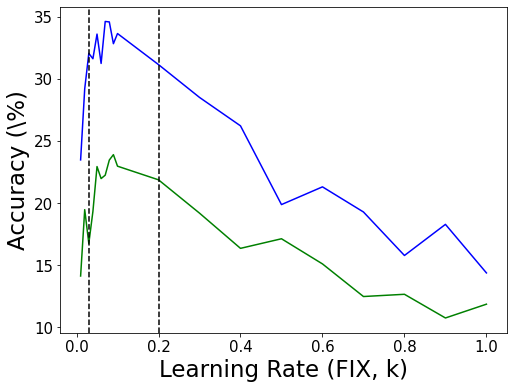

In [94]:
plt.figure(figsize=(8.0, 6.0))
plt.xlabel('Learning Rate (FIX, k)', fontsize = 23)
plt.ylabel('Accuracy (\%)', fontsize = 23)


recordN = y_acc.shape[0]
for i in range(recordN-1, -1, -1):
    plt.plot(x_lr, y_acc[i], colors[i], label=str(y_acc_label[i])+' Epoch(s)')
# plt.xscale('log')
# plt.legend(bbox_to_anchor=(0.732, 1.01), loc=2, fontsize = 12.5, handlelength=1)
# plt.axvline(x=0.001, linestyle='dashed', color='k')
# plt.axvline(x=0.0005, linestyle='dashed', color='r')
# plt.axvline(x=0.006, linestyle='dashed', color='r')
plt.axvline(x=0.03, linestyle='dashed', color='k')
plt.axvline(x=0.2, linestyle='dashed', color='k')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.plot([0.001, 0.020], [81, 10], 'r--')
# plt.savefig('acc-lr-cifar10-FIX.png')

In [ ]:
# Training
# LR range: 0.03 ~ 0.2

In [ ]:
import time
start = time.time()
losses, top1, top5 = train(train_loader, model, criterion, optimizer, epoch, args, lrbenchLR)
end = time.time()
print(end-start)

In [ ]:
values = [v.item() for v in trainResults[2][1][0][1].values]

In [ ]:
plt.plot(values)

In [ ]:
print(top1.values[1])

In [ ]:
print(end - start)

In [ ]:
for epoch in range(args.start_epoch, args.epochs):
    if args.distributed:
        train_sampler.set_epoch(epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch, args)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion, args)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    if not args.multiprocessing_distributed or (args.multiprocessing_distributed
            and args.rank % ngpus_per_node == 0):
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.arch,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
        }, is_best)